In [6]:
import glob
import os
import shutil

import numpy as np
import pylab as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
from pipeline.python.utils import convert_range
import scipy.stats as spstats


from pipeline.python.utils import natural_keys, label_figure
from pipeline.python import utils as putils

import traceback
from pipeline.python.retinotopy import utils as ret_utils
from pipeline.python.rois import utils as roi_utils
from pipeline.python.paradigm import utils as par_utils
from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf
import sklearn.metrics as skmetrics
from pipeline.python.coregistration import align_fov as coreg

import json
import tifffile as tf
from scipy import ndimage


import cv2
from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.colors as mcolors
import cPickle as pkl
import h5py

from matplotlib.lines import Line2D


from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.classifications import rf_utils as rfutils

from sklearn.linear_model import LinearRegression, Ridge, Lasso
#from sklearn.model_selection import train_test_split
import scipy.stats as spstats
import sklearn.metrics as skmetrics #import mean_squared_error

import seaborn as sns

import imutils
from scipy.ndimage.morphology import binary_dilation

from pipeline.python.retinotopy import segment_retinotopy as seg

In [7]:
%matplotlib inline

In [8]:
def get_retino_metadata(experiment='retino', animalids=None,
                        roi_type='manual2D_circle', traceid=None,
                        rootdir='/n/coxfs01/2p-data', 
                        aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas'):

    sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
   
    meta_list=[]
    for (animalid, session, fov), g in sdata.groupby(['animalid', 'session', 'fov']):
        if animalids is not None:
            if animalid not in animalids:
                continue
        exp_list = [e for e in g['experiment'].values if experiment in e] 
        if len(exp_list)==0:
            print('skipping, no retino (%s, %s, %s)' % (animalid, session, fov)) 
        retino_dirs = glob.glob(os.path.join(rootdir, animalid, session, fov, '%s*' % experiment,
                                'retino_analysis'))
        # get analysis ids for non-pixel
        for retino_dir in retino_dirs:
            retino_run = os.path.split(os.path.split(retino_dir)[0])[-1]
            if traceid is None:
                rid_fpath = glob.glob(os.path.join(retino_dir, 'analysisids_*.json'))[0]
                with open(rid_fpath, 'r') as f:
                    retids = json.load(f)
                traceids = [r for r, res in retids.items() if res['PARAMS']['roi_type']==roi_type] 
                for traceid in traceids: 
                    meta_list.append(tuple([animalid, session, fov, retino_run, traceid]))
            else:
                meta_list.append(tuple([animalid, session, fov, retino_run, traceid]))

    return meta_list



In [9]:
def delete_files(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
            
    return

## Some aggregate plotting stuff

In [10]:
visual_areas = ['V1', 'Lm', 'Li', 'Ll']
colors = ['magenta', 'orange', 'dodgerblue', 'purple'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2], 'Ll': colors[3]}

#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 1projections
2

dpi = 150

## Set analysis parameters

In [11]:
rootdir = '/n/coxfs01/2p-data'
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

traceid = 'traces001'


In [12]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### RF params
responsive_test = None
responsive_thr = None
n_stds = None
response_type = 'dff'
rf_fit_thr=0.5
do_spherical_correction=False
rf_type = 'sphr' if do_spherical_correction else ''
rf_fit_desc = fitrf.get_fit_desc(response_type=response_type, do_spherical_correction=do_spherical_correction)
print(rf_fit_desc)

#### Filter RF datasets by
rf_filter_by='drop_repeats_%s' % rf_type

#### Filter RETINO datasets by
pass_criterion='pixels'
mag_thr = 0.002
mag_thr = 0.1 if pass_criterion=='npmean' else mag_thr

##### Results key identifier
magthr_str = '%s_thr-%.3f' % (pass_criterion, mag_thr)
print(magthr_str)


fit-2dgaus_dff-no-cutoff
pixels_thr-0.002


In [13]:
# Set data identifiers

retino_dataid = 'retinobar_%s-thr-%.3f' % (pass_criterion, mag_thr)
rf_dataid = 'rfs_%s-thr-%.3f' % (rf_filter_by, rf_fit_thr)

data_id = '%s|%s|%s|%s' % (fov_type, state, retino_dataid, rf_dataid)
print(data_id)


zoom2p0x|awake|retinobar_pixels-thr-0.002|rfs_drop_repeats_-thr-0.500


# Set output dirs

In [14]:
basedir = os.path.join(aggr_dir, 'receptive-fields', '%s__%s' % (traceid, rf_fit_desc), 'scatter')

if not os.path.exists(basedir):
    os.makedirs(basedir)
basedir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter'

# Select data

In [15]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

In [17]:
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
rf_dsets = sdata[sdata['experiment'].isin(['rfs', 'rfs10'])]

assigned_cells = seg.get_cells_by_area(rf_dsets)


Segmentation, missing:
20190502_JC076_fov1
20191007_JC091_fov1
20191008_JC091_fov1
20190527_JC092_fov2
20190615_JC097_fov1
20190615_JC097_fov3
20191004_JC110_fov1
20191004_JC110_fov4
20191012_JC113_fov3
20191108_JC113_fov2
20191106_JC120_fov3
20191106_JC120_fov4


In [18]:
incl = aggr.get_dsets_with_max_rfs(rf_dsets, assigned_cells)
incl[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()


N dpaths: 70, N unfit: 0
N datasets included: 70, N sessions excluded: 4


animalid  session  fov
visual_area                        
Li                 16       16   16
Lm                 16       16   16
V1                 10       10   10

In [66]:
fovkeys[animalid]['Li'][0]

('20191106_fov1', '20191111')

In [143]:
counts_by_fov[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

animalid  session  fov
visual_area                        
Li                 24       24   24
Lm                 21       21   21
V1                 16       16   16

In [19]:
incl

visual_area              datakey  cell animalid   session   fov
0           Li  20190502_JC076_fov1    19    JC076  20190502  fov1
1           Li  20190522_JC089_fov1     9    JC089  20190522  fov1
2           Li  20190605_JC090_fov1    17    JC090  20190605  fov1
3           Li  20190602_JC091_fov1    83    JC091  20190602  fov1
4           Li  20190614_JC091_fov1    99    JC091  20190614  fov1
5           Li  20191008_JC091_fov1    46    JC091  20191008  fov1
6           Li  20190527_JC092_fov2    14    JC092  20190527  fov2
7           Li  20190527_JC092_fov3    42    JC092  20190527  fov3
8           Li  20190528_JC092_fov1     7    JC092  20190528  fov1
9           Li  20190612_JC099_fov1    40    JC099  20190612  fov1
10          Li  20190617_JC099_fov1    11    JC099  20190617  fov1
11          Li  20191003_JC111_fov1    11    JC111  20191003  fov1
12          Li  20191012_JC113_fov1     3    JC113  20191012  fov1
13          Li  20191017_JC113_fov1    37    JC113  20191017  fov1
14          Li  20191104_JC117_fov1    32    JC117  20191104  fov1
15          Li  20191106_JC120_fov1    20    JC120  20191106  fov1
16          Lm  20190423_JC076_fov1    15    JC076  20190423  fov1
17          Lm  20190509_JC078_fov1    15    JC078  20190509  fov1
18          Lm  20190430_JC078_fov1    36    JC078  20190430  fov1
19          Lm  20190603_JC080_fov1    57    JC080  20190603  fov1
20          Lm  20190602_JC080_fov2    34    JC080  20190602  fov2
21          Lm  20190508_JC083_fov1    70    JC083  20190508  fov1
22          Lm  20190525_JC084_fov1    38    JC084  20190525  fov1
23          Lm  20190627_JC091_fov1     9    JC091  20190627  fov1
24          Lm  20190615_JC097_fov3    47    JC097  20190615  fov3
25          Lm  20190618_JC097_fov1    32    JC097  20190618  fov1
26          Lm  20191004_JC110_fov3    11    JC110  20191004  fov3
27          Lm  20191004_JC110_fov4    19    JC110  20191004  fov4
28          Lm  20191012_JC113_fov3    18    JC113  20191012  fov3
29          Lm  20191104_JC117_fov2    50    JC117  20191104  fov2
30          Lm  20191111_JC117_fov2     2    JC117  20191111  fov2
31          Lm  20191106_JC120_fov4     8    JC120  20191106  fov4
32          V1  20190420_JC076_fov1    36    JC076  20190420  fov1
33          V1  20190507_JC083_fov1    56    JC083  20190507  fov1
34          V1  20190522_JC084_fov1   130    JC084  20190522  fov1
35          V1  20190622_JC085_fov1   118    JC085  20190622  fov1
36          V1  20190613_JC097_fov1   114    JC097  20190613  fov1
37          V1  20190615_JC097_fov1   141    JC097  20190615  fov1
38          V1  20190616_JC097_fov1   149    JC097  20190616  fov1
39          V1  20191006_JC110_fov1   100    JC110  20191006  fov1
40          V1  20191111_JC117_fov1    21    JC117  20191111  fov1
41          V1  20191106_JC120_fov3    66    JC120  20191106  fov3

In [20]:
edata = pd.concat([g for (v, k), g in sdata.groupby(['visual_area', 'datakey']) if k in incl['datakey'].values])

In [22]:
sdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

animalid  session  fov
visual_area                        
Li                 26       26   26
Lm                 22       22   22
V1                 18       18   18

# Load datasets

In [23]:
# Get datasets that have BOTH rfs and retinogradient measured
#sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
bothdata = pd.concat([g for s, g in edata.groupby(['animalid', 'session', 'fov']) \
                        if ('retino' in edata['experiment'].values) and \
                        ('rfs' in edata['experiment'].values or 'rfs10' in edata['experiment'].values)])
bothdata['datakey'] = ['_'.join([session, animalid, 'fov%i' % fovnum]) \
                         for (session, animalid, fovnum) in bothdata[['session', 'animalid', 'fovnum']].values]

common_datakeys = bothdata['datakey'].unique()

bothdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

animalid  session  fov
visual_area                        
Li                 16       16   16
Lm                 16       16   16
V1                 10       10   10

In [24]:
retdata = bothdata[bothdata['experiment']=='retino'].copy()
print("N retinobar experiment fovs:")
print(retdata.groupby(['visual_area']).count())

N retinobar experiment fovs:
             animalid  experiment  fov  session  fovnum  datakey
visual_area                                                     
Li                 14          14   14       14      14       14
Lm                 13          13   13       13      13       13
V1                  8           8    8        8       8        8


In [25]:
retdata.head()

animalid experiment            fov   session visual_area  fovnum  \
123    JC076     retino  FOV1_zoom2p0x  20190420          V1       1   
128    JC076     retino  FOV1_zoom2p0x  20190423          Lm       1   
138    JC078     retino  FOV1_zoom2p0x  20190430          Lm       1   
141    JC078     retino  FOV1_zoom2p0x  20190509          Lm       1   
154    JC080     retino  FOV2_zoom2p0x  20190602          Lm       2   

                 datakey  
123  20190420_JC076_fov1  
128  20190423_JC076_fov1  
138  20190430_JC078_fov1  
141  20190509_JC078_fov1  
154  20190602_JC080_fov2

In [27]:
# animalid='JC084'
# session = '20190522'
# fov='FOV1_zoom2p0x'
# retinorun='retino_run1'
# fpaths = glob.glob(os.path.join(rootdir, animalid, session, fov, retinorun,
#                                             'retino_analysis', 'retino_structure', 
#                                     'projections_*.pkl')) 
# fpaths = [f for f in fpaths if '_pixels_thr' not in f]
        
# fpaths

In [1]:
from pipeline.python.classifications import gradient_estimation as grad


/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
print("Threshold info: %s" % magthr_str)
meta_list = get_retino_metadata(experiment='retino', traceid=traceid)

proj_fit_paths=[]; errors=[];
for (animalid, session, fov, retinorun, _) in meta_list:
    # Load data metainfo
    run_dir = os.path.join(rootdir, animalid, session, fov, retinorun)
    RETID = ret_utils.load_retinoanalysis(run_dir, traceid)
    analysis_dir = RETID['DST']
    #retinoid = RETID['analysis_id']
    fpaths = grad.projection_results_fpaths(animalid, session, fov, retinorun=retinorun, results_type='projections')
    for f in fpaths:
        proj_fit_paths.append((animalid, session, fov, retinorun, f)) # retinoid, f))
print("%i of %i paths found" % (len(proj_fit_paths), len(meta_list)))

print("----errors----:")
print(errors)

NameError: name 'magthr_str' is not defined

In [29]:
len(proj_fit_paths)

72

In [42]:
basedir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter'

# ----------------------------------------------------------------------------------------------------
# Aggregate projection results
This is output of classifications/aggregate_gradient_estimates()


In [43]:
# Create dir to copy gradient images to, for visual inspection
copy_images = True

if copy_images:
    dst = os.path.join(basedir, 'session_inputs')
    if not os.path.exists(dst):
        os.makedirs(dst)
    delete_files(dst)
    print(dst)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/session_inputs


In [44]:
os.listdir(dst)

[]

In [45]:
d_list=[]
for di, (animalid, session, fov, retinorun, fpath) in enumerate(proj_fit_paths):
    if di % 20 == 0 or di==(len(proj_fit_paths)-1):
        print("%i of %i gradient result files loaded." % (int(di+1), len(proj_fit_paths)))
        
    fovnum = int(fov.split('_')[0][3:])
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    with open(fpath, 'rb') as f:
        res = pkl.load(f)
    
    tmpd = res['regr_df'].copy()
    visual_area = os.path.splitext(os.path.split(fpath)[-1])[0].split('_')[-1]
    
    metainfo = {'visual_area': visual_area, 'animalid': animalid, 'session': session, 'fov': fov,
               'retinorun': retinorun, 'datakey': datakey, 'fpath':fpath}
    tmpd = putils.add_meta_to_df(tmpd, metainfo)
    d_list.append(tmpd)

    if copy_images:
        src = os.path.split(fpath)[0]
        fimpaths = glob.glob(os.path.join(src, 'gradients*.svg'))
        fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.svg')))
        for fimpath in fimpaths:
            fname, fext = os.path.splitext(os.path.split(fimpath)[-1])
            shutil.copyfile(fimpath, os.path.join(dst, '%s_%s_%s_%s%s' \
                                                  % (visual_area, datakey, retinorun, fname, fext)))

            
projection_df = pd.concat(d_list, axis=0).reset_index(drop=True)
projection_df['abs_coef'] = abs(projection_df['coefficient'])
projection_df['cortical_mag'] = 1./projection_df['abs_coef']

print(projection_df.shape)
projection_df.head()

projection_df=projection_df[projection_df['visual_area'].isin(visual_areas)]

1 of 72 gradient result files loaded.
21 of 72 gradient result files loaded.
41 of 72 gradient result files loaded.
61 of 72 gradient result files loaded.
72 of 72 gradient result files loaded.
(144, 17)


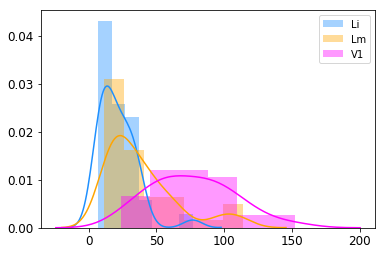

In [46]:
r2_thr=0.75
fig, ax = pl.subplots()
for visual_area, g in projection_df[projection_df['R2']>r2_thr].groupby(['visual_area']):
    sns.distplot(g['cortical_mag'].values, ax=ax, color=area_colors[visual_area], label=visual_area)
ax.legend()

# Cortical magnification

In [47]:
def plot_pairwise_by_axis(plotdf, curr_metric='abs_coef', c1='az', c2='el', 
                          compare_var='cond', fontsize=10, fontcolor='k', fmt='%.2f', xytext=(0, 10),
                          area_colors=None, legend=True, label_rotation=0, ha='center', ax=None):
    if ax is None:
        fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
        fig.patch.set_alpha(0)
        ax.patch.set_alpha(0)
        
    ax = aggr.pairwise_compare_single_metric(plotdf, curr_metric=curr_metric, ax=ax,
                                                c1=c1, c2=c2, compare_var=compare_var)
    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=fontsize, fontcolor=fontcolor, fmt=fmt, xytext=xytext)
    
    # Set x labels
    aggr.set_split_xlabels(ax, a_label=c1, b_label=c2, rotation=label_rotation, ha=ha)

    if legend:
        # Get counts of samples for legend
        legend_elements = aggr.get_counts_for_legend(plotdf, area_colors=area_colors, markersize=10, marker='_')
        ax.legend(handles=legend_elements, bbox_to_anchor=(1.5,1.1), fontsize=8)

    return ax


In [48]:
def plot_axis_distributions(projdf, currmetric='abs_coef', hue='cond',
                            currcols=['windows blue', 'amber'], area_colors=None,
                             fontsize=10, fontcolor='k', fmt='%.2f', xytext=(0, 10)):

    bi_palette = sns.xkcd_palette(currcols)

    fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)

    sns.stripplot(x='visual_area', y=currmetric, hue=hue, data=projdf, 
                  dodge=True, palette=bi_palette, ax=ax, size=10, zorder=0,
                 order=['V1', 'Lm', 'Li'])
    #if barplot:
    sns.barplot("visual_area", currmetric, data=projdf,
               hue=hue, order=visual_areas, errcolor="k",
               edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)

    #ax.set_ylim([0, 0.12])
    sns.despine(bottom=True, trim=True)
    ax.tick_params(which='both', axis='x', size=0)
    pl.legend(bbox_to_anchor=((1.2, 1)))
    projdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=fontsize, fontcolor=fontcolor, fmt=fmt, xytext=xytext)

    # Set x labels
    aggr.set_split_xlabels(ax, a_label='az', b_label='el')

    # Get counts of samples for legend
    legend_elements = aggr.get_counts_for_legend(projdf, area_colors=area_colors, markersize=10, marker='_')
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.5,1.2), fontsize=8)

    return fig

# Filter retino gradient results
- (Set some R2 threshold)
- "Bad" fits suggests that the retino gradient was messed up or points were all over the place?
- Also, drop extra run (retino_run1, and retino_run2)
- May have duplicate FOVS.

In [49]:
projection_df[['visual_area', 'datakey', 'retinorun']].drop_duplicates()['visual_area'].value_counts()

Li    23
Lm    22
V1    22
Name: visual_area, dtype: int64

In [50]:
# Identify datasets where BOTH _run1 and _run2 found:
repeat_retinos = pd.concat([g for k, g in projection_df.groupby(['visual_area', 'datakey']) \
                            if len(g['retinorun'].unique())>1], axis=0)
repeat_retinos[['visual_area', 'datakey', 'retinorun']].drop_duplicates()

visual_area              datakey    retinorun
28          V1  20190507_JC083_fov1  retino_run1
30          V1  20190507_JC083_fov1  retino_run2
48          V1  20190522_JC084_fov1  retino_run1
50          V1  20190522_JC084_fov1  retino_run2

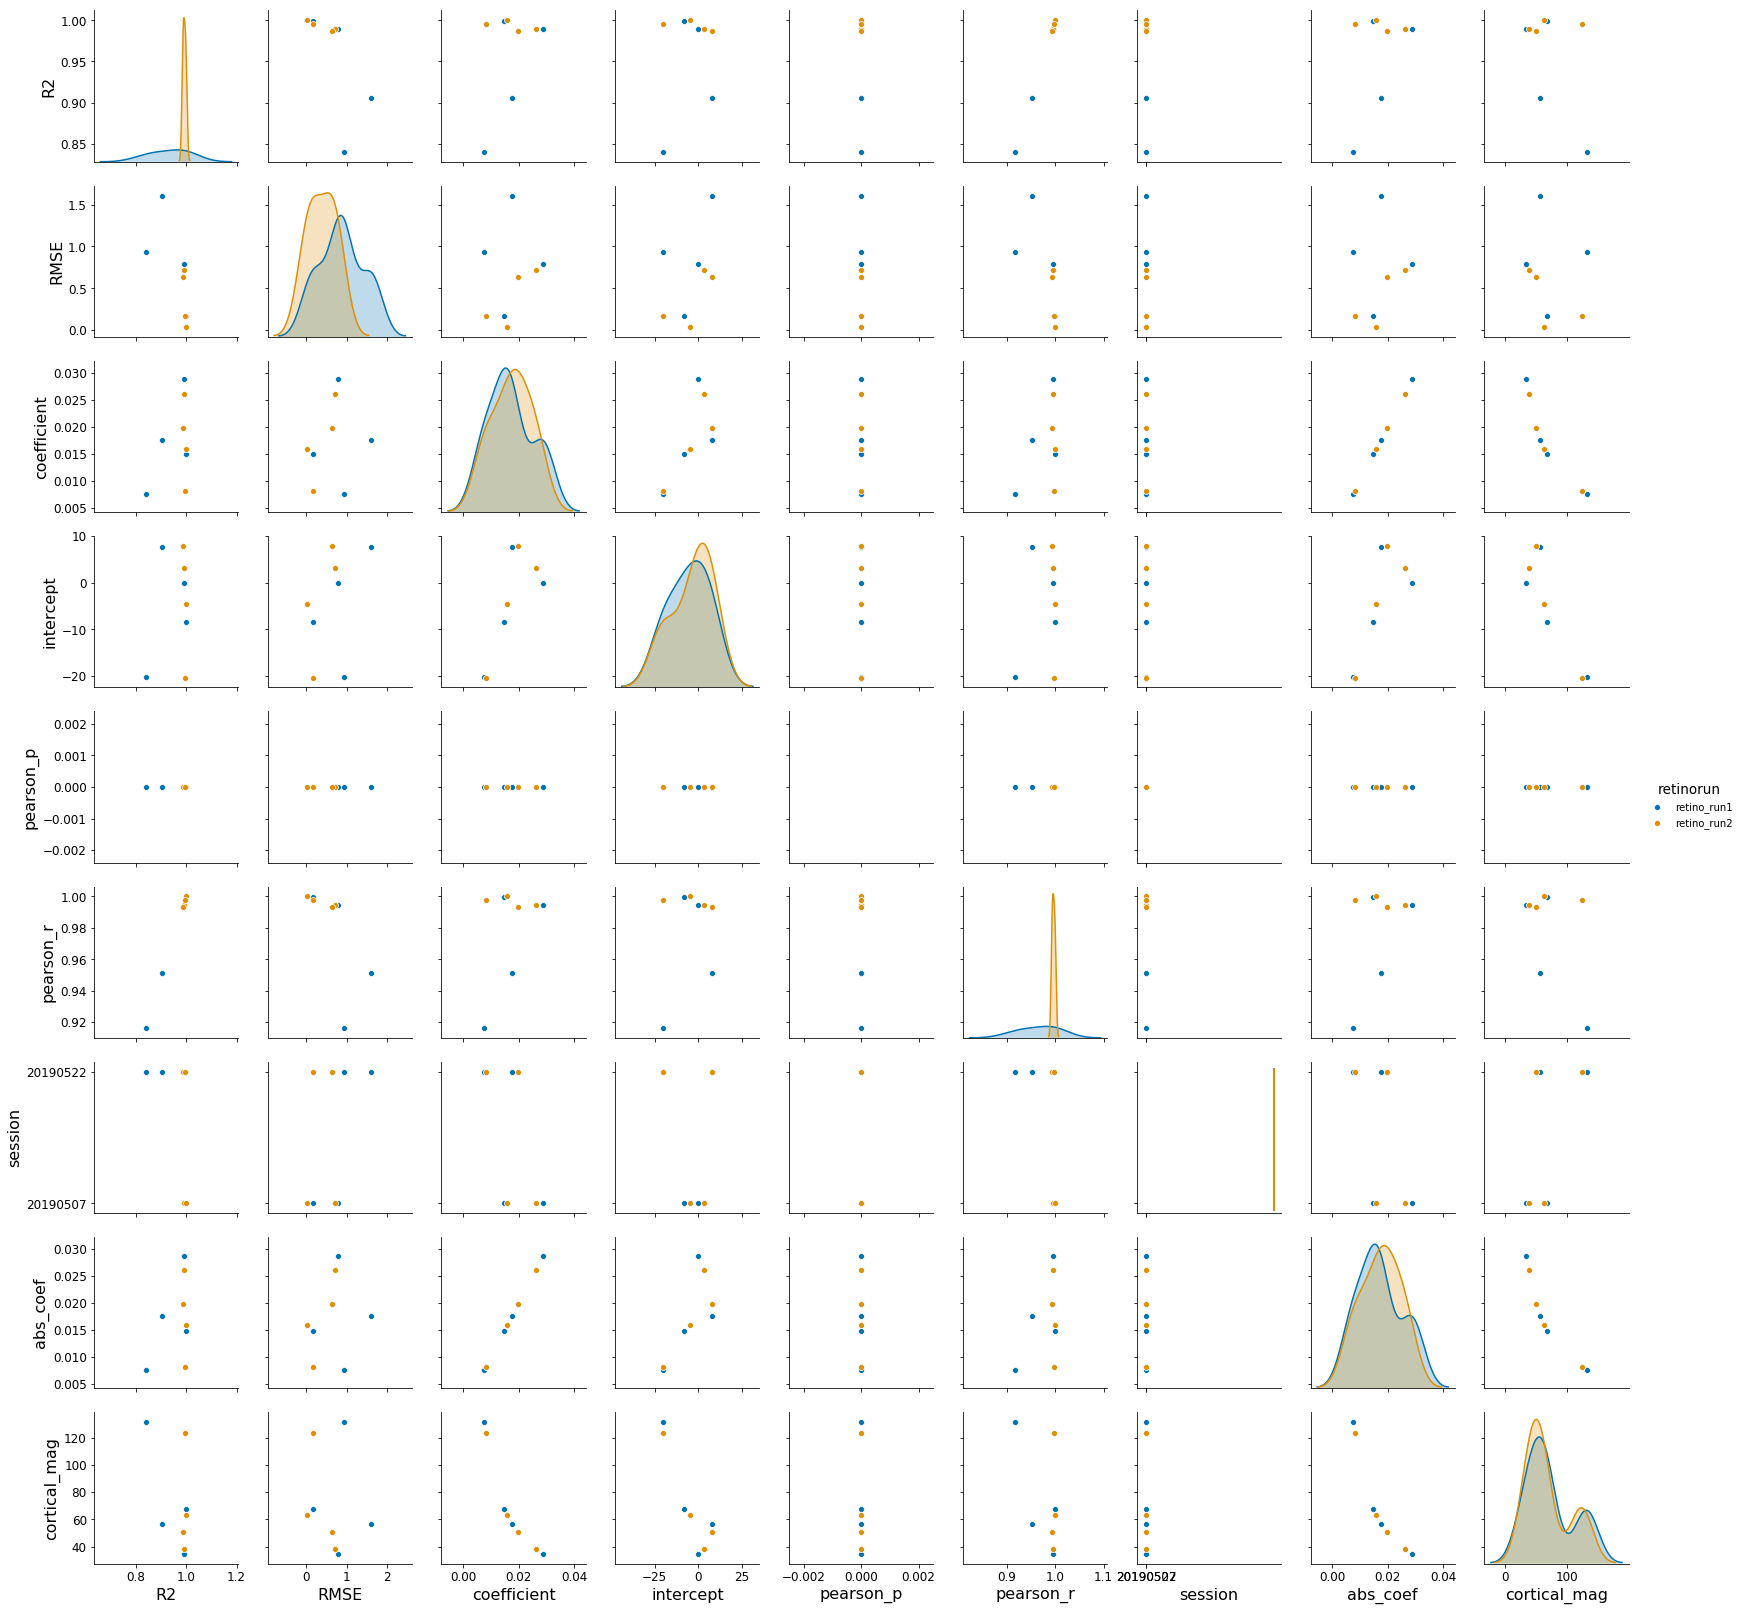

In [51]:
sns.pairplot(repeat_retinos, hue='retinorun', palette='colorblind')

# Remove repeat runs

In [53]:
gradient_df = pd.concat([g[g['retinorun']=='retino_run2'] if len(g['retinorun'].unique())>1 else g for k, g in projection_df.groupby(['visual_area', 'datakey'])], axis=0)
gradient_df['retinokey'] = ['%s_%s' % (dk, rrun) for dk, rrun in gradient_df[['datakey', 'retinorun']].values]
print(projection_df.shape, gradient_df.shape)


((134, 17), (130, 18))


# Filter FOVs, only select good gradient fits

In [99]:
retino_r2_thr=0.75
all_retino_datakeys = gradient_df['datakey'].unique()
    
# Select FOVs with BOTH azimuth and elevation passed
projdf0 = pd.concat([g for (visual_area, datakey, retinorun), g in gradient_df.groupby(['visual_area', 'datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > retino_r2_thr) and (g[g['cond']=='el']['R2'].values > retino_r2_thr))])
print(gradient_df.shape, projdf0.shape)

# Get datakeys for FOVs that pass
pass_retino_datakeys = projdf0['datakey'].unique()
fail_retino_datakeys = [r for r in projection_df['datakey'].unique() if r not in pass_retino_datakeys]
print("%i of %i retinokeys pass threshold (R2=%.2f)" % (len(pass_retino_datakeys), len(all_retino_datakeys), retino_r2_thr))


((130, 18), (98, 18))
45 of 53 retinokeys pass threshold (R2=0.75)


In [107]:

projdf = pd.concat([g for (v, k), g in projdf0.groupby(['visual_area', 'datakey']) 
             if len(retdata[(retdata['visual_area']==v) & (retdata['datakey']==k)])>0])

no_repeats_retino = projdf.copy()

In [101]:
projdf[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

animalid  session  fov
visual_area                        
Li                 10       10   10
Lm                 10       10   10
V1                  7        7    7

In [65]:
projdf0[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

animalid  session  fov
visual_area                        
Li                 16       16   16
Lm                 20       20   20
V1                 13       13   13

In [142]:
projdf[projdf['visual_area']=='Li']

R2      RMSE  coefficient cond  intercept  pearson_p  pearson_r  \
58   0.818767  4.442515     0.052445   az -25.902518        0.0   0.904858   
59   0.891582  1.744710     0.028132   el   3.843913        0.0   0.944236   
76   0.995036  1.190306     0.121181   az -45.498446        0.0   0.997515   
77   0.964424  0.929336     0.025623   el -18.280909        0.0   0.982051   
78   0.838448  6.722242     0.069950   az  -8.807577        0.0   0.915668   
79   0.872476  1.515617     0.026719   el -22.144876        0.0   0.934064   
64   0.888692  7.319988     0.123192   az -95.085357        0.0   0.942705   
65   0.930067  2.681974     0.047492   el  -9.526511        0.0   0.964400   
70   0.964424  4.220204     0.092921   az -81.615592        0.0   0.982051   
71   0.805755  2.895315     0.036674   el -16.556174        0.0   0.897638   
98   0.981795  3.287168     0.112630   az -70.106326        0.0   0.990856   
99   0.933968  1.959964     0.035474   el -10.013033        0.0   0.966420   
74   0.884533  6.987540     0.086469   az -35.368514        0.0   0.940496   
75   0.900446  2.675935     0.029570   el  18.689866        0.0   0.948918   
114  0.911488  4.571329     0.099344   az -85.231293        0.0   0.954719   
115  0.970165  1.036720     0.037454   el   2.968276        0.0   0.984970   
138  0.910212  4.972969     0.055385   az -44.459667        0.0   0.954050   
139  0.808715  3.503434     0.028305   el  -4.107794        0.0   0.899286   

       retinorun            fov   session animalid              datakey  \
58   retino_run1  FOV1_zoom2p0x  20190522    JC089  20190522_JC089_fov1   
59   retino_run1  FOV1_zoom2p0x  20190522    JC089  20190522_JC089_fov1   
76   retino_run1  FOV3_zoom2p0x  20190527    JC092  20190527_JC092_fov3   
77   retino_run1  FOV3_zoom2p0x  20190527    JC092  20190527_JC092_fov3   
78   retino_run1  FOV1_zoom2p0x  20190528    JC092  20190528_JC092_fov1   
79   retino_run1  FOV1_zoom2p0x  20190528    JC092  20190528_JC092_fov1   
64   retino_run1  FOV1_zoom2p0x  20190602    JC091  20190602_JC091_fov1   
65   retino_run1  FOV1_zoom2p0x  20190602    JC091  20190602_JC091_fov1   
70   retino_run1  FOV1_zoom2p0x  20190614    JC091  20190614_JC091_fov1   
71   retino_run1  FOV1_zoom2p0x  20190614    JC091  20190614_JC091_fov1   
98   retino_run1  FOV1_zoom2p0x  20190617    JC099  20190617_JC099_fov1   
99   retino_run1  FOV1_zoom2p0x  20190617    JC099  20190617_JC099_fov1   
74   retino_run1  FOV1_zoom2p0x  20191008    JC091  20191008_JC091_fov1   
75   retino_run1  FOV1_zoom2p0x  20191008    JC091  20191008_JC091_fov1   
114  retino_run1  FOV1_zoom2p0x  20191017    JC113  20191017_JC113_fov1   
115  retino_run1  FOV1_zoom2p0x  20191017    JC113  20191017_JC113_fov1   
138  retino_run1  FOV1_zoom2p0x  20191106    JC120  20191106_JC120_fov1   
139  retino_run1  FOV1_zoom2p0x  20191106    JC120  20191106_JC120_fov1   

    visual_area     retinoid  \
58           Li  analysis002   
59           Li  analysis002   
76           Li  analysis002   
77           Li  analysis002   
78           Li  analysis002   
79           Li  analysis002   
64           Li  analysis002   
65           Li  analysis002   
70           Li  analysis002   
71           Li  analysis002   
98           Li  analysis002   
99           Li  analysis002   
74           Li  analysis002   
75           Li  analysis002   
114          Li  analysis002   
115          Li  analysis002   
138          Li  analysis002   
139          Li  analysis002   

                                                 fpath  abs_coef  \
58   /n/coxfs01/2p-data/JC089/20190522/FOV1_zoom2p0...  0.052445   
59   /n/coxfs01/2p-data/JC089/20190522/FOV1_zoom2p0...  0.028132   
76   /n/coxfs01/2p-data/JC092/20190527/FOV3_zoom2p0...  0.121181   
77   /n/coxfs01/2p-data/JC092/20190527/FOV3_zoom2p0...  0.025623   
78   /n/coxfs01/2p-data/JC092/20190528/FOV1_zoom2p0...  0.069950   
79   /n/coxfs01/2p-data/JC092/20190528/FOV1_zoom2p0...  0.026719   
64   /n/coxfs01/2

In [103]:
#exclude_retinos = [ '20190605_JC090_fov1', '20191106_JC120_fov1', '20191111_JC120_fov1', '20191012_JC113_fov3']

#include_retinos = ['20190527_JC092_fov3', '20190609_JC099_fov1', '20190612_JC099_fov1', '20191003_JC111_fov1',
#                  '20190617_JC099_fov1', '20191105_JC117_fov1', '20191106_JC120_fov1'] #, '20191111_JC120_fov1']

#exclude_retinos = projdf[(projdf['visual_area']=='Li') 
#                         & ~(projdf['datakey'].isin(include_retinos))]['datakey'].unique()

# exclude_retinos 

In [145]:
rmags[rmags['ratio_el_az']>3]

datakey  ratio_el_az visual_area
1   20190527_JC092_fov3     4.729378          Li
5   20190617_JC099_fov1     3.174984          Li
11  20190525_JC084_fov1     3.238839          Lm
14  20190627_JC091_fov1     3.448630          Lm

In [69]:
#exclude_retinos = ['20190602_JC080_fov2', '20191104_JC117_fov2', '20190527_JC092_fov3', '20191111_JC120_fov1', '20191105_JC117_fov1']

******************
[('V1', 'Lm')] p=0.075 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.014 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.423 (fdr_bh), reject H0=False
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter', 'ratiomag__R2-0.75_pixels_thr-0.002_drop_repeats')


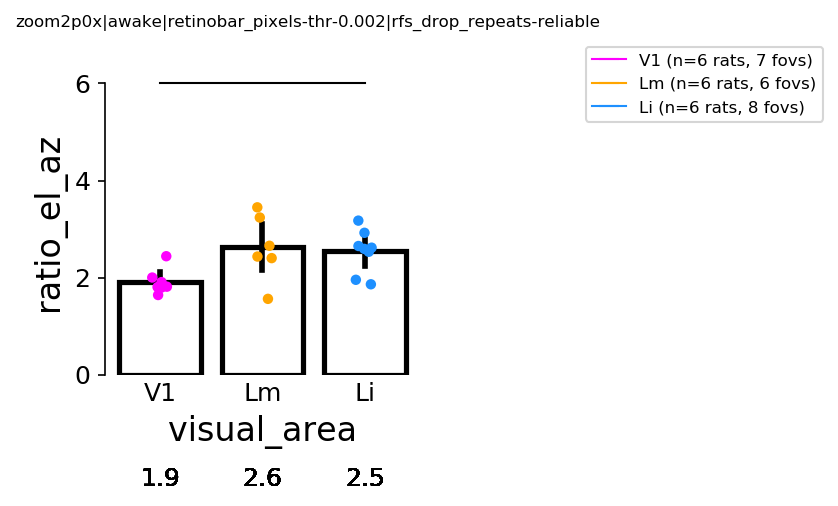

In [146]:
exclude_retinos = ['20191104_JC117_fov2', '20190602_JC080_fov2', '20191111_JC117_fov2', '20190527_JC092_fov3']
multi_comp_test = 'fdr_bh'
currdf = projdf[~projdf['datakey'].isin(exclude_retinos)]
#currdf = projdf.copy()

#currdf = projdf[projdf['datakey'].isin(include_retinos)]

rmags = pd.DataFrame({
    'ratio_el_az': [float(g[g['cond']=='el']['cortical_mag'].values/g[g['cond']=='az']['cortical_mag'].values) \
              for (visual_area, datakey), g in currdf.groupby(['visual_area', 'datakey'])],
    'visual_area': [visual_area for (visual_area, datakey), g in currdf.groupby(['visual_area', 'datakey'])],
    'datakey': [datakey for (visual_area, datakey), g in currdf.groupby(['visual_area', 'datakey'])]})


fig, ax =pl.subplots(figsize=(3,3), dpi=dpi)
sns.stripplot(x='visual_area', y='ratio_el_az', hue='visual_area', data=rmags,
             palette=area_colors, order=visual_areas, ax=ax)

#if barplot:
sns.barplot("visual_area", 'ratio_el_az', data=rmags, ax=ax,
           hue=None, order=visual_areas, errcolor="k",
           edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)

print("******************")
y_loc = 5
statresults = aggr.do_mannwhitney(rmags, metric='ratio_el_az', multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax, y_loc=y_loc, offset=1)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(currdf, area_colors=area_colors,
                                        markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1.5,1.1), fontsize=8)
        
sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)

pl.subplots_adjust(left=0.2, bottom=0.2)
putils.label_figure(fig, data_id)
rmags.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k', fmt='%.1f', xytext=(0,-50))

figname = 'ratiomag__R2-%.2f_%s_%s' % (retino_r2_thr, magthr_str, rf_filter_by)
pl.savefig(os.path.join(basedir, 'drop_repeats', '%s.svg' % figname))
print(basedir, figname)

### Cortical mag, PAIRED

V1: (t-stat:-8.25, p=0.00)
Lm: (t-stat:-8.01, p=0.00)
Li: (t-stat:-15.24, p=0.00)
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter', 'cortical_mag_paired-az-el_all-retino-dsets__R2-0.75_pixels_thr-0.002_drop_repeats')


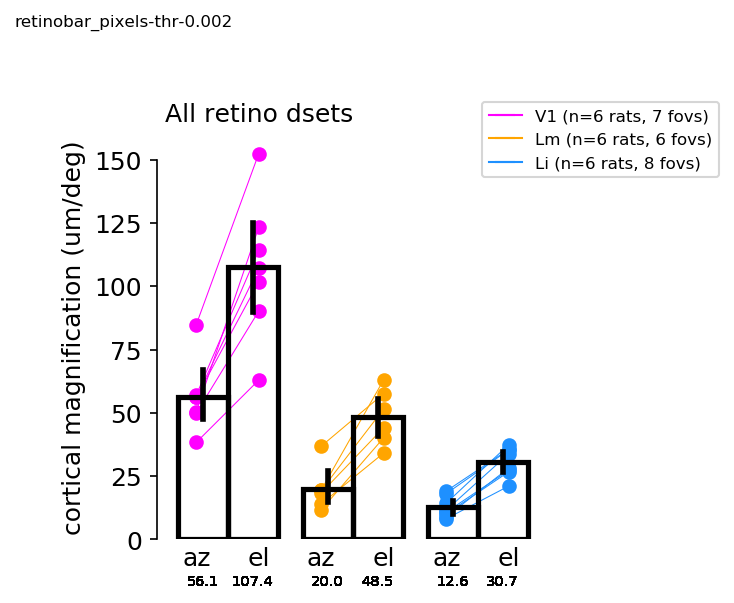

In [147]:
metric = 'cortical_mag'
#metric = 'abs_coef'
currdf = projdf[~projdf['datakey'].isin(exclude_retinos)]

fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
ax = plot_pairwise_by_axis(currdf, curr_metric=metric, c1='az', c2='el', ax=ax,
                           area_colors=area_colors, fontsize=7, fontcolor='k', fmt='%.1f', xytext=(0, -20))
pl.subplots_adjust(left=0.2, right=0.7, top=0.8)
if metric=='abs_coef':
    ax.set_ylabel('rate of retinotopic change (deg/um)', fontsize=12)
else:
    ax.set_ylabel('cortical magnification (um/deg)', fontsize=12)
    
ax.set_title('All retino dsets', fontsize=12, loc='left')
sns.despine(trim=True,bottom=True)
    
putils.label_figure(fig, retino_dataid)

figname = '%s_paired-az-el_all-retino-dsets__R2-%.2f_%s_%s' % (metric, retino_r2_thr, magthr_str, rf_filter_by)
pl.savefig(os.path.join(basedir, 'drop_repeats', '%s.svg' % figname))
print(basedir, figname)

# Scatter

In [73]:
from pipeline.python.rois.utils import load_roi_coords

In [74]:
def get_rf_dataframe(filter_by=None, fit_thr=0.5, traceid='traces001',
                    fit_desc='fit-2dgaus_dff-no-cutoff', fov_type='zoom2p0x',
                    state='awake', stimulus='rfs', verbose=False):
    
    #### Get non-repeated FOV datasets
    r_df, dkey_dict = rfutils.aggregate_rf_dataframes(filter_by, fit_thr=fit_thr,
                                                      traceid=traceid, fit_desc=fit_desc,
                                                      reliable_only=reliable_only, verbose=verbose,
                                                      fov_type=fov_type, state=state, stimulus=stimulus)

    return r_df

In [75]:
def abline(slope, intercept, ax=None, color='purple', ls='-',
           label=True, label_prefix=''):
    """Plot a line from slope and intercept"""
    if ax is None:
        fig, ax = pl.subplots()
    #axes = plt.gca()
    #x_vals = np.array(axes.get_xlim())
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    label_str = '(%s) y=%.2fx+%.2f' % (label_prefix, slope, intercept) if label else None
    ax.plot(x_vals, y_vals, '--', label=label_str, color=color, ls=ls)
    ax.legend()
    return ax

In [76]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


## Get screen info

In [77]:
screen = putils.get_screen_dims()
screenleft, screenright = [-screen['azimuth_deg']*0.5, screen['azimuth_deg']*0.5]
screenbottom, screentop = [-screen['altitude_deg']*0.5, screen['altitude_deg']*0.5]

## Filter RF datasets (e.g., drop_repeats)

In [78]:
#rf_filter_by = None # 'drop_repeats'
rf_filter_by = 'drop_repeats'

reliable_only = True
reliable_str = 'reliable' if reliable_only else ''

rf_dataid = 'rfs_%s-%s' % (rf_filter_by, reliable_str)
print(rf_dataid)


rfs_drop_repeats-reliable


In [79]:
# Set data identifiers

#retino_dataid = '%s|%s|retinobar-%s' % (fov_type, state, magthr_str)
#rf_dataid = '%s|%s|rfs-%s' % (fov_type, state, rf_fit_desc)

data_id = '%s|%s|%s|%s' % (fov_type, state, retino_dataid, rf_dataid)
print(data_id)


zoom2p0x|awake|retinobar_pixels-thr-0.002|rfs_drop_repeats-reliable


# Load cell positions (and RF info)

In [82]:
aggr_rf_dir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, rf_fit_desc))
if not os.path.exists(aggr_rf_dir):
    os.makedirs(aggr_rf_dir)
print("... saving output to base dir:\n%s" % aggr_rf_dir)

print("Found saved position info:")

glob.glob(os.path.join(aggr_rf_dir, 'fits_and_coords_None_%s.pkl' %  reliable_str))


... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff
Found saved position info:


['/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl']

In [84]:
# Load the one that has ALL rfs/rfs10 (just without repeat FOVs)
df_fpath = glob.glob(os.path.join(aggr_rf_dir, 'fits_and_coords_None_%s*.pkl' % (reliable_str)))[0]
print(df_fpath)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl


In [85]:
df_fpath = os.path.join(aggr_rf_dir, 'fits_and_coords_None_%s.pkl' % ( reliable_str))
print(df_fpath)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl


In [86]:
get_positions = False
if os.path.exists(df_fpath) or get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'rb') as f:
            rf_df = pkl.load(f)
        if isinstance(rf_df, dict):
            rf_df = rf_df['df']
    except Exception as e:
        get_positions = True
print(get_positions)

Loading existing RF coord conversions...
False


In [87]:
if get_positions:
    # Get RF fit info first
    rf_df = get_rf_dataframe(filter_by=rf_filter_by, 
                     fit_thr=rf_fit_thr, traceid=traceid, fit_desc=rf_fit_desc,
                    verbose=False, fov_type=fov_type, state=state, stimulus='rfs')
    
    print("Calculating RF coord conversions...")
    pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
    for p in pos_params:
        rf_df[p] = ''
    
    # Add fov coord info and save
    p_list=[]
    for (animalid, session, fovnum, exp), g in rf_df.groupby(['animalid', 'session', 'fovnum', 'experiment']):
        cell_ids = g['cell'].unique()
        fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                  traceid=traceid, create_new=False)
        p_ = fcoords['roi_positions'].loc[cell_ids]
        for p in pos_params:
            rf_df[p][g.index] = p_[p]

    with open(df_fpath, 'wb') as f:
        pkl.dump(rf_df, f, protocol=pkl.HIGHEST_PROTOCOL)

In [88]:
from pipeline.python.retinotopy import segment_retinotopy as seg

In [90]:

#edata = sdata[sdata['experiment'].isin(['rfs', 'rfs10', 'retino'])].copy()
cells = seg.get_cells_by_area(bothdata)
rf_df = aggr.get_rfdata(cells, rf_df, verbose=False, average_repeats=True)


#rf_edf = aggr.get_rfdata(cells, r_df, verbose=False, average_repeats=True)

Segmentation, missing:
20190502_JC076_fov1
20191008_JC091_fov1
20190527_JC092_fov2
20190615_JC097_fov1
20190615_JC097_fov3
20191004_JC110_fov4
20191012_JC113_fov3
20191106_JC120_fov3
20191106_JC120_fov4


In [91]:
rf_df=rf_df[rf_df['visual_area'].isin(visual_areas)]

In [94]:
rf_df.groupby(['visual_area', 'datakey', 'experiment']).count()


animalid  session  fov_xpos  \
visual_area datakey             experiment                                 
Li          20190522_JC089_fov1 average_rfs         5        5         5   
            20190527_JC092_fov3 average_rfs        38       38        38   
            20190528_JC092_fov1 average_rfs         6        6         6   
            20190602_JC080_fov2 average_rfs         1        1         1   
            20190602_JC091_fov1 average_rfs        72       72        72   
            20190612_JC099_fov1 average_rfs        25       25        25   
            20190614_JC091_fov1 average_rfs        73       73        73   
            20190617_JC099_fov1 average_rfs         8        8         8   
            20191012_JC113_fov3 average_rfs         1        1         1   
            20191017_JC113_fov1 average_rfs        27       27        27   
            20191106_JC120_fov1 average_rfs        19       19        19   
            20191106_JC120_fov3 average_rfs        50       50        50   
            20191106_JC120_fov4 average_rfs         4        4         4   
Lm          20190423_JC076_fov1 average_rfs        10       10        10   
            20190430_JC078_fov1 average_rfs        36       36        36   
            20190502_JC076_fov1 average_rfs        11       11        11   
            20190508_JC083_fov1 average_rfs        61       61        61   
            20190509_JC078_fov1 average_rfs         5        5         5   
            20190525_JC084_fov1 average_rfs        36       36        36   
            20190527_JC092_fov2 average_rfs         4        4         4   
            20190602_JC080_fov2 average_rfs        18       18        18   
            20190603_JC080_fov1 average_rfs        57       57        57   
            20190618_JC097_fov1 average_rfs        31       31        31   
            20190627_JC091_fov1 average_rfs         8        8         8   
            20191008_JC091_fov1 average_rfs        31       31        31   
            20191104_JC117_fov2 average_rfs        29       29        29   
            20191111_JC117_fov1 average_rfs         2        2         2   
            20191111_JC117_fov2 average_rfs         2        2         2   
V1          20190420_JC076_fov1 average_rfs         9        9         9   
            20190507_JC083_fov1 average_rfs        56       56        56   
            20190508_JC083_fov1 average_rfs         8        8         8   
            20190509_JC078_fov1 average_rfs         5        5         5   
            20190522_JC084_fov1 average_rfs       130      130       130   
            20190613_JC097_fov1 average_rfs       114      114       114   
            20190615_JC097_fov1 average_rfs       105      105       105   
            20190615_JC097_fov3 average_rfs        43       43        43   
            20190616_JC097_fov1 average_rfs       149      149       149   
            20190622_JC085_fov1 average_rfs       100      100       100   
            20191006_JC110_fov1 average_rfs       100      100       100   
            20191104_JC117_fov2 average_rfs        21       21        21   
            20191111_JC117_fov1 average_rfs        18       18        18   

                                             fov_ypos  ml_pos  ap_pos  cell  \
visual_area datakey             experiment                                    
Li          20190522_JC089_fov1 average_rfs         5       5       5     5   
            20190527_JC092_fov3 average_rfs        38      38      38    38   
            20190528_JC092_fov1 average_rfs         6       6       6     6   
            20190602_JC080_fov2 average_rfs         1       1       1     1   
            20190602_JC091_fov1 average_rfs        72      72      72    72   
            20190612_JC099_fov1 average_rfs        25      25      25    25   
            20190614_JC091_fov1 average_rfs        73      73      73    73   
            20190617_JC099_fov1 average_rfs         8       8    

In [120]:
df_fpath

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl'

(0, 1)

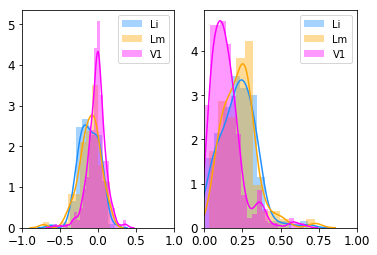

In [95]:
rf_r2_thr=0.5
fig, axn = pl.subplots(1,2)
ax=axn[0]
for visual_area, g in rf_df[rf_df['r2']>r2_thr].groupby(['visual_area']):
    sns.distplot(g['aniso_index'].values, ax=ax, color=area_colors[visual_area], label=visual_area)
ax.legend()
ax.set_xlim([-1, 1])

ax=axn[1]
for visual_area, g in rf_df[rf_df['r2']>r2_thr].groupby(['visual_area']):
    sns.distplot(g['anisotropy'].values, ax=ax, color=area_colors[visual_area], label=visual_area)
ax.legend()
ax.set_xlim([0, 1])

In [96]:
# no_retino=[]
# for (visual_area, datakey), g in r_df.groupby(['visual_area', 'datakey']):
#     if (projdf[projdf['datakey']==datakey].shape[0])==0:
#         no_retino.append((visual_area, datakey))
# for r in no_retino:
#     print r
    

# Get datasets with BOTH retino + rfs/rfs10 measured.
#### Also filter retino gradient df to only include dsets that have good fits (i.e., R2 > thr means retino direction well enough estimated or consistent enough to get a good projection)
NOTE:  TODO, check bad-fit retino dsets, since these may be split FOVs

In [108]:
retino_r2_thr = 0.75

#f_gradient_df = gradient_df[gradient_df['R2']>retino_r2_thr]
f_gradient_df = no_repeats_retino[no_repeats_retino['R2']>retino_r2_thr].copy()
retino_datakeys = f_gradient_df['datakey'].unique()

rf_datakeys = rf_df['datakey'].unique()
common_datakeys = np.intersect1d(f_gradient_df['datakey'].unique(), rf_df['datakey'].unique())

print("Retino: %i, RFs: %i, Common: %i" % (len(retino_datakeys), len(rf_datakeys), len(common_datakeys)))

Retino: 27, RFs: 36, Common: 25


In [109]:
# Get final RF dataframe
rfdf = rf_df[rf_df['datakey'].isin(common_datakeys)].copy()
print("RFs:")
print(rfdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

# Get final RETINO dataframe
projdf = no_repeats_retino[(no_repeats_retino['datakey'].isin(common_datakeys))
                    & (no_repeats_retino['R2']>retino_r2_thr)].copy()
print("retinogradients:")

print(projdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())


RFs:
             datakey
visual_area         
Li                 9
Lm                10
V1                 9
retinogradients:
             datakey
visual_area         
Li                 9
Lm                 9
V1                 7


In [110]:
retino_pass_crit='both'

if retino_pass_crit=='both':
    projdf_filtered = pd.concat([g for (v, datakey, retinorun), g in projdf.groupby(['visual_area', 'datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > retino_r2_thr) and (g[g['cond']=='el']['R2'].values > retino_r2_thr))])
else:
    projdf_filtered = pd.concat([g for (v, datakey, retinorun), g in projdf.groupby(['visual_area', 'datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > retino_r2_thr) or (g[g['cond']=='el']['R2'].values > retino_r2_thr))])    
print("retinogradients (filt): %.2f, %s" % (retino_r2_thr, retino_pass_crit))
print(projdf_filtered[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

retinogradients (filt): 0.75, both
             datakey
visual_area         
Li                 9
Lm                 9
V1                 7


In [111]:
rfdf = rfdf[rfdf['datakey'].isin(projdf_filtered['datakey'].unique())]
print(rfdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
projdf = projdf_filtered.copy()

             datakey
visual_area         
Li                 9
Lm                10
V1                 9


In [112]:
print(rfdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
print(projdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())


             datakey
visual_area         
Li                 9
Lm                10
V1                 9
             datakey
visual_area         
Li                 9
Lm                 9
V1                 7


# Get projected ctx positions

In [113]:
rfdf['ml_proj'] = ''
rfdf['ap_proj'] = ''

rfdf = rfdf.reset_index(drop=True)
n_dsets = len(rfdf.groupby(['datakey', 'experiment']).groups)

for di, ((visual_area, datakey, exp), rd) in enumerate(rfdf.groupby(['visual_area', 'datakey', 'experiment'])):
    if di % 10 == 0 or di==(n_dsets-1):
        print("%i of %i gradient result files loaded." % (int(di+1), n_dsets))
        
    #retinorun = projdf[projdf['datakey']==datakey].groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
    #p_df = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)]
    p_df = projdf[(projdf['datakey']==datakey) & (projdf['visual_area']==visual_area)]
    if  len(p_df['fpath'].unique())==0:
        print("...missing: [%s] %s, %s" % (visual_area, datakey, exp))
        continue
    assert len(p_df['fpath'].unique())==1, "No unique retino path found: %s" % str(p_df['fpath'].unique())
    fpath = p_df['fpath'].unique()[0]
    gpath = os.path.join(os.path.split(fpath)[0], 'vectors_%s.pkl' % visual_area)
    with open(gpath, 'rb') as f:
        gresults = pkl.load(f)

    # Project FOV coordinates
    rfdf['ml_proj'][rd.index] = np.array([np.dot(np.array((ml, ap)), gresults['az']) \
                                          for ap, ml in rd[['ap_pos', 'ml_pos']].values])
    rfdf['ap_proj'][rd.index] = np.array([np.dot(np.array((ml, ap)), gresults['el']) \
                                          for ap, ml in rd[['ap_pos', 'ml_pos']].values])

1 of 25 gradient result files loaded.
...missing: [Li] 20190602_JC080_fov2, average_rfs
11 of 25 gradient result files loaded.
...missing: [Lm] 20191008_JC091_fov1, average_rfs
21 of 25 gradient result files loaded.
...missing: [V1] 20190508_JC083_fov1, average_rfs
25 of 25 gradient result files loaded.
...missing: [V1] 20191104_JC117_fov2, average_rfs


In [115]:
# Create MIXED DF
print("These datasets have both rfs-5 and rfs-10 measured:")
r_list=[]
for (visual_area, datakey), g in rfdf.groupby(['visual_area', 'datakey']):
    if ('rfs' in g['experiment'].values and 'rfs10' in g['experiment'].values):
        print('%s: %s' % (visual_area, datakey))
        if visual_area=='Li':
            r_list.append(g[g['experiment']=='rfs10'])
        else:
            r_list.append(g[g['experiment']=='rfs'])
    else:
        r_list.append(g)

mixdf = pd.concat(r_list, axis=0).reset_index(drop=True)
print("Total counts:")
print(mixdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

These datasets have both rfs-5 and rfs-10 measured:
Total counts:
             datakey
visual_area         
Li                 9
Lm                10
V1                 9


# Get scatter metrics (scatdf)

In [116]:
# **In classifications/rf_utils.py 

def get_scatter_df(rfdf, projdf, screen=None, min_ncells=5, verbose=False):
    not_enough_cells_fit = []
    bad_fits = []
    d_list = []
    for (visual_area, datakey, rfname), rfs_ in rfdf.groupby(['visual_area','datakey', 'experiment']): #['V1', 'Lm', 'Li']:
        if verbose:
            print("[%s] %s (%s)" % (visual_area, datakey, rfname))

        if rfs_.shape[0] < min_ncells:
            print("--- too few cells (min%i), %s" % (min_ncells, datakey))
            not_enough_cells_fit.append(datakey)
            continue
        if datakey not in projdf['datakey'].unique():
            print("--- bad gradient, %s" % datakey)
            continue

        # Get retino gradient
        ret_ = projdf[(projdf['visual_area']==visual_area) & (projdf['datakey']==datakey)].copy()

        for cond, ret_cond in ret_.groupby(['cond']):
            xname = 'ml' if cond=='az' else 'ap'
            yname = 'x0' if cond=='az' else 'y0'
            max_degrees = screen['azimuth_deg']*2. if cond=='az' else screen['altitude_deg']*2.
            max_fovdist = 1177*2. if cond=='ap' else 972.*2.

            # Get RF fit info
            proj_locs = np.array(rfs_['%s_proj' % xname].values)
            rf_locs = np.array(rfs_[yname].values)
            rf_cell_ids = rfs_['cell'].values

            # Get dist to line:
            slope = float(ret_cond['coefficient'])
            intercept = float(ret_cond['intercept'])
            r2 = float(ret_cond['R2'])
            predicted_rf_locs = slope*proj_locs + intercept

            # Calculate DEG and DIST scattered
            deg_sc = abs(rf_locs - predicted_rf_locs).astype(float)
            deg_ixs = [i for i, v in enumerate(deg_sc) if v < max_degrees] # filter out illegal vals
            dist_sc = abs(proj_locs - (rf_locs - intercept)/slope).astype(float)
            dist_ixs = [i for i, v in enumerate(dist_sc) if v < max_fovdist] # filter out illegal vals
            keep_ixs = np.intersect1d(deg_ixs, dist_ixs)
            n_pts = len(keep_ixs)
            if (n_pts)==0:
                bad_fits.append((datakey, cond))
                continue
            if verbose:
                print("... (%s) deg: %i of %i in bounds" % (cond, len(deg_ixs), len(deg_sc)))
                print("... (%s) dist: %i of %i in bounds" % (cond, len(dist_ixs), len(dist_sc)))
            assert len(rf_cell_ids)==len(deg_sc)

            if any(np.isnan(dist_sc)):
                print(visual_area, datakey, r2)
            if any(np.isnan(deg_sc)):
                print(visual_area, datakey, r2)
            tmpd=pd.DataFrame({'cell': rf_cell_ids[keep_ixs],
                               'deg_scatter': deg_sc[keep_ixs],
                               'dist_scatter': dist_sc[keep_ixs],
                               'measured_rf': rf_locs[keep_ixs],
                               'predicted_rf': predicted_rf_locs[keep_ixs],
                               'measured_loc': proj_locs[keep_ixs],
                               'predicted_loc': (rf_locs[keep_ixs] - intercept)/slope,
                               'retino_R2': [r2 for _ in np.arange(0, n_pts)],
                               'axis': [cond for _ in np.arange(0, n_pts)],
                               'visual_area': [visual_area for _ in np.arange(0, n_pts)],
                               'datakey': [datakey for _ in np.arange(0, n_pts)],
                               'rfname': [rfname for _ in np.arange(0, n_pts)]
                         })

            d_ = pd.merge(tmpd, rfs_[rfs_['cell'].isin(rf_cell_ids[keep_ixs])].reset_index(drop=True))
            d_list.append(d_)
    scatdf = pd.concat(d_list, axis=0)
    
    print("Not enough cells passed (min=%i cells):" % min_ncells, not_enough_cells_fit)
    print("Bad fits for predicted pos/rf:", bad_fits)

    return scatdf


In [300]:
min_ncells=5
rfname = 'mixed'
prefix = '%s_filter-%s' % (rfname, rf_filter_by)
print(prefix)

if rfname=='mixed':
    print("Using mixed Rfs/Rfs10")
    xdf = mixdf.copy()
else:
    print("Extracting for both Rfs/Rfs10")
    xdf = rfdf.copy()
scatdf = get_scatter_df(xdf, screen=screen, min_ncells=min_ncells)
print(scatdf.shape)
scatdf.head()

print(scatdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())


scatdf = scatdf[~scatdf['datakey'].isin(exclude_retinos)]

mixed_filter-drop_repeats
Using mixed Rfs/Rfs10
--- too few cells (min5), 20190602_JC080_fov2
--- too few cells (min5), 20191111_JC117_fov2
('Not enough cells passed (min=5 cells):', ['20190602_JC080_fov2', '20191111_JC117_fov2'])
('Bad fits for predicted pos/rf:', [])
(2358, 46)
             datakey
visual_area         
Li                 8
Lm                 8
V1                 7


In [302]:
datakey in mixdf['datakey']

False

In [166]:
'20191104_JC117_fov2' in scatdf.keys()

False

In [119]:
prefix = 'assignedcells-droprepeats'

In [150]:
os.makedirs(os.path.join(basedir, 'drop_repeats'))

OSError: [Errno 17] File exists: '/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/drop_repeats'

# Are cells that are more scattered more/less anisotropic?

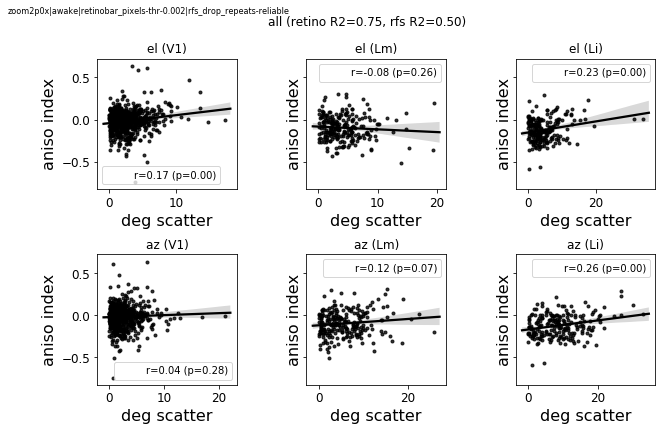

In [158]:
fig, axn = pl.subplots(2, 3, sharex=False, sharey=True, figsize=(10,6))

for ai, ((visual_area, cond), d_) in enumerate(scatdf.groupby(['axis', 'visual_area'])):
    ax = axn.flat[5-ai]
    
    xv =d_['deg_scatter']
    yv = d_['aniso_index']
    #ax.scatter(xv, yv, marker='.', s=2, c='k', label=None)
    sns.regplot(xv, yv, marker='.', ax=ax, color='k') # s=2)
    ax.set_ylabel('aniso index')
    ax.set_xlabel('deg scatter')
    
    ax.set_title('%s (%s)' % (visual_area, cond))
    
    pearsonr, pearsonp = spstats.pearsonr(xv, yv)
    ax.plot(0, 0, alpha=0, label='r=%.2f (p=%.2f)' % (pearsonr, pearsonp))
    ax.legend()

# xmin, xmax = ax.get_xlim()
# for ax in axn.flat:
#     ax.set_xlim([0, xmax])
pl.subplots_adjust(wspace=0.5, hspace=0.5)
label_figure(fig, data_id)
pl.suptitle('%s (retino R2=%.2f, rfs R2=%.2f)' % (rfname, retino_r2_thr, rf_r2_thr))

pl.savefig(os.path.join(basedir, 'drop_repeats', '%s__aniso_v_scatter.svg' % prefix))

In [123]:
basedir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter'

0.75


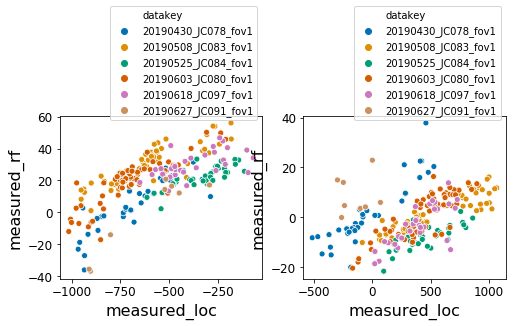

In [167]:
print(retino_r2_thr)
plotdf = scatdf[scatdf['retino_R2']>retino_r2_thr].copy()
sns.set_palette('colorblind')
fig, axn = pl.subplots(1,2, figsize=(8,3))
visual_area = 'Lm'

vdf = plotdf[plotdf['visual_area']==visual_area]

for ax, (cond, vdf_ax) in zip(axn.flat, vdf.groupby(['axis'])):

    sns.scatterplot(x='measured_loc', y='measured_rf', data=vdf_ax, ax=ax,
                    hue='datakey')
    
    ax.legend(bbox_to_anchor=(1., 1.7))

# Plot Deg/Dist (color by RF exp)

In [168]:
mean_scatter = scatdf.groupby(['visual_area', 'datakey', 'axis', 'rfname']).mean().reset_index()
mean_scatter['animalid'] = [s.split('_')[1] for s in mean_scatter['datakey']]
mean_scatter['session'] = [s.split('_')[0] for s in mean_scatter['datakey']]
mean_scatter['fov'] = [s.split('_')[2] for s in mean_scatter['datakey']]
print(mean_scatter.shape)

scatterdf_cells_counts = scatdf[['visual_area', 'datakey', 'animalid', 'session', 'fovnum', 'cell']].drop_duplicates()

(40, 35)


('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter', 'all_filter-drop_repeats__scatter_avg-by-fov__avg-rfs')


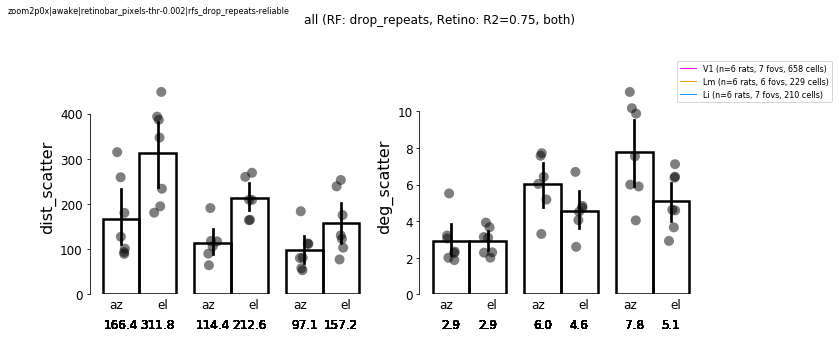

In [257]:
plot_cells=False


rfs_and_rfs10 = len(mean_scatter['rfname'].unique())>1
plot_str = '' if plot_cells else 'fovmeans'
rf_str = 'rfs5-v-rfs10' if rfs_and_rfs10 else 'avg-rfs'

rfcolors = ['orange', 'b'] if rfs_and_rfs10 else ['k', 'k']
rfnames = ['rfs', 'rfs10'] if rfs_and_rfs10 else ['avg_rfs']

fig, axn = pl.subplots(1,2, figsize=(12,5))
for ax, plotter in zip(axn.flat, ['dist_scatter', 'deg_scatter']):

    sns.barplot("visual_area", plotter, data=mean_scatter, ax=ax,
               hue='axis', order=visual_areas, errcolor="k",
               edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
    change_width(ax, .4)
    
    # plot fov means (color by rfs or rfs10)
    if rfs_and_rfs10:
        sns.stripplot(x='visual_area', y=plotter, hue='axis', data=mean_scatter[mean_scatter['rfname']=='rfs'], 
                      dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0],
                     palette={'el': rfcolors[0], 'az': rfcolors[0]}, alpha=0.5, order=['V1', 'Lm', 'Li'])
        sns.stripplot(x='visual_area', y=plotter, hue='axis', data=mean_scatter[mean_scatter['rfname']=='rfs10'], 
                      dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0],
                     palette={'el': rfcolors[1], 'az': rfcolors[1]}, alpha=0.5, order=['V1', 'Lm', 'Li'])

    else:
        sns.stripplot(x='visual_area', y=plotter, hue='axis', data=mean_scatter, 
                  dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0],
                 palette={'el': rfcolors[0], 'az': rfcolors[1]}, alpha=0.5, order=['V1', 'Lm', 'Li'])

    ax.legend_.remove()

    mean_scatter.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fmt='%.1f', fontcolor='k', xytext=(0, -30))
    aggr.set_split_xlabels(ax, a_label='az', b_label='el')

if rfs_and_rfs10:
    lines = [Line2D([0], [0], color=c, linewidth=0, marker='o') for c in rfcolors]
    ax.legend(lines, rfnames)
else:
    legend_elements = aggr.get_counts_for_legend(scatterdf_cells_counts, 
                                                 area_colors=area_colors,
                                                markersize=10, marker='_')
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.5,1.1), fontsize=8)

sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)

pl.subplots_adjust(wspace=0.2, left=0.1, right=0.8, bottom=0.2, top=0.8)  
fig.suptitle('%s (RF: %s, Retino: R2=%.2f, %s)' % (rfname, rf_filter_by, retino_r2_thr, retino_pass_crit))

label_figure(fig, data_id)
figname = '%s__scatter_avg-by-fov__%s' % (prefix, rf_str)
pl.savefig(os.path.join(basedir, 'drop_repeats', '%s.svg' % figname))
print(basedir, figname)

## Plot deg/dist separately for RFs and RF10

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/scatter', 'all_filter-None__scatter_avg-by-fov_split-rf5-rf10')


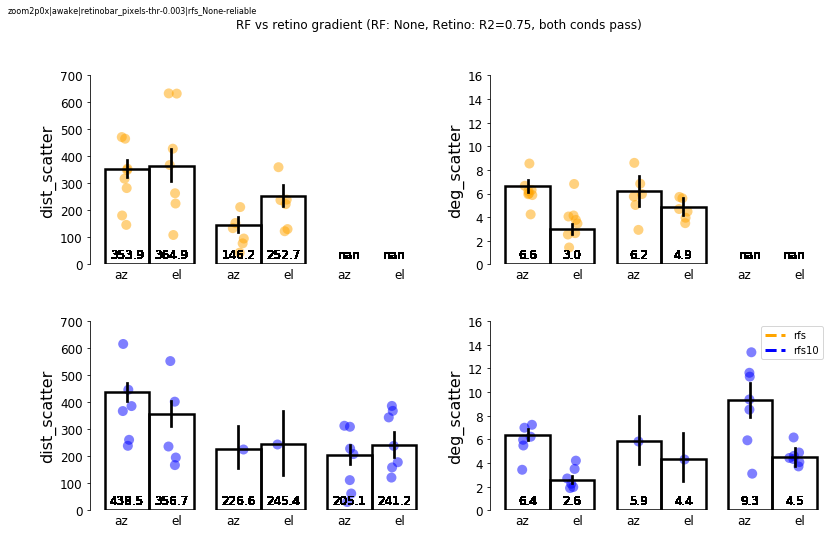

In [368]:
fig, axn = pl.subplots(2,2, figsize=(12,8))
for ai, plotter in enumerate( ['dist_scatter', 'deg_scatter']):
    for ci, (currcolor, currname) in enumerate(zip(rfcolors, rfnames)):
        ax = axn[ci, ai]
        
        axdf = scatdf[scatdf['rfname']==currname].copy()
        meandf = axdf.groupby(['visual_area', 'datakey', 'axis']).mean().reset_index()

        sns.barplot("visual_area", plotter, data=axdf, ax=ax,
                   hue='axis', order=visual_areas, errcolor="k",
                   edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
        change_width(ax, .4)

        sns.stripplot(x='visual_area', y=plotter, hue='axis', data=meandf, #mean_scatter[mean_scatter['rfname']==currname], 
                      dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0],
                     palette={'el': currcolor, 'az': currcolor}, alpha=0.5, order=['V1', 'Lm', 'Li'])
        ax.legend_.remove()
        axdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fmt='%.1f') # xytext=(0, -20))
        aggr.set_split_xlabels(ax, a_label='az', b_label='el')
        if ai==0:
            ax.set_ylim([0, 700])
        else:
            ax.set_ylim([0, 16])

lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in rfcolors]
ax.legend(lines, rfnames)

sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
fig.suptitle('RF vs retino gradient (RF: %s, Retino: R2=%.2f, %s conds pass)' % (rf_filter_by, retino_r2_thr, retino_pass_crit))

label_figure(fig, data_id)
pl.subplots_adjust(wspace=0.2, hspace=0.3, left=0.1, right=0.95)  

figname = '%s__scatter_avg-by-fov_split-rf5-rf10' % (prefix)
pl.savefig(os.path.join(basedir, '%s.svg' % figname))
print(basedir, figname)

## Compare where both RFs + RFs10 collected

(16, 38)
V1: (t-stat:1.37, p=0.26)
Lm: (t-stat:nan, p=nan)
Li: (t-stat:nan, p=nan)
V1: (t-stat:1.38, p=0.26)
Lm: (t-stat:nan, p=nan)
Li: (t-stat:nan, p=nan)
V1: (t-stat:1.12, p=0.34)
Lm: (t-stat:nan, p=nan)
Li: (t-stat:nan, p=nan)
V1: (t-stat:0.81, p=0.48)
Lm: (t-stat:nan, p=nan)
Li: (t-stat:nan, p=nan)


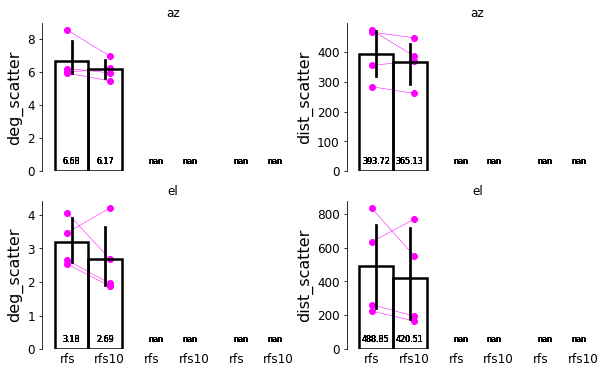

In [369]:
if rfname!='mixed':

    bothrfs = pd.concat([g for v, g in scatdf.groupby(['visual_area', 'datakey']) \
                                 if 'rfs' in g['rfname'].values and 'rfs10' in g['rfname'].values])

    meanboth = bothrfs.groupby(['visual_area', 'datakey', 'rfname', 'axis']).mean().reset_index().sort_values(by='datakey')
    meanboth['animalid'] = [s.split('_')[1] for s in meanboth['datakey']]
    meanboth['session'] = [s.split('_')[0] for s in meanboth['datakey']]
    meanboth['fov'] = [s.split('_')[2] for s in meanboth['datakey']]
    print(meanboth.shape)

    c1='rfs'
    c2='rfs10'
    # fig = plot_pairwise_by_axis(meanboth[meanboth['axis']=='az'], curr_metric='deg_scatter', compare_var='rfname',
    #                             c1='rfs', c2='rfs10', legend=0, 
    #                            area_colors=area_colors, fontsize=6, fontcolor='k')
    fig, axn = pl.subplots(2,2, figsize=(10,6), sharex=True, sharey=False)
    for ri, (axname, axdf) in enumerate(meanboth.groupby(['axis'])):
        ax = axn[ri, 0]
        ax.patch.set_alpha(0)
        ax = aggr.pairwise_compare_single_metric(axdf, curr_metric='deg_scatter', ax=ax,
                                                    c1=c1, c2=c2, compare_var='rfname')
        axdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fontcolor='k')

        # Set x labels
        rfutils.set_split_xlabels(ax, a_label=c1, b_label=c2)
        ax.set_title(axname)


        ax = axn[ri, 1]
        ax.patch.set_alpha(0)
        ax = aggr.pairwise_compare_single_metric(axdf, curr_metric='dist_scatter', ax=ax,
                                                    c1=c1, c2=c2, compare_var='rfname')
        axdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fontcolor='k')

        # Set x labels
        rfutils.set_split_xlabels(ax, a_label=c1, b_label=c2)
        ax.set_title(axname)

## Create joint distN of DEG/DIST scatter

In [258]:
scatterfov_dir = os.path.join(basedir, 'drop_repeats', 'example_scatter_by_fov')
if not os.path.exists(scatterfov_dir):
    os.makedirs(scatterfov_dir)
print(scatterfov_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/drop_repeats/example_scatter_by_fov


In [259]:
retino_r2_thr

0.75

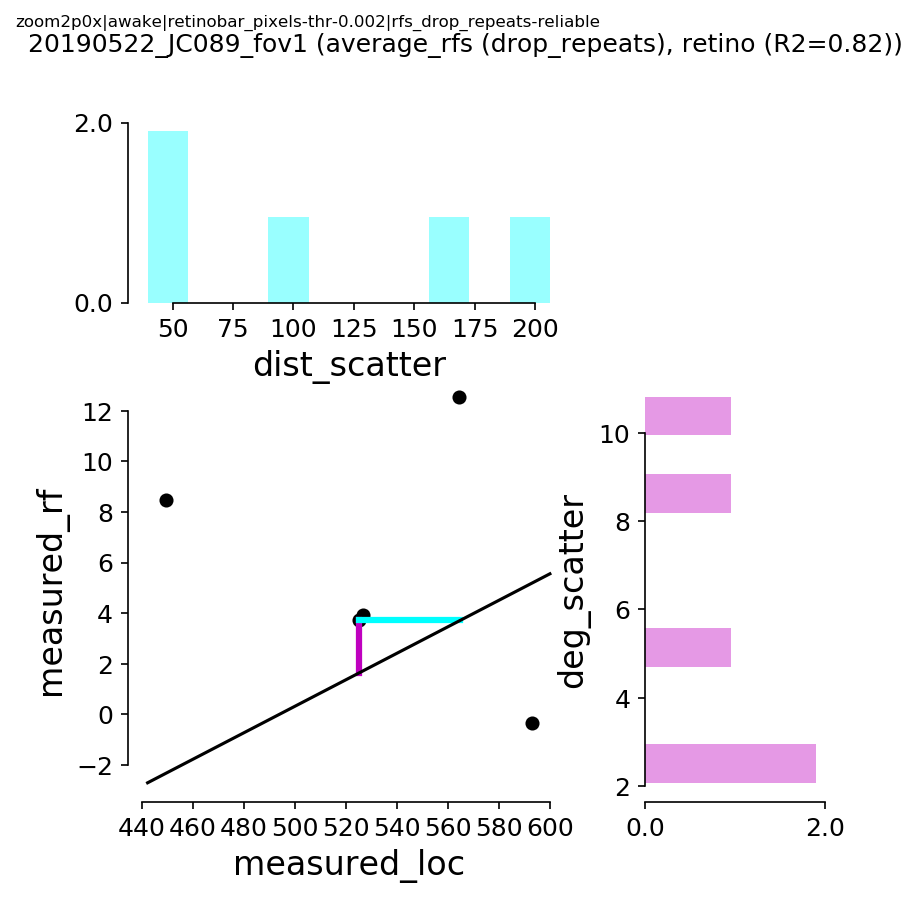

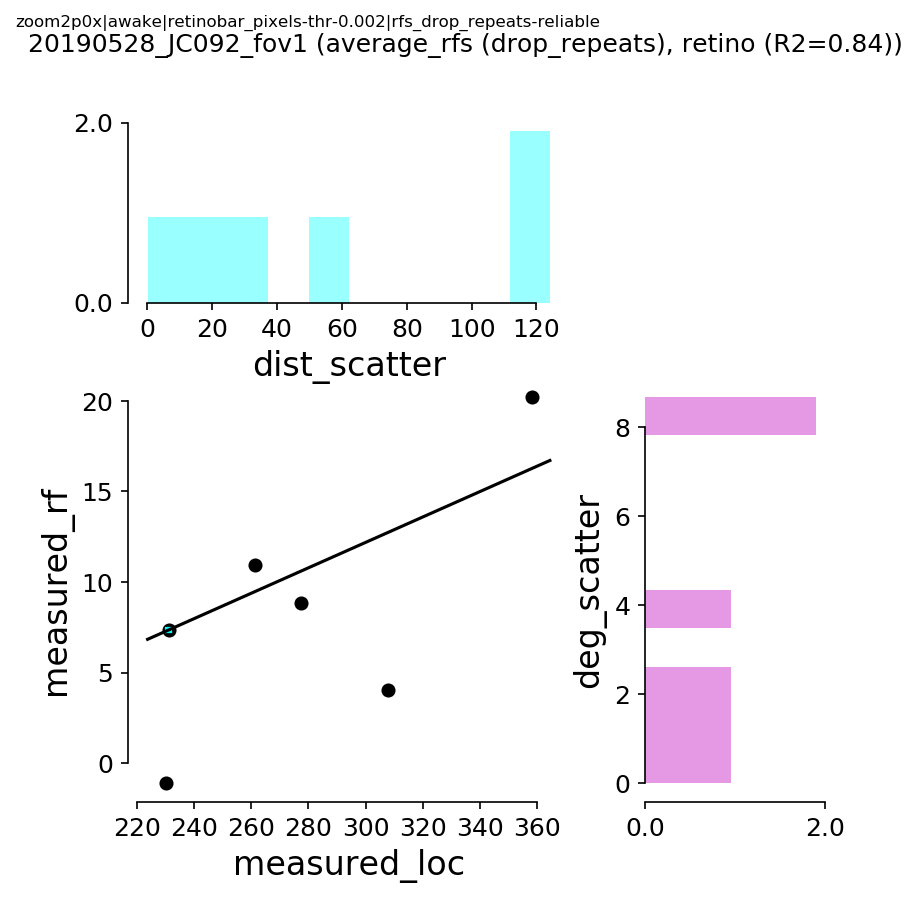

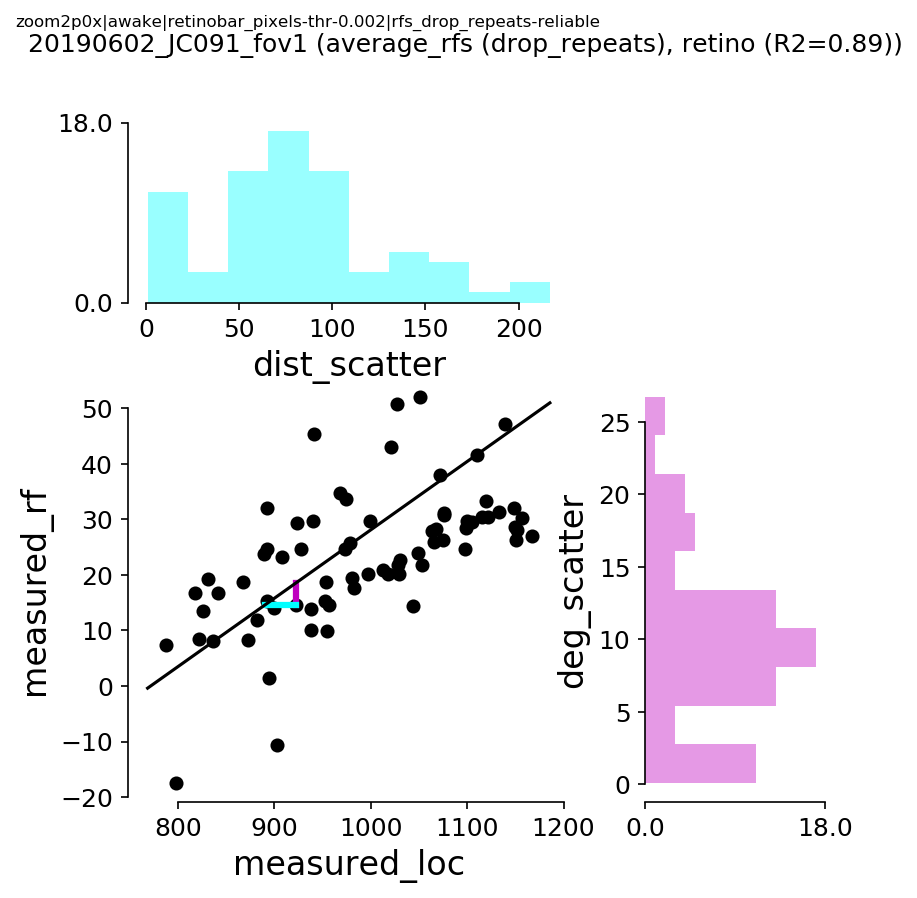

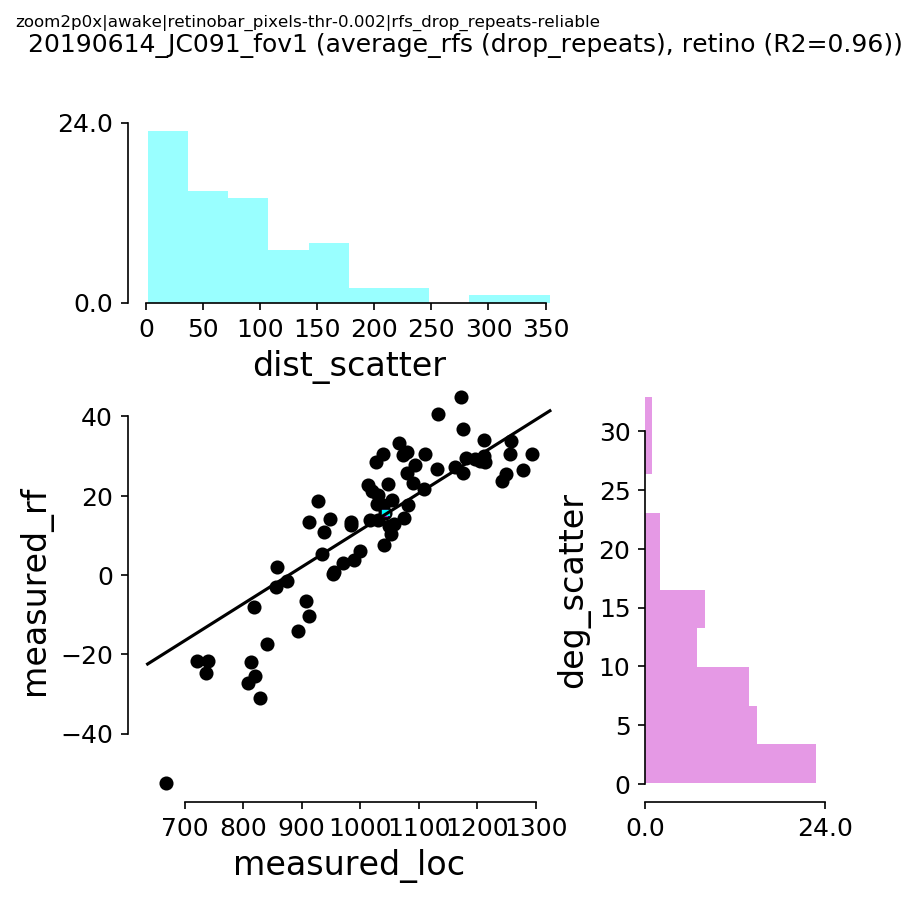

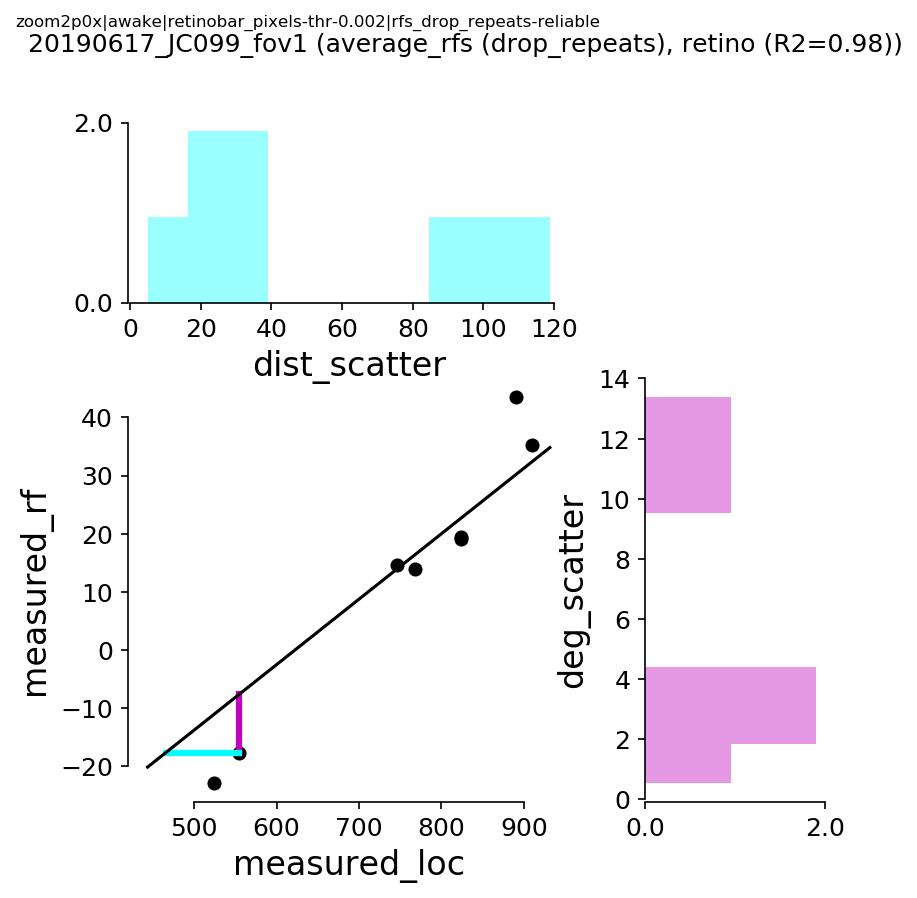

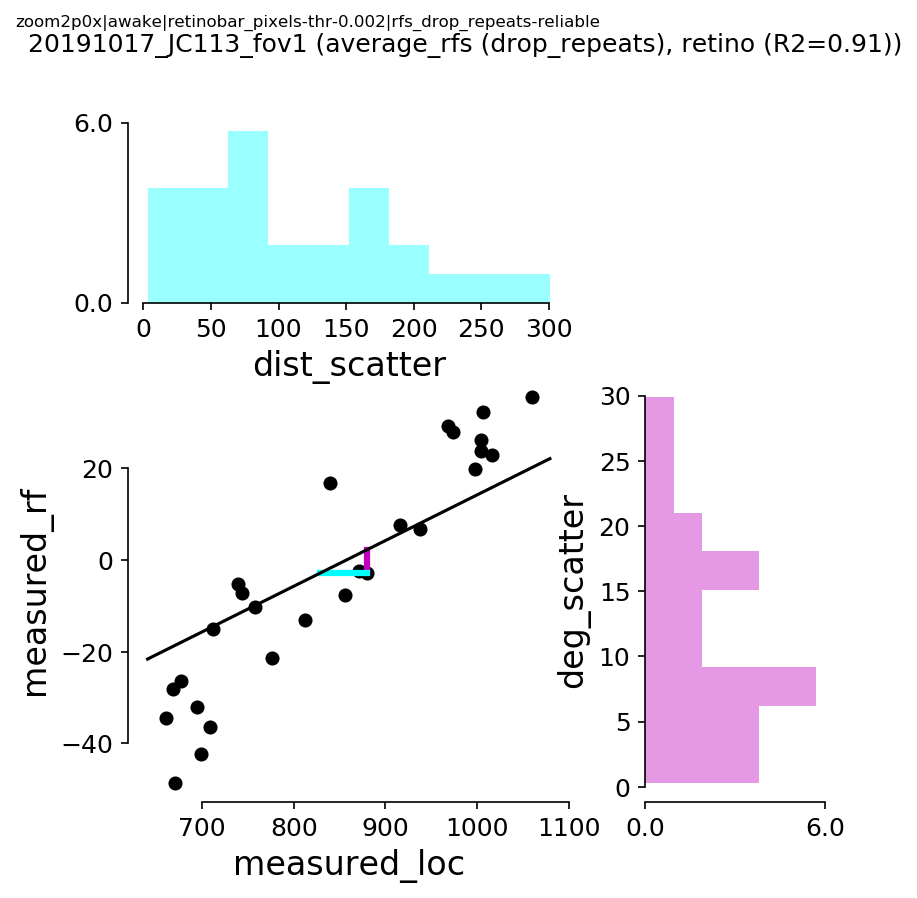

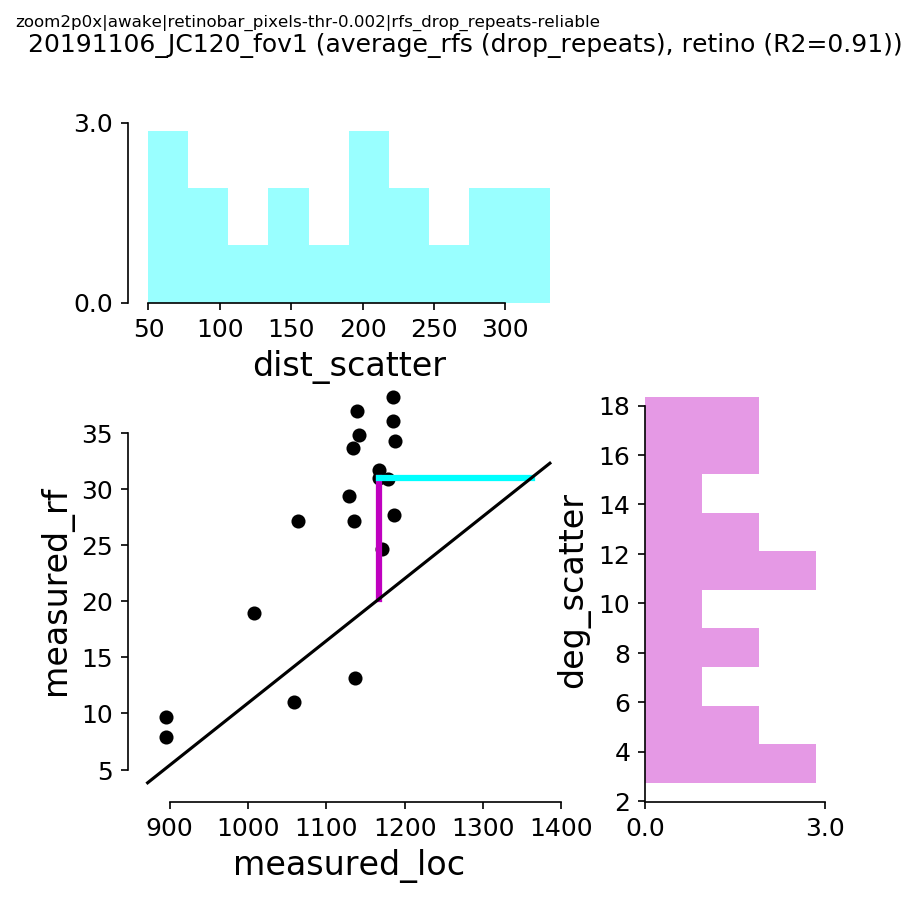

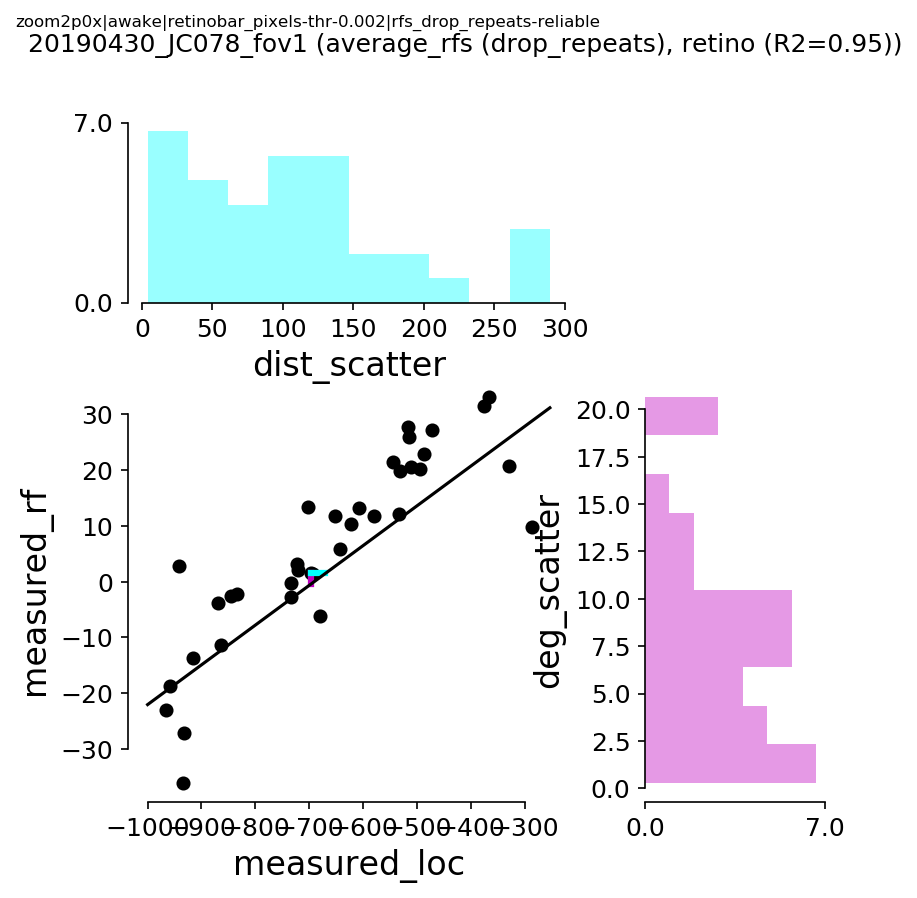

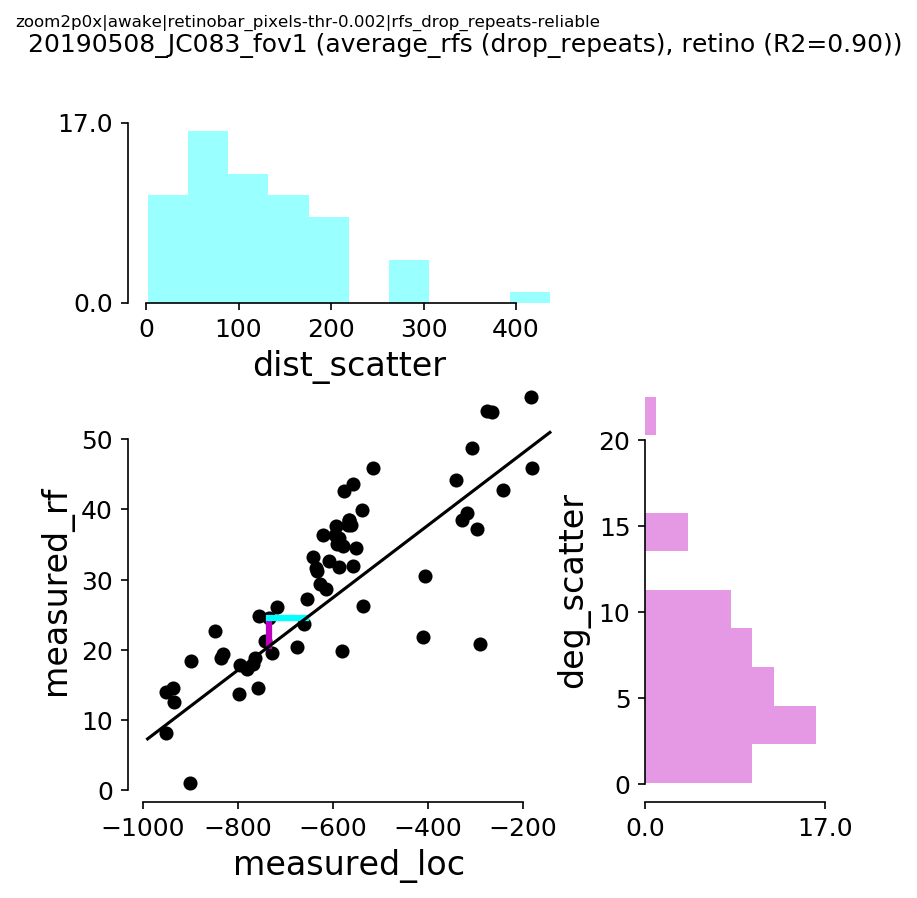

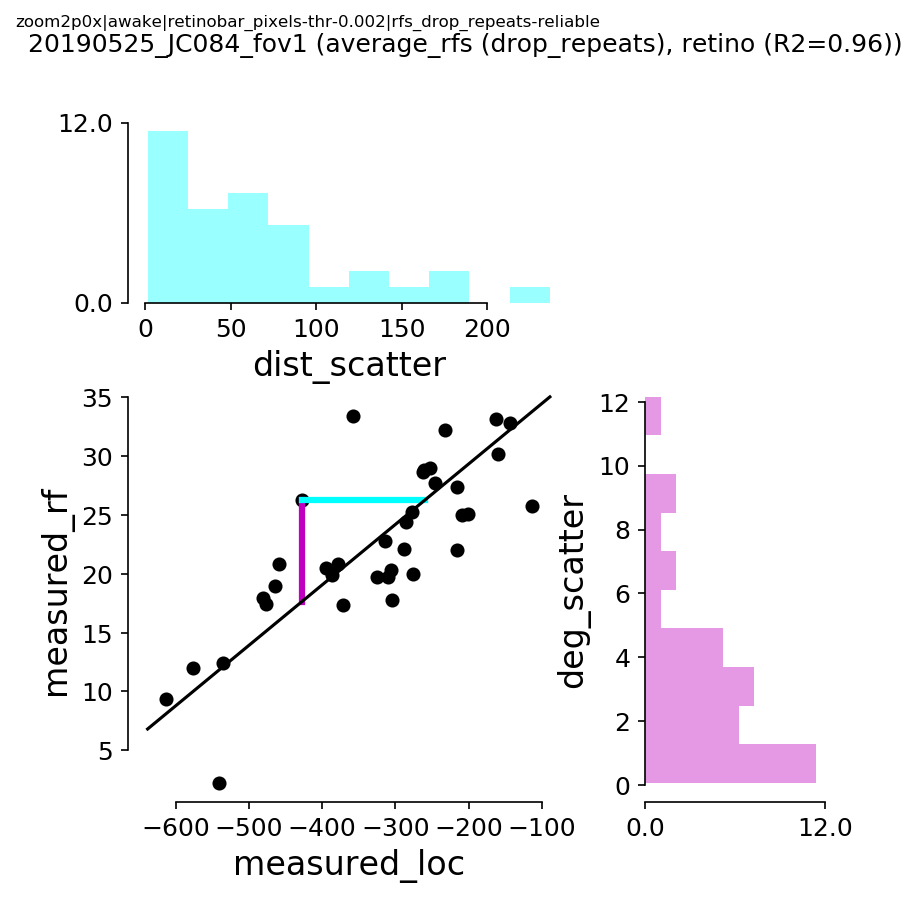

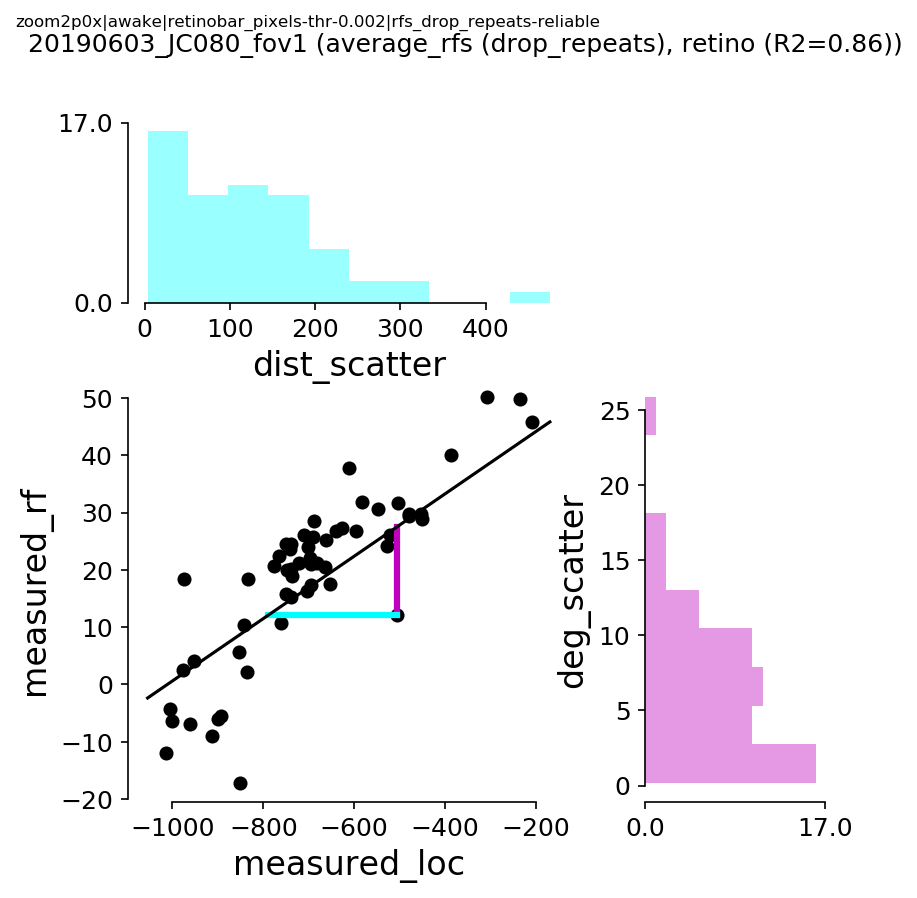

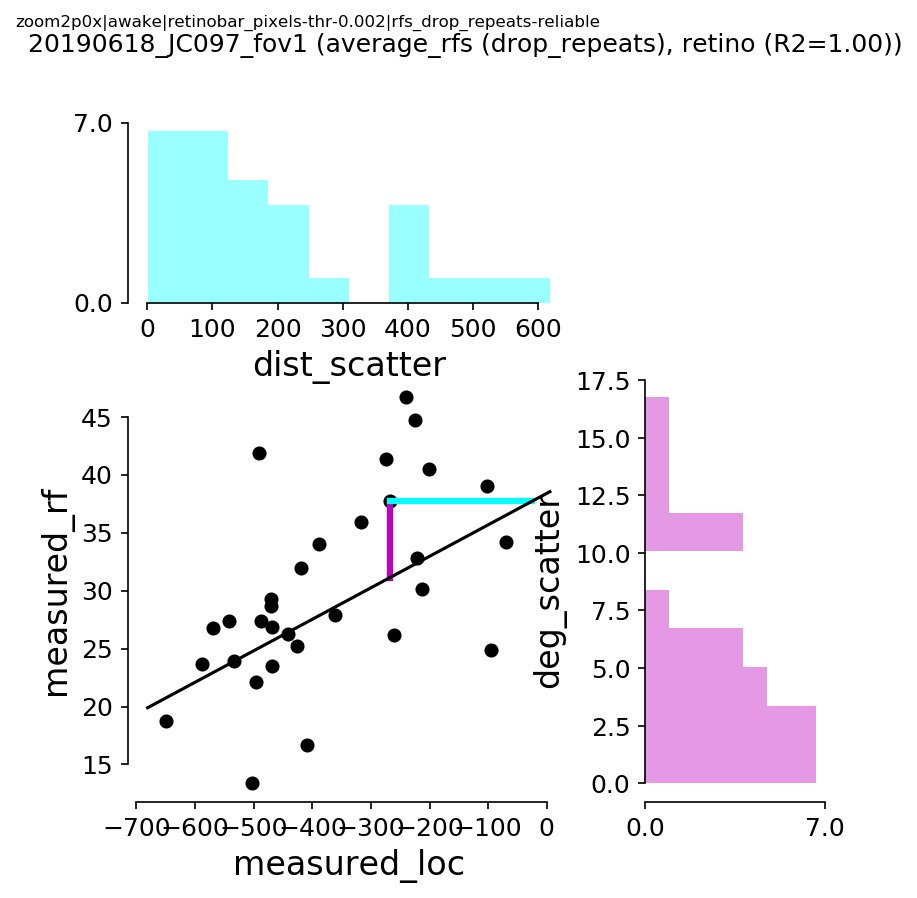

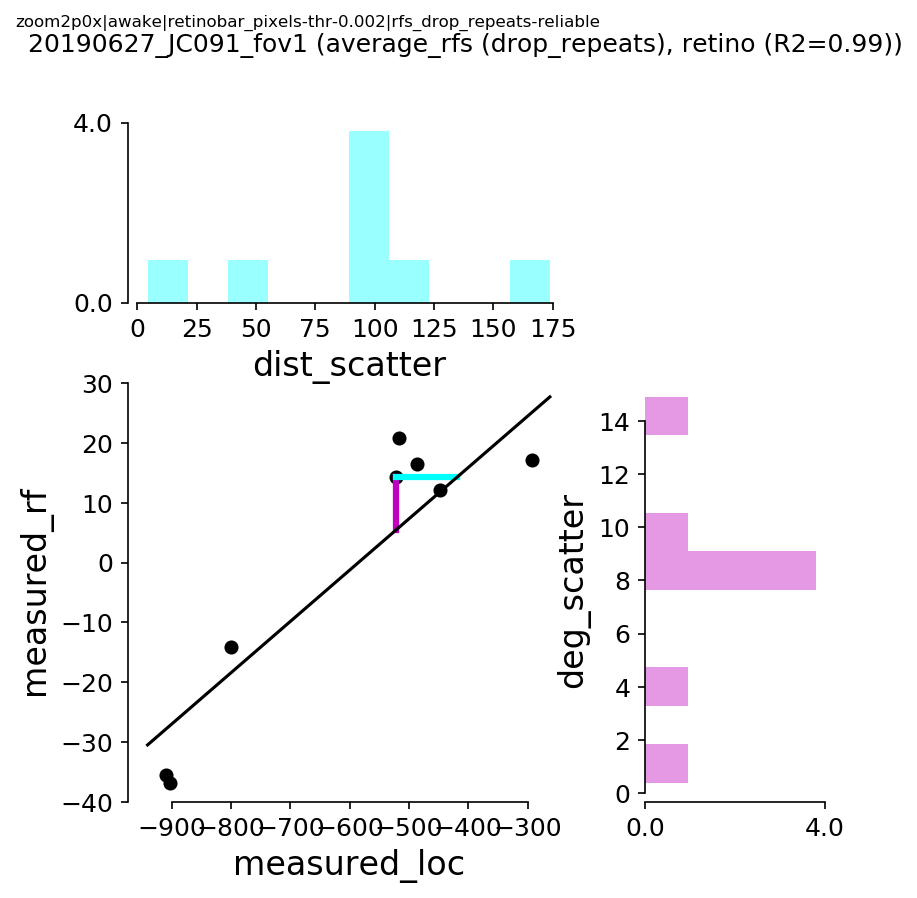

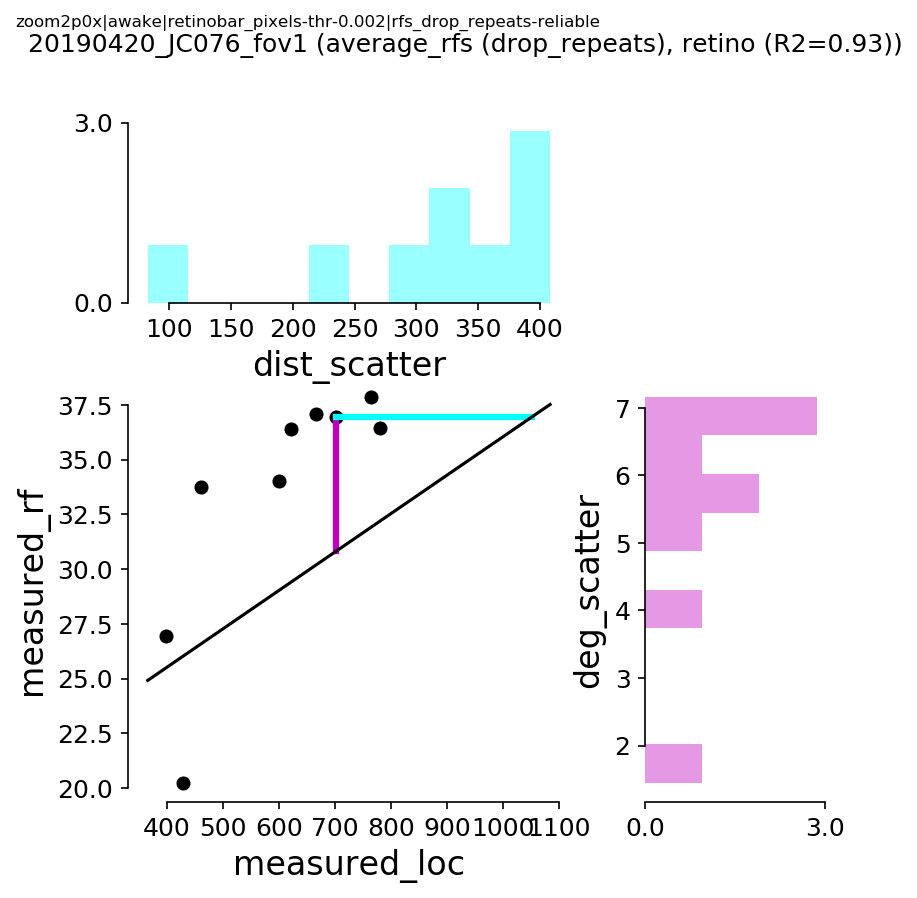

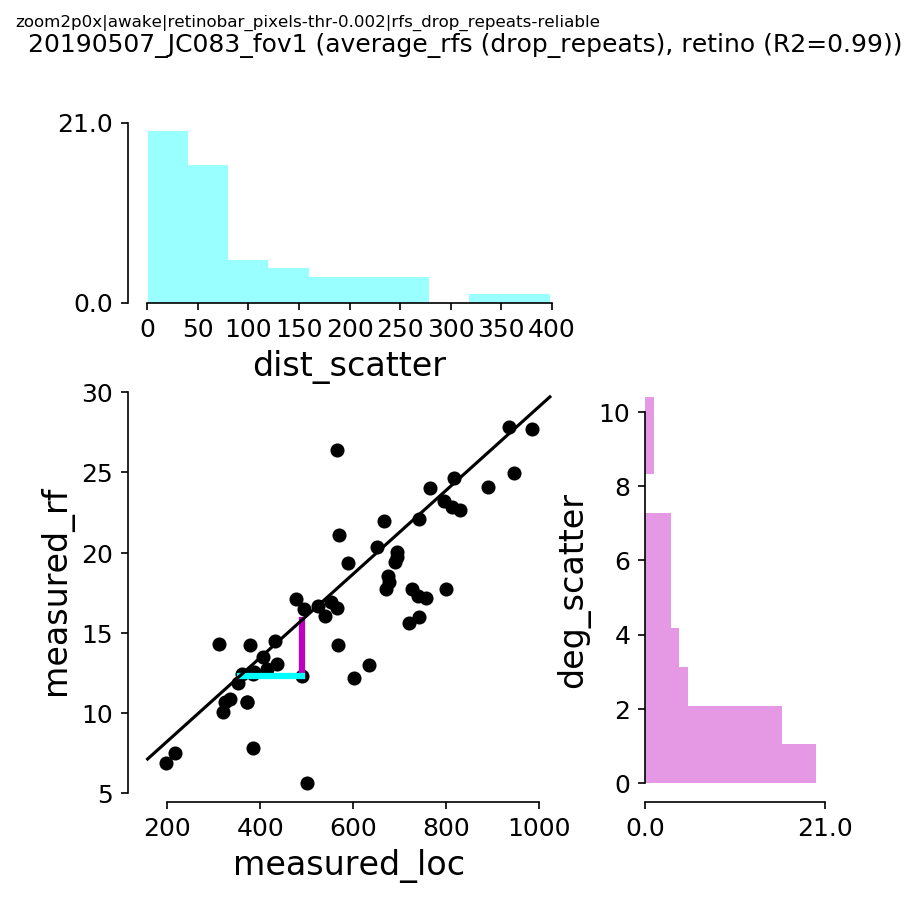

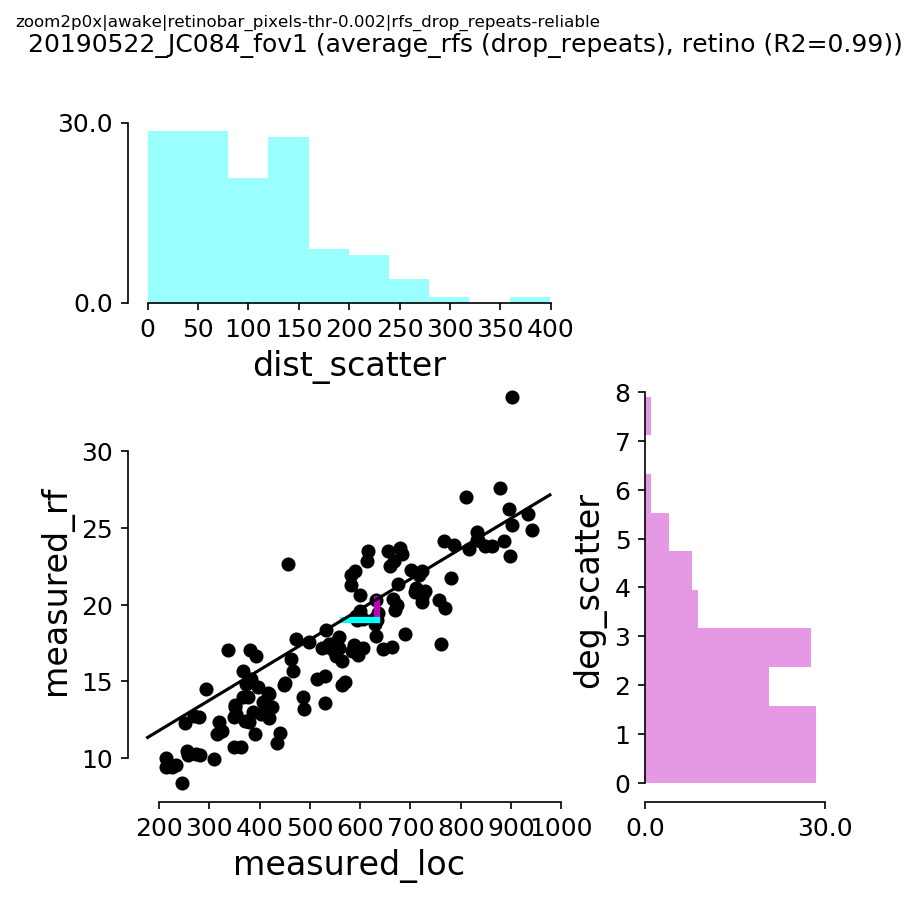

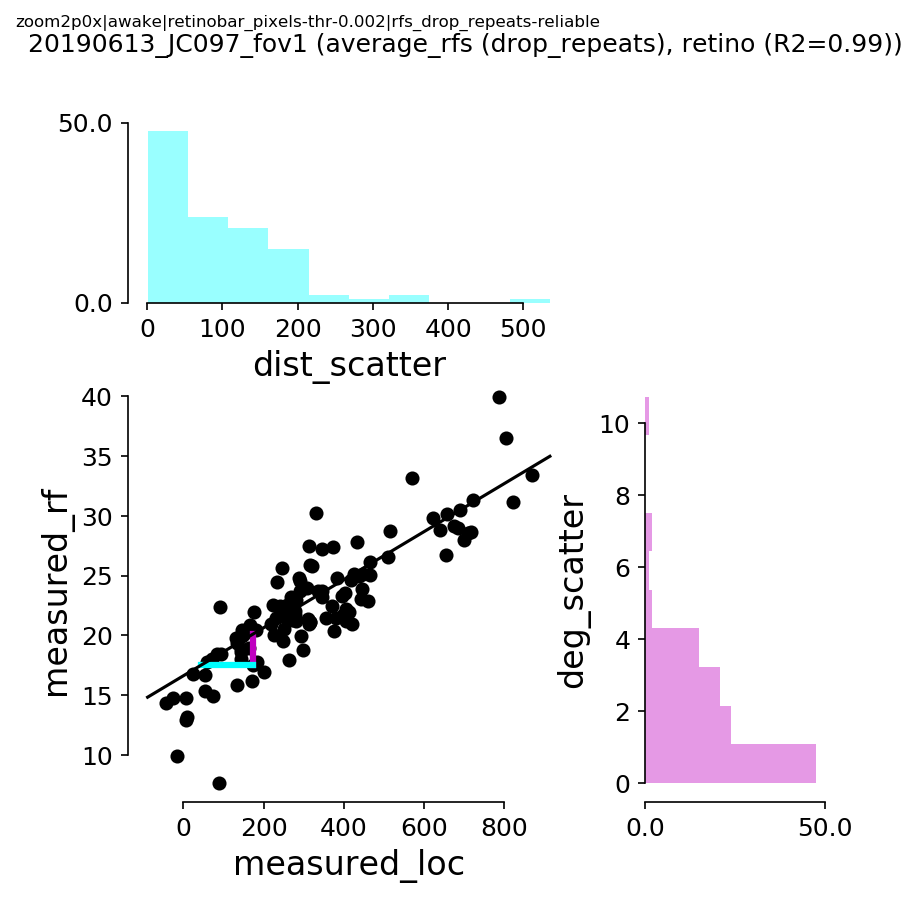

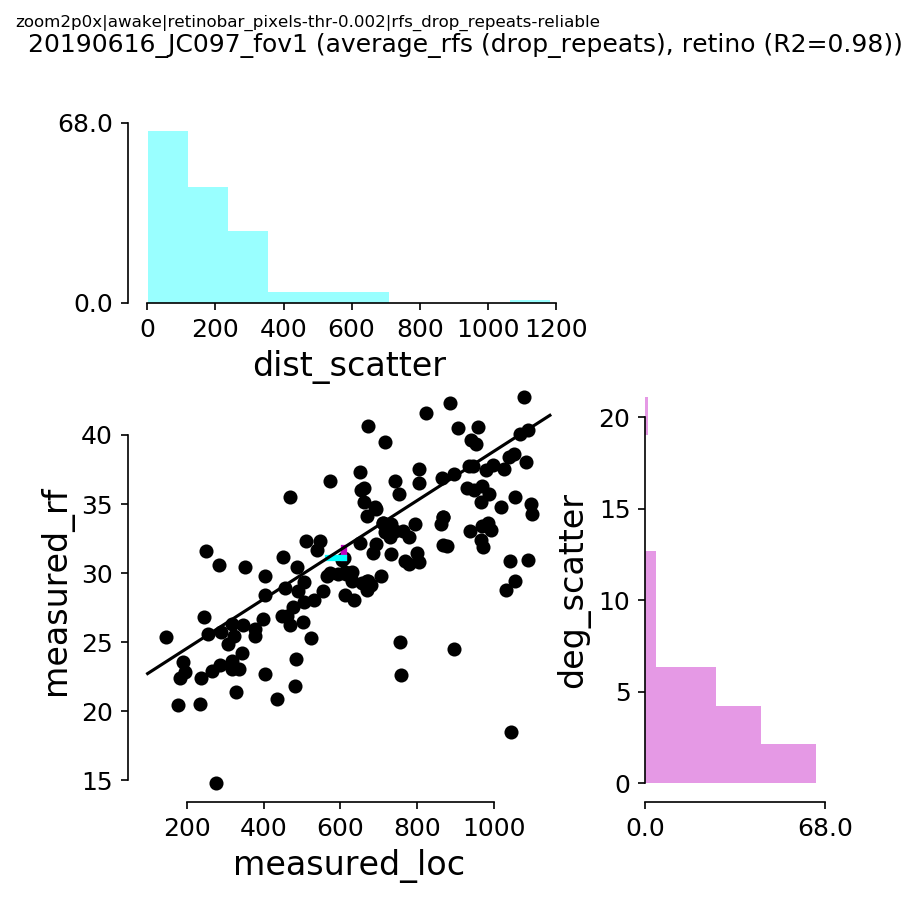

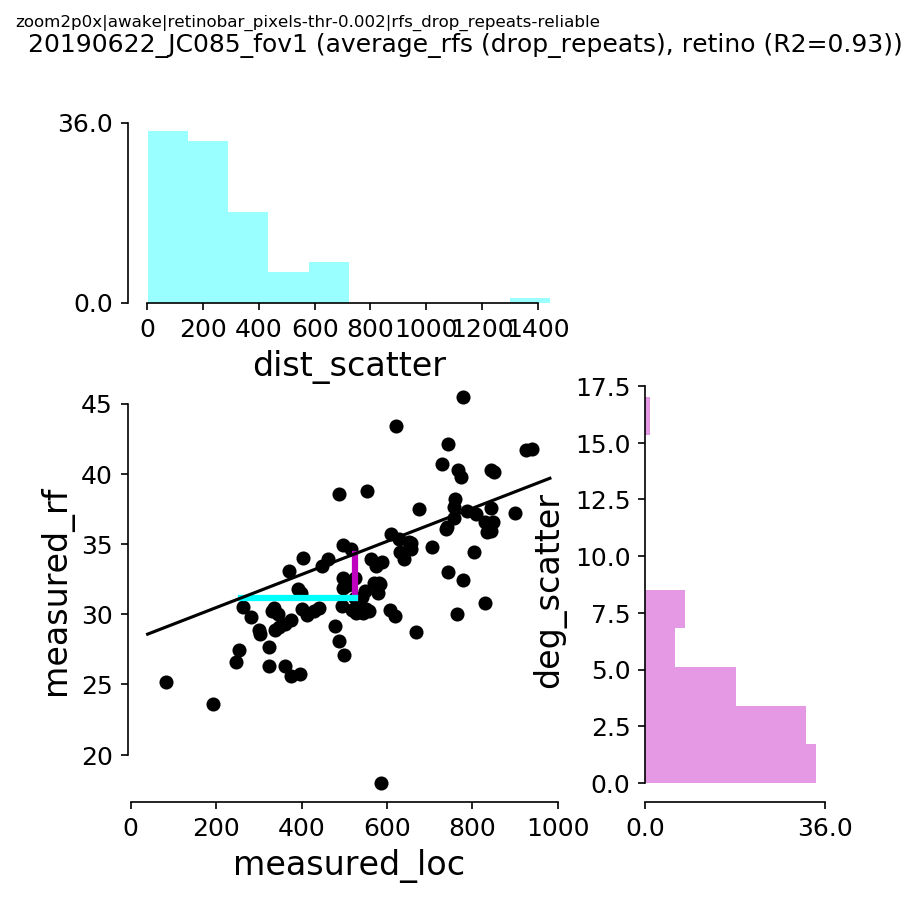

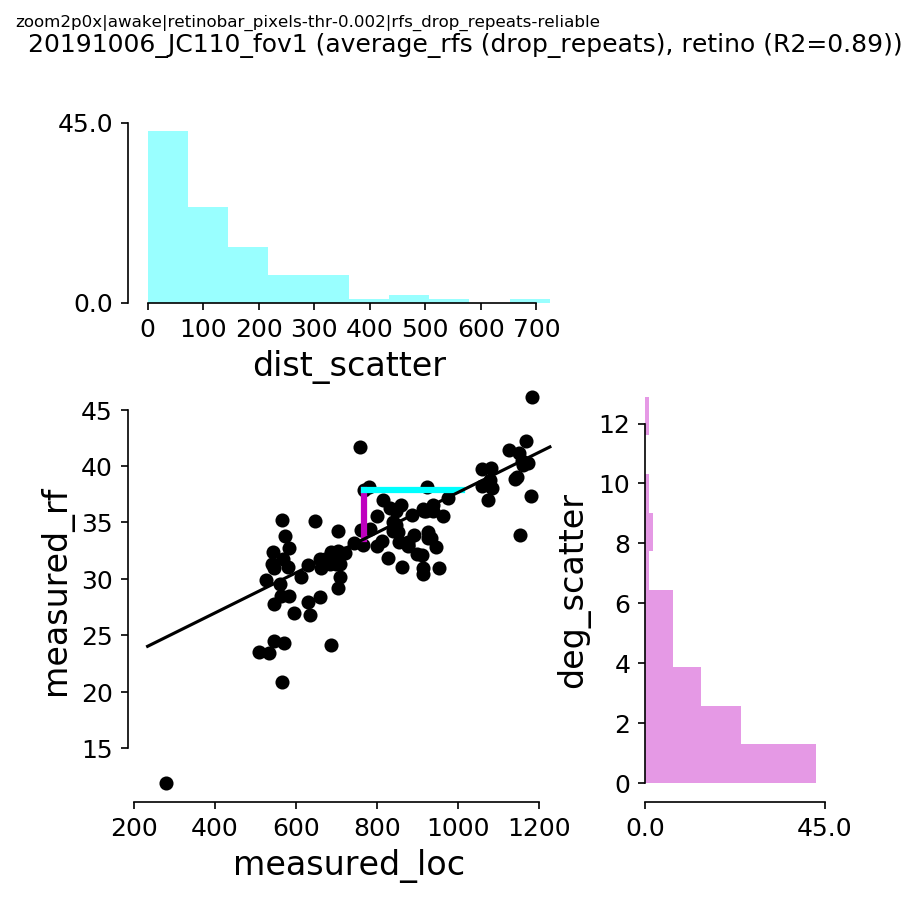

In [260]:
nbins=10
lw=3 
cond='az'

for (visual_area, datakey, experiment), rf_  in scatdf.groupby(['visual_area', 'datakey', 'rfname']):

    ret_ = projdf[projdf['datakey']==datakey]

    fig, scatterax = pl.subplots(figsize=(6,6), dpi=dpi)
    
    # Do scatter plot
    axdf = rf_[rf_['axis']==cond]
    sns.scatterplot(x='measured_loc', y='measured_rf', data=axdf, ax=scatterax,
                    color='k', edgecolor='k')
    slope = float(ret_[ret_['cond']==cond]['coefficient'])
    intercept = float(ret_[ret_['cond']==cond]['intercept'])
    r2_v = float(ret_[ret_['cond']==cond]['R2'])
    label_prefix='%s, R2=%.2f' % (retinorun.split('_')[1], r2_v)
    ls = '-' if r2_v > retino_r2_thr else ':'
    
    # Plot Vert/Horz lines showing deg_scatter or dist_scatter
    npts = axdf.shape[0]
    #if npts>20:
    pt_ixs = [int(npts/2.)] #np.arange(0, npts, 10)
    for ii, (xi, yi) in enumerate(axdf[['measured_loc', 'measured_rf']].values):
        if ii not in pt_ixs:
            continue
        # Do DEG scatter
        pred_deg = axdf['predicted_rf'].iloc[ii]
        offset_deg = axdf['deg_scatter'].iloc[ii]*-1 if yi>pred_deg else axdf['deg_scatter'].iloc[ii]
        scatterax.plot([xi,xi], [yi, yi+offset_deg], 'm', alpha=1, lw=lw)
        # Do DIST scatter
        pred_dist = axdf['predicted_loc'].iloc[ii]
        offset_dist = axdf['dist_scatter'].iloc[ii]*-1 if xi>pred_dist else axdf['dist_scatter'].iloc[ii]    
        scatterax.plot([xi, xi+offset_dist], [yi, yi], 'cyan', alpha=1, lw=lw)
    # Draw regr line
    scatterax = abline(slope, intercept, ax=scatterax, ls=ls, 
                       color='k', label=False, label_prefix=label_prefix)

    # Create top/right histograms
    divider = make_axes_locatable(scatterax)
    histax_x = divider.append_axes("top", 1.2, pad=0.5, sharex=None) #scatterax) #None)
    histax_y = divider.append_axes("right", 1.2, pad=0.5, sharey=None) #scatterax)

    sns.distplot(axdf['dist_scatter'], color='cyan', ax=histax_x, kde=False, bins=nbins)
    histax_x.tick_params(labelright=False, labelleft=True, 
                        bottom=True, labelbottom=True, top=False, labeltop=False)
    xlim, ylim=histax_x.get_ylim()
    histax_x.set_yticks([xlim, ylim])
    histax_x.set_yticklabels([round(xlim), round(ylim)])
    histax_x.spines["right"].set_visible(False)
    histax_x.spines["left"].set_visible(True)
    histax_x.spines["top"].set_visible(False)
    histax_x.spines["bottom"].set_visible(True)

    sns.distplot(axdf['deg_scatter'], color='m', ax=histax_y, vertical=True, kde=False, bins=nbins)
    histax_y.tick_params(labelright=False, labelleft=True, 
                        bottom=True, labelbottom=True, top=False, labeltop=False)
    xlim, ylim=histax_y.get_xlim()
    histax_y.set_xticks([xlim, ylim])
    histax_y.set_xticklabels([round(xlim), round(ylim)])
    histax_y.spines["right"].set_visible(False)
    histax_y.spines["left"].set_visible(True)
    histax_y.spines["top"].set_visible(False)
    histax_y.spines["bottom"].set_visible(True)

    sns.despine(trim=True)
    pl.suptitle('%s (%s (%s), retino (R2=%.2f))' % (datakey, experiment, rf_filter_by, r2_v))

    label_figure(fig, data_id)

    figname = '%s_%s_%s_deg_v_dist_scatter' % (experiment, visual_area, datakey)
    pl.savefig(os.path.join(scatterfov_dir,'%s.svg' % figname))
    #print(scatterfov_dir, figname)

In [375]:
rfname

'all'

# Size distn of included datasets

In [267]:
scatter_datakeys = scatdf['datakey'].unique()
curr_rfs = rfdf[rfdf['datakey'].isin(scatter_datakeys)].copy()

********* [average_rfs|median std_avg] *********
[('V1', 'Lm')] p=0.000 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.000 (fdr_bh), reject H0=True
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter', 'all_filter-drop_repeats__avg-size_multicomp-fdr_bh')


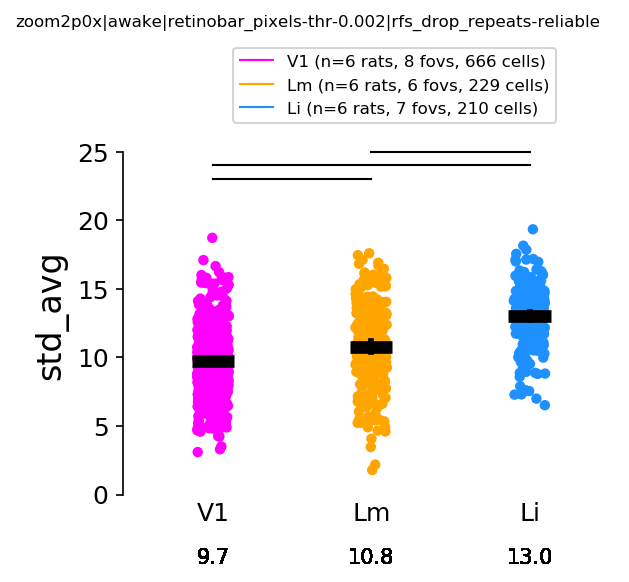

In [281]:
curr_metric = 'std_avg'
multi_comp_test = 'fdr_bh' #'holm'
mean_metric = 'median' # median
fov_means = False

fig, ax = pl.subplots(1, figsize=(5,4), dpi=dpi, sharex=True, sharey=True)
fig.patch.set_alpha(0)

ax.patch.set_alpha(0)

# Average RF sizes for each FOV
grped = curr_rfs.groupby(['visual_area', groupby])
mean_sizes = grped.median().reset_index() if mean_metric=='median' else grped.mean().reset_index()

# Plot means
sns.barplot(x="visual_area", y=curr_metric, data=curr_rfs, 
            ax=ax, order=visual_areas, ci=95,
            errcolor='none', edgecolor='none', 
            facecolor=(1,1,1,0), linewidth=2.5)

sns.pointplot(x="visual_area", y=curr_metric, data=curr_rfs, 
                ax=ax, order=visual_areas, ci=95,
                markers='_', join=False, capsize=0., dodge=True,
                scale=3, color='k')

# Plot points
plotdf = mean_sizes if fov_means else curr_rfs
point_size = 10 if fov_means else 5
sns.stripplot(x='visual_area', y=curr_metric, data=plotdf, 
              zorder=-1, ax=ax, order=visual_areas, palette=area_colors,
              s=point_size, color=(1,1,1,0), dodge=True, #facecolor=(1,1,1,0),
              marker='o',linewidth=1, edgecolor='none')

expdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f', xytext=(0, -30))
#ax.set_title(experiment, loc='left', fontsize=16)

# Get counts of samples for legend
ax.set_yticks(np.arange(0, 30, step=5))
ax.set_xlabel(''); ax.tick_params(axis='x', size=0);
sns.despine(bottom=True, offset=2, trim=True)
ax.tick_params(which='both', axis='x', size=0)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(plotdf, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(0.2,1.01), fontsize=8)

        
# Annotate w stats
print("********* [%s|%s %s] *********" % (experiment, mean_metric, curr_metric))
y_loc = 16 if fov_means else 23
statresults = aggr.do_mannwhitney(plotdf, metric=curr_metric, multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax, y_loc=y_loc, offset=1)

pl.subplots_adjust(top=0.8, bottom=0.2, left=0.15, right=0.8)

putils.label_figure(fig, data_id)

figname = '%s__avg-size_multicomp-%s' % (prefix, multi_comp_test )
pl.savefig(os.path.join(basedir,  'drop_repeats', '%s.svg' % figname))
print(basedir, figname)

In [287]:
statresults

[(('V1', 'Lm'), True, 1.981541403007632e-07),
 (('V1', 'Li'), True, 2.8603667740584334e-50),
 (('Lm', 'Li'), True, 1.5510522042770892e-14)]

In [286]:
mean_sizes.groupby(['visual_area']).mean()['std_avg']

visual_area
Li    13.543873
Lm    10.595942
V1     9.605517
Name: std_avg, dtype: float64

#### compare rfs/rfs10

********* [average_rfs|median std_avg] *********
[('V1', 'Lm')] p=0.000 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.000 (fdr_bh), reject H0=True
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter', 'all_filter-drop_repeats__compare-size_rf5-v-rf10_multicomp-fdr_bh')


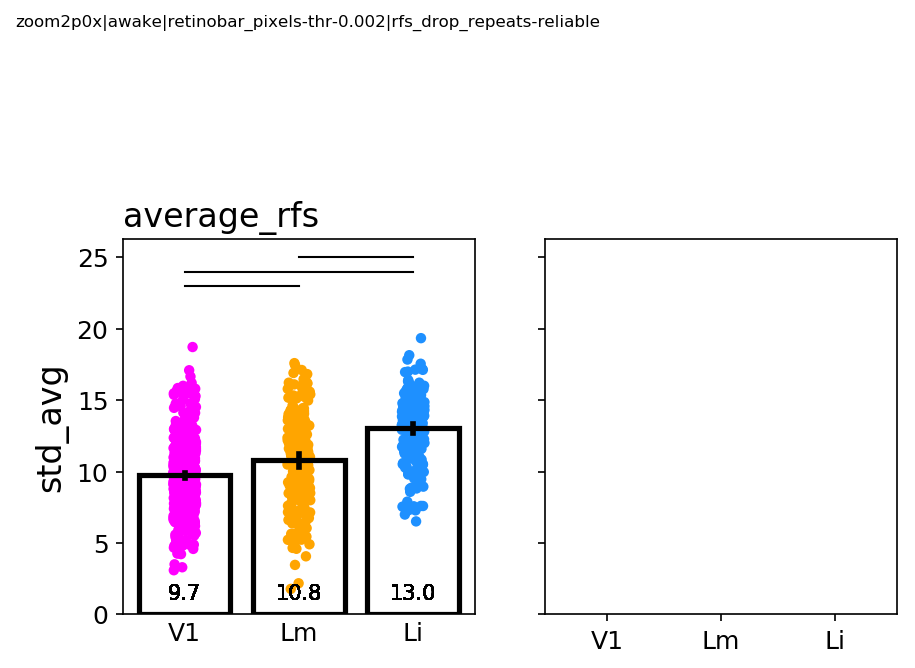

In [185]:
if rfname!='mixed' or len(curr_rfs['experiment'].unique())>1:
    groupby='datakey'
    curr_metric = 'std_avg'
    fov_means = False
    plot_bar = True

    multi_comp_test = 'fdr_bh' #'holm'
    mean_metric = 'median' # median

    fig, axn = pl.subplots(1, 2, figsize=(6,5), dpi=dpi, sharex=True, sharey=True)
    fig.patch.set_alpha(0)
    for ai, (ax, (experiment, expdf)) in enumerate(zip(axn.flat, curr_rfs.groupby(['experiment']))):
        ax.patch.set_alpha(0)

        # Average RF sizes for each FOV
        grped = expdf.groupby(['visual_area', groupby]) if groupby is not None else expdf.groupby(['visual_area'])
        mean_sizes = grped.median().reset_index() if mean_metric=='median' else grped.mean().reset_index()

        # Plot means
        if plot_bar:
            sns.barplot(x="visual_area", y=curr_metric, data=expdf, 
                        ax=ax, order=visual_areas, ci=95,
                        errcolor="k", edgecolor=('k', 'k', 'k'), 
                        facecolor=(1,1,1,0), linewidth=2.5)
        else:
            sns.pointplot(x="visual_area", y=curr_metric, data=expdf, 
                            ax=ax, order=visual_areas, ci=95,
                            markers='_', join=False, capsize=0., dodge=True,
                            scale=3, color='k')
        # Plot points
        plotdf = mean_sizes if fov_means else expdf
        point_size = 10 if fov_means else 5
        sns.stripplot(x='visual_area', y=curr_metric, data=plotdf, 
                      zorder=-1, ax=ax, order=visual_areas, palette=area_colors,
                      s=point_size, color=(1,1,1,0), dodge=True, #facecolor=(1,1,1,0),
                      marker='o',linewidth=1, edgecolor='none')

        expdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f')

        if ai>0:
            ax.set_ylabel('');
        ax.set_title(experiment, loc='left', fontsize=16)

        # Get counts of samples for legend
        ax.set_xlabel(''); ax.tick_params(axis='x', size=0);

        # Annotate w stats
        print("********* [%s|%s %s] *********" % (experiment, mean_metric, curr_metric))
        y_loc = 16 if fov_means else 23
        statresults = aggr.do_mannwhitney(plotdf, metric=curr_metric, multi_comp_test=multi_comp_test)
        aggr.annotate_stats_areas(statresults, ax, y_loc=y_loc, offset=1)

    pl.subplots_adjust(top=0.7, bottom=0.2, left=0.12, right=0.98)

    putils.label_figure(fig, data_id)

    figname = '%s__compare-size_rf5-v-rf10_multicomp-%s' % (prefix, multi_comp_test )
    pl.savefig(os.path.join(basedir,  'drop_repeats', '%s.svg' % figname))
    print(basedir, figname)

# Deg scatter vs. RF size

In [186]:
scatter_cond='avg'
sz_param = 'std_avg' # if scatter_cond=='az' else 'fy'

d_list=[]
for (visual_area, datakey, experiment), sg in scatdf.groupby(['visual_area', 'datakey', 'rfname']):
    ai = visual_areas.index(visual_area)
    #ax = axn[ai]

    el_scatter = sg[sg['axis']=='el'][['cell', 'deg_scatter']]
    az_scatter = sg[sg['axis']=='az'][['cell', 'deg_scatter']]
    common_cells = np.intersect1d(el_scatter['cell'].unique(), az_scatter['cell'].unique())
    d1 = sg[(sg['cell'].isin(common_cells)) & (sg['axis']=='el')][['cell', 'deg_scatter']].rename(columns={'deg_scatter': 'deg_scatter_el'})
    d2 = sg[(sg['cell'].isin(common_cells)) & (sg['axis']=='az')][['cell', 'deg_scatter']].rename(columns={'deg_scatter': 'deg_scatter_az'})

    curr_scatter = pd.merge(d1, d2) #, axis=1)
    curr_scatter['deg_scatter_mean'] = curr_scatter[['deg_scatter_el', 'deg_scatter_az']].mean(axis=1)

    rfs_ = rfdf[(rfdf['datakey']==datakey) 
                    & (rfdf['experiment']==experiment)
                    & (rfdf['cell'].isin(curr_scatter['cell'].unique()))].copy()    
    df_ = pd.merge(rfs_, curr_scatter)
    d_list.append(df_)
    
avg_scatter = pd.concat(d_list, axis=0)
avg_scatter['proj_size_avg'] = avg_scatter[['fx', 'fy']].mean(axis=1)
print(d_list[0].shape, avg_scatter.shape)

((5, 40), (1092, 41))


In [200]:
mean_scatter.groupby(['visual_area']).mean().reset_index()[['visual_area', 'deg_scatter', 'dist_scatter', 'std_avg']]

visual_area  deg_scatter  dist_scatter    std_avg
0          Li     6.452201    127.168395  13.256039
1          Lm     5.304397    163.478945  10.612712
2          V1     2.902860    239.088359   9.492923

In [204]:
mean_scatter.head()

visual_area              datakey axis       rfname        cell  deg_scatter  \
0          Li  20190522_JC089_fov1   az  average_rfs  122.200000     5.897486   
1          Li  20190522_JC089_fov1   el  average_rfs  122.200000     7.115349   
2          Li  20190528_JC092_fov1   az  average_rfs   95.666667     4.043366   
3          Li  20190528_JC092_fov1   el  average_rfs   95.666667     6.382995   
4          Li  20190602_JC091_fov1   az  average_rfs  118.208333     9.881364   

   dist_scatter  measured_rf  predicted_loc  retino_R2  ...    theta_c  \
0    112.450721     5.663060     601.878820   0.818767  ...   0.024189   
1    252.931433    13.282891     335.530172   0.891582  ...   0.024189   
2     57.803971     8.382304     245.746554   0.838448  ...  -0.117519   
3    238.897102   -14.931462     269.977302   0.872476  ...  -0.117519   
4     80.210875    23.438351     962.103004   0.888692  ...  -0.066571   

   theta_Mm_deg  major_axis  minor_axis  anisotropy  theta_Mm_c  aniso_index  \
0    163.385933   14.979046   12.323116    0.096026    0.338348     0.023416   
1    163.385933   14.979046   12.323116    0.096026    0.338348     0.023416   
2    188.266635   16.762782   10.143652    0.243155    0.144280    -0.138790   
3    188.266635   16.762782   10.143652    0.243155    0.144280    -0.138790   
4    141.185775   15.968648   10.549852    0.209687    0.020696    -0.098094   

   animalid   session   fov  
0     JC089  20190522  fov1  
1     JC089  20190522  fov1  
2     JC092  20190528  fov1  
3     JC092  20190528  fov1  
4     JC091  20190602  fov1  

[5 rows x 38 columns]

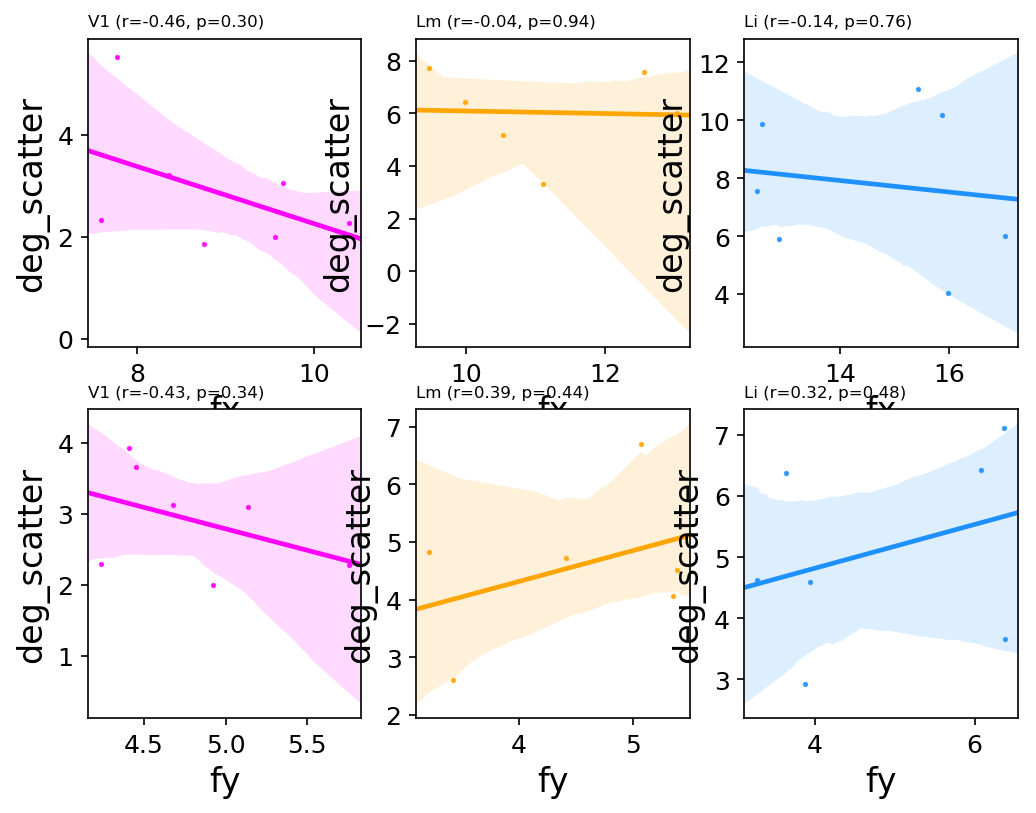

In [208]:
fig, axn = pl.subplots(2, 3, figsize=(8,6), dpi=dpi, sharey=False, sharex=False)
for ai, (visual_area, g) in enumerate(mean_scatter.groupby(['visual_area'])):
    az_scatter = g[g['axis']=='az']['deg_scatter']
    el_scatter = g[g['axis']=='el']['deg_scatter']
    
    az_sz = g[g['axis']=='az']['fx']
    el_sz = g[g['axis']=='el']['fy']
    
    ax=axn[0, 2-ai]
    sns.regplot(az_sz, az_scatter, color=area_colors[visual_area], data=g, ax=ax,
               marker='.', scatter_kws={'s':10})
    r, p = spstats.pearsonr(az_sz, az_scatter)
    ax.set_title('%s (r=%.2f, p=%.2f)' % (visual_area, r, p), loc='left', fontsize=8)
    
    ax=axn[1, 2-ai]
    sns.regplot(el_sz, el_scatter, color=area_colors[visual_area], data=g, ax=ax,
               marker='.', scatter_kws={'s':10})
    r, p = spstats.pearsonr(el_sz, el_scatter)
    ax.set_title('%s (r=%.2f, p=%.2f)' % (visual_area, r, p), loc='left', fontsize=8)
    

#### plot

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter', 'all_filter-drop_repeats__scatter_v_projsize-along-ax')


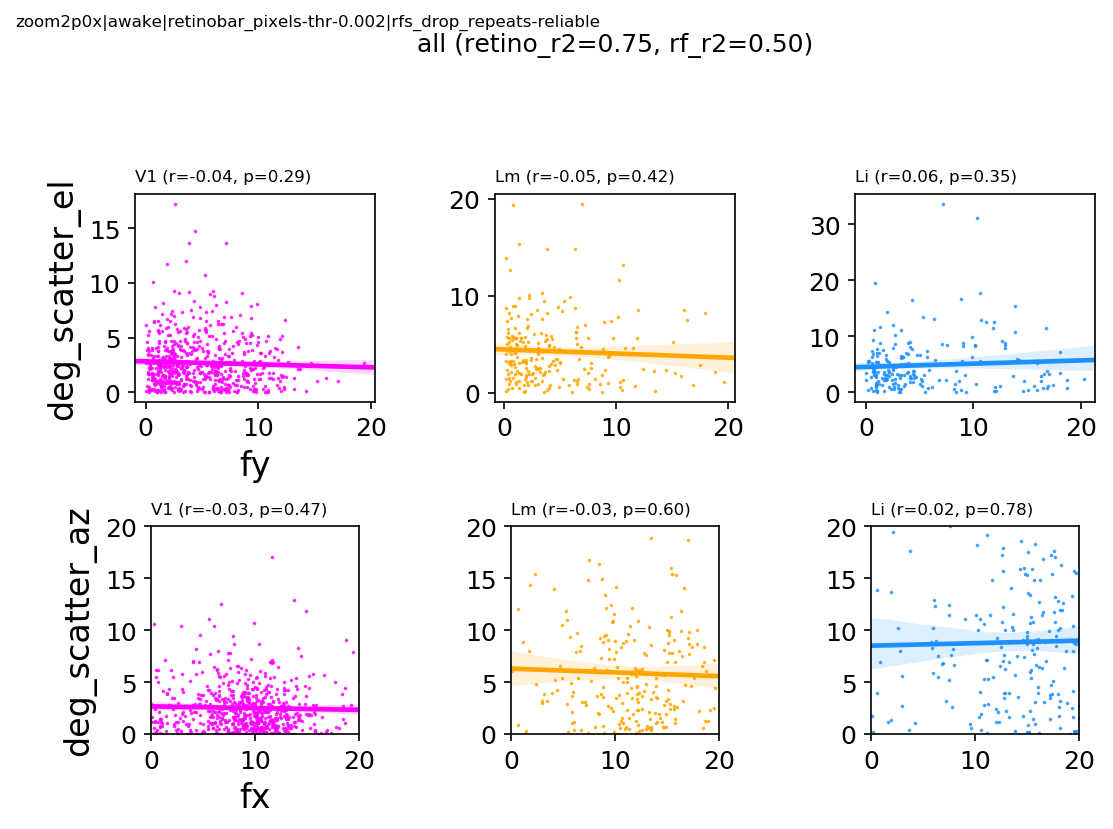

In [209]:
fig, axn = pl.subplots(2, 3, figsize=(8,6), dpi=dpi, sharey=False, sharex=False)
for ai, (visual_area, g) in enumerate(avg_scatter.groupby(['visual_area'])):
    
    ax=axn[0, 2-ai]
    xval = 'fy'
    yval = 'deg_scatter_el'
    sns.regplot(xval, yval, color=area_colors[visual_area], data=g, ax=ax,
               marker='.', scatter_kws={'s':2})
    r, p = spstats.pearsonr(g[xval].values, g[yval].values)
    ax.set_title('%s (r=%.2f, p=%.2f)' % (visual_area, r, p), loc='left', fontsize=8)
    
    ax=axn[1, 2-ai]
    xval = 'fx'
    yval = 'deg_scatter_az'
    sns.regplot(xval, yval, color=area_colors[visual_area], data=g, ax=ax,
               marker='.', scatter_kws={'s':2})
    r, p = spstats.pearsonr(g[xval].values, g[yval].values)
    ax.set_title('%s (r=%.2f, p=%.2f)' % (visual_area, r, p), loc='left', fontsize=8)
    
    ax.set_aspect('equal')
    ax.set_ylim([0, 20])
    ax.set_xlim([0, 20])
    
for ax in axn[:, 1:].flat:
    ax.set_ylabel('')
    ax.set_xlabel('')
    
pl.subplots_adjust(wspace=0.5, hspace=0.6, top=0.8, left=0.1, bottom=0.2)
fig.suptitle('%s (retino_r2=%.2f, rf_r2=%.2f)' % (rfname, retino_r2_thr, rf_r2_thr))
putils.label_figure(fig, data_id)

figname = '%s__scatter_v_projsize-along-ax' % prefix
pl.savefig(os.path.join(basedir, 'drop_repeats',  '%s.svg' % figname))
print(basedir, figname)

In [64]:
rfname

'all'

#### Average axes

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter', 'all_filter-drop_repeats__scatter_v_projsize-along-ax_average-axes')


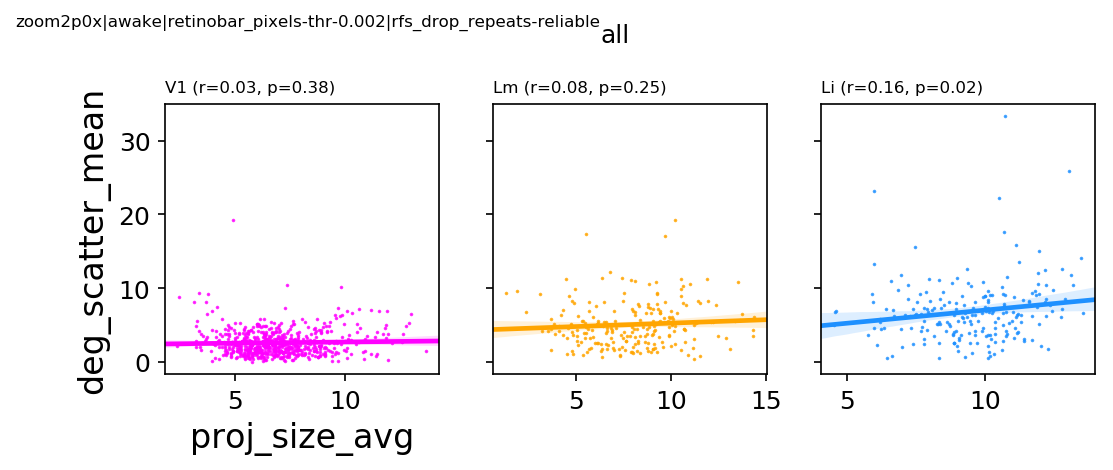

In [210]:
size_metric = 'proj_size_avg'

#xval = 'proj_size_avg'
xval = size_metric if size_metric=='proj_size_avg' else '%s_avg' % size_metric 

yval = 'deg_scatter_mean'
fig, axn = pl.subplots(1, 3, figsize=(8,3), dpi=dpi, sharey=True, sharex=False)
for ax, (visual_area, g) in zip(axn.flat[::-1], avg_scatter.groupby(['visual_area'])):
    sns.regplot(xval, yval, color=area_colors[visual_area], data=g, ax=ax,
               marker='.', scatter_kws={'s':2})
    r, p = spstats.pearsonr(g[xval].values, g[yval].values)
    ax.set_title('%s (r=%.2f, p=%.2f)' % (visual_area, r, p), loc='left', fontsize=8)

for ax in axn[1:]:
    ax.set_ylabel('')
    ax.set_xlabel('')
pl.subplots_adjust(wspace=0.2, top=0.8, bottom=0.2)

putils.label_figure(fig, data_id)
fig.suptitle("%s" % rfname)

figname = '%s__scatter_v_projsize-along-ax_average-axes' % prefix
pl.savefig(os.path.join(basedir, 'drop_repeats', '%s.svg' % figname))
print(basedir, figname)

#### By fov

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter', 'all_filter-drop_repeats__scatter_v_projsize-along-ax_avg-by-FOV')


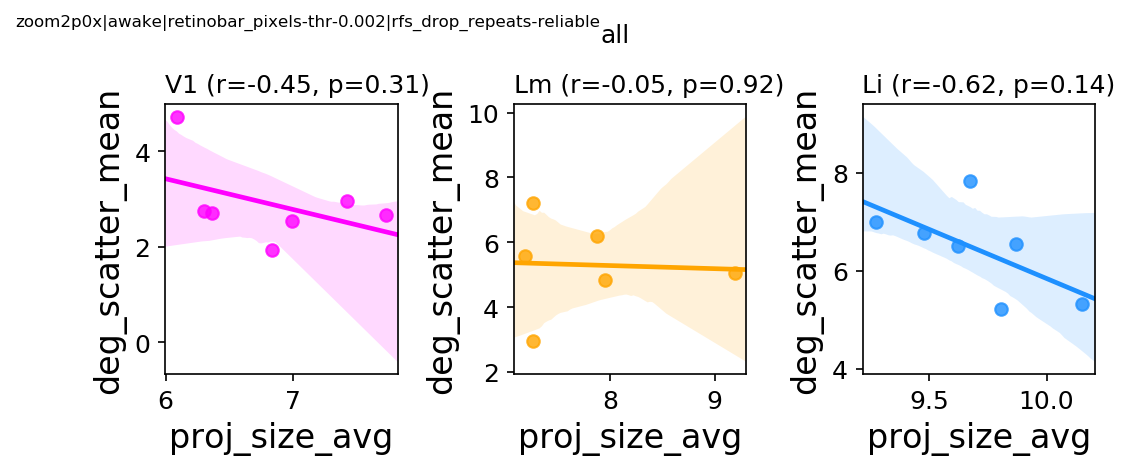

In [212]:
deg_scatter = 'deg_scatter_mean'
#rf_size = 'std_avg' 
rf_size = 'proj_size_avg' #'std_avg'
means = avg_scatter.groupby(['visual_area', 'datakey', 'experiment']).mean().reset_index()

fig, axn = pl.subplots(1, 3, figsize=(8,3), dpi=dpi, sharey=False, sharex=False)
for ax, (visual_area, g) in zip(axn.flat[::-1], means.groupby(['visual_area'])):
    sns.regplot(rf_size, deg_scatter, color=area_colors[visual_area], data=g, ax=ax)
    r, p = spstats.pearsonr(g[rf_size].values, g[deg_scatter].values)
    ax.set_title('%s (r=%.2f, p=%.2f)' % (visual_area, r, p), loc='left')
    
pl.subplots_adjust(wspace=0.5, top=0.8, bottom=0.2)
putils.label_figure(fig, data_id)

fig.suptitle("%s" % rfname)

figname = '%s__scatter_v_projsize-along-ax_avg-by-FOV' % prefix
pl.savefig(os.path.join(basedir, 'drop_repeats', '%s.svg' % figname))
print(basedir, figname)


# Spatial organization of RFs

In [213]:
import matplotlib as mpl
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import colors as mcolors

from matplotlib.patches import Ellipse, Rectangle, Polygon

# Anisotropy 

In [216]:
few_cells = [dk for (dk, experiment), g in rfdf.groupby(['datakey', 'experiment']) if len(g)<10]
few_cells

['20190420_JC076_fov1',
 '20190522_JC089_fov1',
 '20190528_JC092_fov1',
 '20190617_JC099_fov1',
 '20190627_JC091_fov1',
 '20191111_JC117_fov2']

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter', 'all_filter-drop_repeats__anisotropy_rfs')


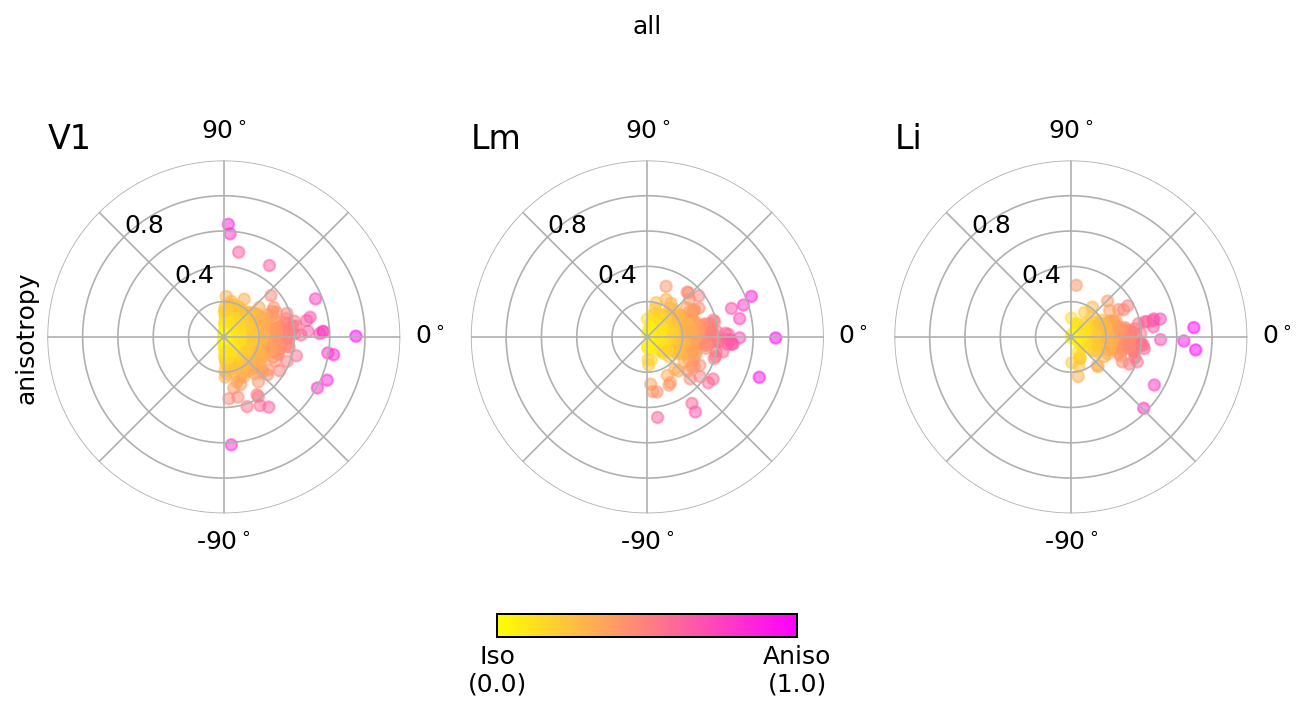

In [217]:
metric = 'anisotropy' #'ratio_xy'
cmap='spring_r'
# ---------------------------------------------------
rfname = 'all'

if rfname=='mixed':
    expdf = mixdf.copy()
else:
    expdf = rfdf.copy() #[(rfdf['experiment']==rfname)].copy()
# ---------------------------------------------------

expdf = expdf[~expdf['datakey'].isin(few_cells)]
expdf = expdf[expdf['r2']>0.5]

norm = mpl.colors.Normalize(vmin=0, vmax=1)
iso_cmap = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, axn = pl.subplots(1,3, subplot_kw=dict(projection='polar'), figsize=(10,5), dpi=dpi)
for ai, (visual_area, g) in enumerate(expdf.groupby(['visual_area'])):
    ax = axn[2-ai]
    ax = rfutils.anisotropy_polarplot(g, metric=metric, cmap=cmap, ax=ax)
    ax.set_ylim([0, 1])
    ax.set_title(visual_area, fontsize=16, loc='left')
    
    ax.set_xticklabels(['0$^\circ$', '', '90$^\circ$', '', '', '', '-90$^\circ$', ''])
    ax.set_rlabel_position(135) #315)
    ax.set_xlabel('')
    ax.set_yticklabels(['', 0.4, '', 0.8])
    if ai==2:
        ax.set_ylabel(metric, fontsize=12)
    else:
        ax.set_ylabel('')
    # Grid lines and such
    ax.spines['polar'].set_visible(False)
    
pl.suptitle(rfname)

figname = '%s__anisotropy_rfs' % (prefix)
pl.savefig(os.path.join(basedir, 'drop_repeats', '%s.svg' % figname))
print(basedir, figname)


## Anisotropy + spatial distn for these dsets

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter', 'all_filter-drop_repeats__spatial_distn_rfs_aniso_index__centroid')


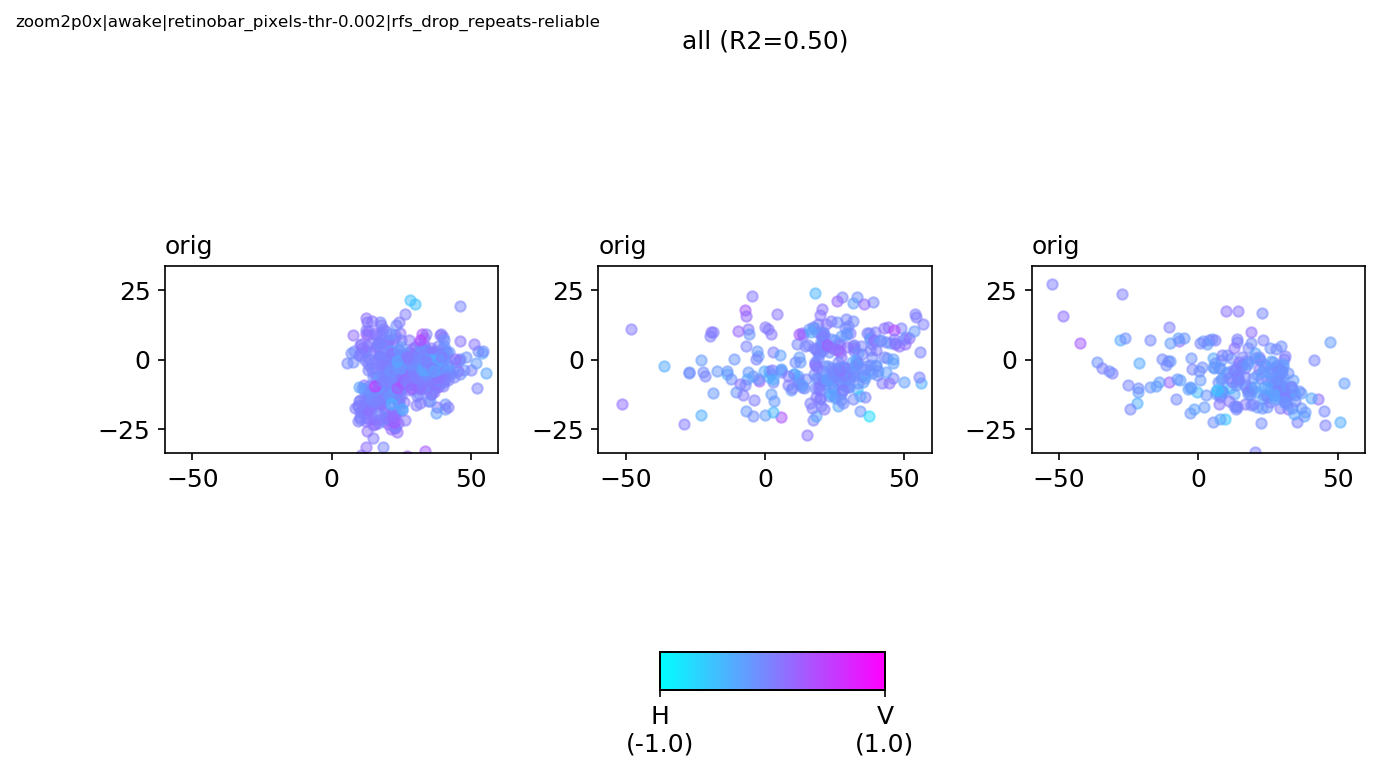

In [219]:
# ---------------------------------------------------
hue_param = 'aniso_index'
shape_str = 'centroid'
axis_lw=1
axis_alpha=1
centroid_alpha=0.5
ellipse_scale = 2.35
rf_r2_thr=0.5

# ---------------------------------------------------
rfname = 'all'

if rfname=='mixed':
    expdf = mixdf.copy()
else:
    expdf = rfdf.copy() #[(rfdf['experiment']==rfname)].copy()
# ---------------------------------------------------

expdf = expdf[~expdf['datakey'].isin(few_cells)]
expdf = expdf[expdf['r2']>rf_r2_thr]

norm = mpl.colors.Normalize(vmin=0, vmax=1)
iso_cmap = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, axn = pl.subplots(1,3,figsize=(10,5), dpi=dpi)
for ai, (visual_area, g) in enumerate(expdf.groupby(['visual_area'])):
    ax = axn[2-ai]
    ax = rfutils.draw_rf_on_screen(g.dropna(), hue_param=hue_param, ax=ax,
                           shape_str=shape_str, ellipse_scale=ellipse_scale, 
                           axis_lw=axis_lw, axis_alpha=axis_alpha,
                           centroid_alpha=centroid_alpha)
    ax.set_title('orig', loc='left')
    #ax.set_ylim([-20, 20])
    #ax.set_xlim([0, 50

pl.subplots_adjust(left=0.1, right=0.9, wspace=0.3, bottom=0.2)
pl.suptitle('%s (R2=%.2f)' % (rfname, rf_r2_thr))

putils.label_figure(fig, '%s' % (data_id))
#ax.set_ylim([-20, 20])
#ax.set_xlim([0, 50])


figname = '%s__spatial_distn_rfs_%s__%s' % (prefix, hue_param, shape_str)
pl.savefig(os.path.join(basedir, 'drop_repeats',  '%s.svg' % figname))
print(basedir, figname)


## Plot correlations

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter', 'all_filter-drop_repeats__spatial_distn_rfs_aniso_index_correlations')


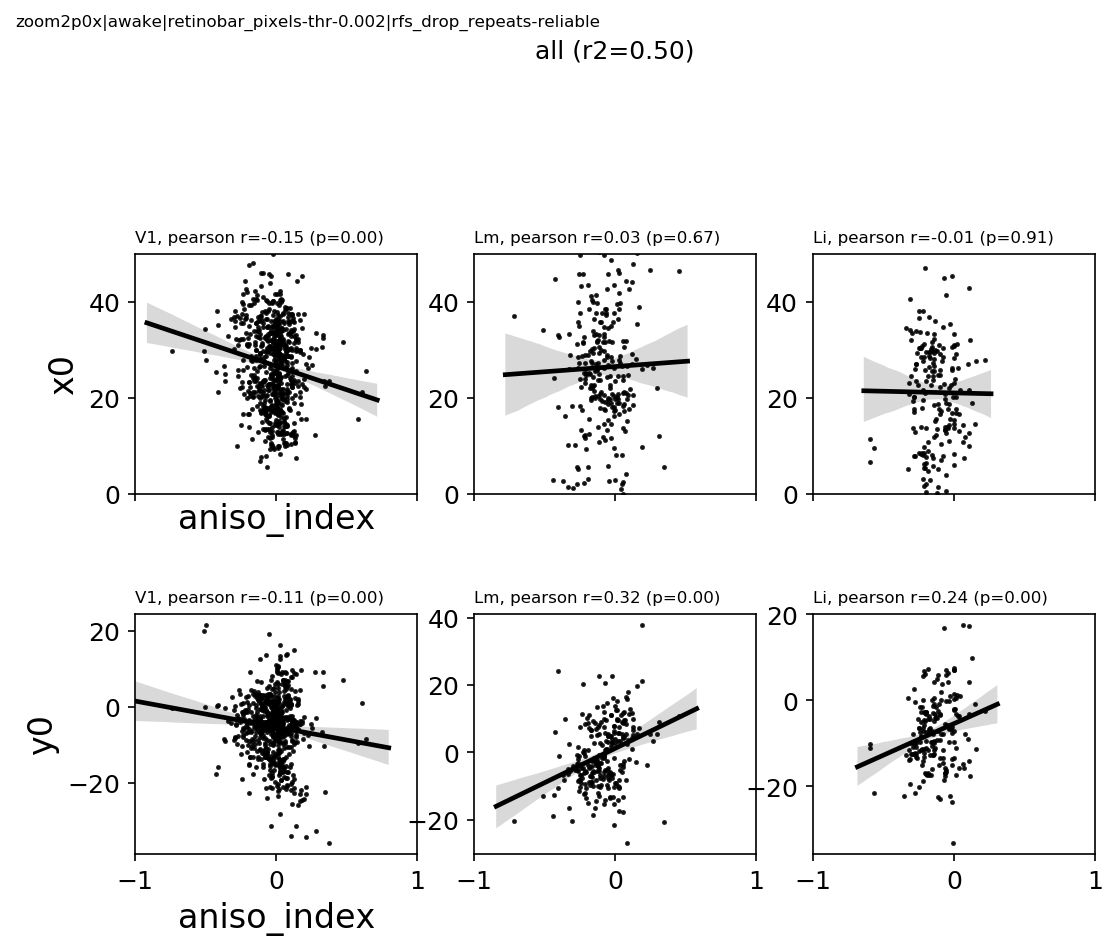

In [220]:
plotdf = expdf[expdf['x0']>0].copy()


fig, axn = pl.subplots(2, 3, figsize=(8,8), dpi=dpi, sharex=True, sharey=False)

scatter_kws={'s': 2}
for ai, (visual_area, vdf) in enumerate(plotdf.groupby(['visual_area'])):
    
    ax=axn[0, 2-ai]
    sns.regplot(x='aniso_index', y='x0', data=vdf, ax=ax, marker='o', color='k',
               scatter_kws=scatter_kws)
    ax.set_title(visual_area, loc='left')

    ax.set_ylim([0, 50])
    
    ax=axn[1, 2-ai]
    sns.regplot(x='aniso_index', y='y0', data=vdf, ax=ax, marker='o', color='k',
               scatter_kws=scatter_kws)
    

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
for ai, (visual_area, vdf) in enumerate(plotdf.groupby(['visual_area'])):
    ax=axn[0, 2-ai]
    pearsons_r, pearsons_p = spstats.pearsonr(vdf['aniso_index'].values, vdf['x0'].values)
    #ax.text(xmin+0.1, ymax-8, 'pearson r=%.2f (p=%.2f)' % (pearsons_r, pearsons_p))
    pearson_str = 'pearson r=%.2f (p=%.2f)' % (pearsons_r, pearsons_p)
    ax.set_title('%s, %s' % (visual_area, pearson_str), loc='left', fontsize=8)
    
    ax=axn[1, 2-ai]
    pearsons_r, pearsons_p = spstats.pearsonr(vdf['aniso_index'].values, vdf['y0'].values)
    #ax.text(xmin+0.1, ymax-8, 'pearson r=%.2f (p=%.2f)' % (pearsons_r, pearsons_p))
    ax.set_xlim([-1, 1])
    pearson_str = 'pearson r=%.2f (p=%.2f)' % (pearsons_r, pearsons_p)
    ax.set_title('%s, %s' % (visual_area, pearson_str), loc='left', fontsize=8)
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.3, top=0.8, hspace=0.5)
pl.suptitle('%s (r2=%.2f)' % (rfname, rf_r2_thr))
putils.label_figure(fig, '%s' % (data_id))

for ax in axn[:, 1:].flat:
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    
figname = '%s__spatial_distn_rfs_%s_correlations' % (prefix, hue_param)
pl.savefig(os.path.join(basedir,  'drop_repeats', '%s.svg' % figname))
print(basedir, figname)


# Does scatter/anisotropy compensate for coverage?

In [221]:
coverage_dir = os.path.join(basedir, 'drop_repeats', 'coverage_assigned')
if not os.path.exists(coverage_dir):
    os.makedirs(coverage_dir)
    print(coverage_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/drop_repeats/coverage_assigned


In [180]:
x0_p

NameError: name 'x0_p' is not defined

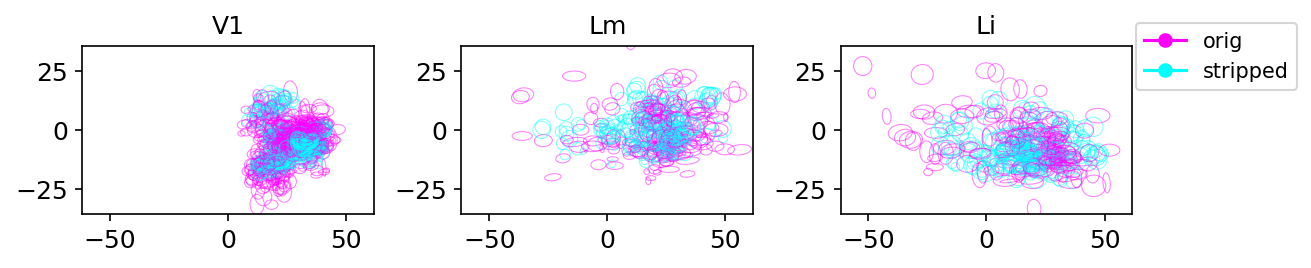

In [222]:
borderpad=2
ellipse_scale=0.5
ellipse_facecolor='none'
ellipse_lw=0.5
stripped_color='cyan'
orig_color ='magenta'

fill_ellipse=False
half_screen = False

stripped_fill = stripped_color if fill_ellipse else 'none'
orig_fill = orig_color if fill_ellipse else 'none'
ellipse_alpha=0.2 if fill_ellipse else 0.5

vmin, vmax = (-1, 1)
vmin = vmin if metric=='aniso_index' else 0 
vmax = vmax if metric=='aniso_index' else 1
cmap = cm.cool

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
scalar_cmap = cm.ScalarMappable(norm=norm, cmap=cmap)


f, axn = pl.subplots(1, 3, figsize=(10,4), dpi=dpi)

for ax in axn:
    if half_screen:
        ax.set_xlim([0, screenright+borderpad])
    else:
        ax.set_xlim([screenleft-borderpad, screenright+borderpad])
    ax.set_ylim([screenbottom-borderpad, screentop+borderpad])
    ax.set_aspect('equal')

# if rfname=='mixed':
#     rf_subdf = scatdf.copy()
# else:
#rf_subdf = scatdf.copy() #[scatdf['experiment']==rfname].copy()
currdf = pd.concat([g for c, g in scatdf.groupby(['datakey', 'cell']) 
                    if ('az' in g['axis'].values and 'el' in g['axis'].values)])
        
for (visual_area, experiment), vdf in currdf.groupby(['visual_area', 'experiment']):
    ai=visual_areas.index(visual_area)
    ax=axn[ai]
    for ri,g in vdf.groupby(['datakey', 'cell']):
        x0_p = float(g[g['axis']=='az']['predicted_rf'])
        y0_p = float(g[g['axis']=='el']['predicted_rf'])
        std_avg = g['std_avg'].iloc[0]
        
        x0 = float(g[g['axis']=='az']['x0'])
        y0 = float(g[g['axis']=='el']['y0'])
    
        std_x = g['std_x'].iloc[0]
        std_y = g['std_y'].iloc[0]
        theta = g['theta'].iloc[0]

        aniso = g['aniso_index'].iloc[0]          
        theta_col = scalar_cmap.to_rgba(aniso)

        el = Ellipse((x0_p, y0_p), width=std_avg*ellipse_scale, height=std_avg*ellipse_scale, 
                     angle=0, edgecolor=stripped_color, facecolor=stripped_fill, 
                     alpha=ellipse_alpha, lw=ellipse_lw)
        ax.add_artist(el)


        el2 = Ellipse((x0, y0), width=std_x*ellipse_scale, height=std_y*ellipse_scale, 
                     angle=theta, edgecolor=orig_color, facecolor=orig_fill, 
                     alpha=ellipse_alpha, lw=ellipse_lw)
        ax.add_artist(el2)
        
    ax.set_title(visual_area)

    
pl.subplots_adjust(wspace=0.3, left=0.1, right=0.8)
leg_elements = putils.custom_legend_markers(labels=['orig', 'stripped'], colors=[orig_color, stripped_color])
axn[-1].legend(handles=leg_elements, bbox_to_anchor=(1.6, 1.2))

pl.savefig(os.path.join(coverage_dir, '%s__distn_orig-v-stripped.svg' % (prefix)))

#### Per fov

In [223]:
scatdf[['visual_area', 'datakey', 'experiment']].drop_duplicates().groupby(['visual_area']).count()

datakey  experiment
visual_area                     
Li                 7           7
Lm                 6           6
V1                 7           7

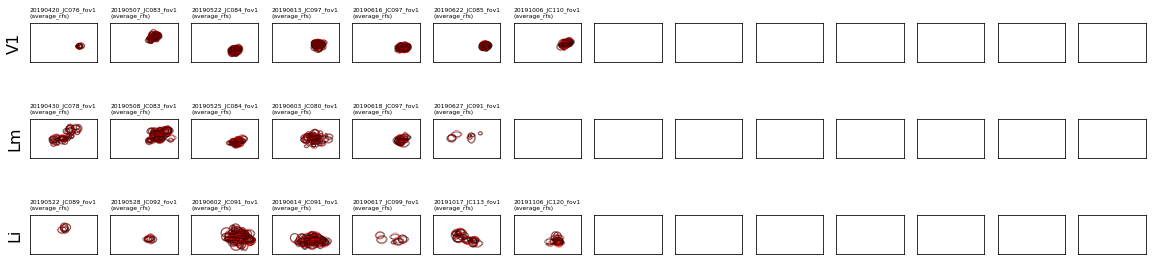

In [224]:
borderpad=2
ellipse_scale=1
ellipse_facecolor='none'
ellipse_lw=1
stripped_color='cyan'
orig_color ='magenta'

f, axn = pl.subplots(3, 14, figsize=(20, 5))

for ax in axn.flat:
#     ax.set_xlim([0,40])
#     ax.set_ylim([-20, 5])
    ax.set_xlim([screenleft-borderpad, screenright+borderpad])
    ax.set_ylim([screenbottom-borderpad, screentop+borderpad])
    ax.set_aspect('equal')
    putils.turn_off_axis_ticks(ax, despine=False) #'off')
    
i=0
prev_dkey='test'
prev_v='test'
for ai, ((visual_area, dkey, experiment), vdf) in enumerate(currdf.groupby(['visual_area', 'datakey', 'experiment'])):
    ri = visual_areas.index(visual_area)
    if prev_v != visual_area:
        i=0
    ax = axn[ri, i]
    ax.set_title('%s\n(%s)' % (dkey, experiment), loc='left', fontsize=6)
    if experiment=='rfs10':
        orig_color, stripped_color = ['magenta', 'cyan']
    else:
        orig_color, stripped_color = ['k', 'r']
    if i==0:
        ax.set_ylabel(visual_area)
    for ri,g in vdf.groupby(['datakey', 'cell']):
        x0_p = g[g['axis']=='az']['predicted_rf']
        y0_p = g[g['axis']=='el']['predicted_rf']
        std_avg = g['std_avg'].iloc[0]

        x0 = g[g['axis']=='az']['x0']
        y0 = g[g['axis']=='el']['y0']

        std_x = g['std_x'].iloc[0]
        std_y = g['std_y'].iloc[0]
        theta = g['theta'].iloc[0]

        aniso = g['aniso_index'].iloc[0]          
        theta_col = scalar_cmap.to_rgba(aniso)

        el = Ellipse((x0_p, y0_p), width=std_avg*ellipse_scale, height=std_avg*ellipse_scale, 
                     angle=0, edgecolor=stripped_color, facecolor=stripped_fill, 
                     alpha=ellipse_alpha, lw=ellipse_lw)
        ax.add_artist(el)


        el2 = Ellipse((x0_p, y0_p), width=std_x*ellipse_scale, height=std_y*ellipse_scale, 
                     angle=theta, edgecolor=orig_color, facecolor=orig_fill, 
                     alpha=ellipse_alpha, lw=ellipse_lw)
        ax.add_artist(el2)
    #if dkey != prev_dkey:
    i+=1
    prev_v=visual_area
    prev_dkey = dkey
    
    
pl.savefig(os.path.join(coverage_dir, '%s_rfs_by_fov.svg' % prefix))

In [225]:
prefix, coverage_dir

('all_filter-drop_repeats',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/drop_repeats/coverage_assigned')

## Calculate differences

In [226]:
from shapely import geometry, ops

In [227]:
def stripdown_rfdf(xdf, sz_metric='fwhm', pos_only=False, size_only=False, do_theta=True):
    '''
    xdf: rfdf that has info about scatter, i.e., has 'predicted_rf' from gradient analysis
    rf_columns: ['cell', 'x0', 'y0', 'fwhm_x', 'fwhm_y', 'theta']
    '''
    
    rf_columns=['cell', 'x0', 'y0', '%s_x' % sz_metric, '%s_y' % sz_metric, 'theta']
    curr_rfs = xdf[rf_columns].drop_duplicates().copy()

    # Create stripped down RFs
    stripped = curr_rfs.copy()
    if do_theta:
        stripped['theta'] = [0 for _ in np.arange(0, len(stripped))]
        
    if pos_only:
        stripped['x0'] = xdf[xdf['axis']=='az']['predicted_rf'].values
        stripped['y0'] = xdf[xdf['axis']=='el']['predicted_rf'].values
        return stripped
    
    elif size_only:
        stripped['%s_x' % sz_metric] = curr_rfs[['%s_x' % sz_metric, '%s_y' % sz_metric]].mean(axis=1)
        stripped['%s_y' % sz_metric] = curr_rfs[['%s_x' % sz_metric, '%s_y' % sz_metric]].mean(axis=1)
        return stripped
    
    else:
        stripped['%s_x' % sz_metric] = curr_rfs[['%s_x' % sz_metric, '%s_y' % sz_metric]].mean(axis=1)
        stripped['%s_y' % sz_metric] = curr_rfs[['%s_x' % sz_metric, '%s_y' % sz_metric]].mean(axis=1)
        stripped['x0'] = xdf[xdf['axis']=='az']['predicted_rf'].values
        stripped['y0'] = xdf[xdf['axis']=='el']['predicted_rf'].values
        stripped['theta'] = [0 for _ in np.arange(0, len(stripped))]
        
    return stripped


## Calculate effect of scatter 

In [289]:
#rfname = 'rfs10'
rf_subdf = scatdf.copy() #[scatdf['experiment']==experiment].copy()
vardf = pd.concat([g for c, g in rf_subdf.groupby(['datakey', 'cell']) 
                    if ('az' in g['axis'].values and 'el' in g['axis'].values)])
        

In [228]:
#rfname = 'rfs10'
rf_subdf = scatdf.copy() #[scatdf['experiment']==experiment].copy()
currdf = pd.concat([g for c, g in rf_subdf.groupby(['datakey', 'cell']) 
                    if ('az' in g['axis'].values and 'el' in g['axis'].values)])
        

In [230]:
by_fov_dir = os.path.join(basedir, 'drop_repeats', 'coverage_diffs_by_fov_assigned')
if not os.path.exists(by_fov_dir):
    os.makedirs(by_fov_dir)
    print(by_fov_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/drop_repeats/coverage_diffs_by_fov_assigned


In [231]:

sz_metric = 'std' # rfs_to_polys() converts to fwhm
r_params = ['cell', '%s_x' % sz_metric, '%s_y' % sz_metric, 'theta', 'x0', 'y0']

d_list=[]
i=0
for (visual_area, datakey, experiment), xdf in currdf.groupby(['visual_area', 'datakey', 'experiment']):
    d_ = []
    session, animalid, fov = datakey.split('_')
    
    # Get original RFs
    curr_rfs = xdf[r_params].drop_duplicates().copy()
    rf_polys = rfutils.rfs_to_polys(curr_rfs)
    # Union of RFs (overall coverage)    
    orig_merged = ops.cascaded_union([p[1] for p in rf_polys])
    orig_areas=[r[1].area for r in rf_polys]
    tmpdf =  pd.DataFrame({'area': orig_merged.area, 'cond': 'orig', 
                           'mean_diff_per_rf': np.mean(orig_areas)}, index=[0])
    d_.append(tmpdf)
    i+=1
    for cond in ['stripped', 'update_size', 'update_pos']:
        pos_only = cond=='update_pos'
        size_only = cond=='update_size'
        
        # stripped down RF params
        adjusted = stripdown_rfdf(xdf, sz_metric=sz_metric, pos_only=pos_only, size_only=size_only, do_theta=True)
        # polys
        adjusted_polys = rfutils.rfs_to_polys(adjusted)
        # merge
        adjusted_merged = ops.cascaded_union([p[1] for p in adjusted_polys])
        area_diff = orig_merged.area - adjusted_merged.area
        
        # Per-RF differences
        adjusted_rf_areas = [r[1].area for r in adjusted_polys]
        delta_areas = [(rp - sp) / sp for rp, sp in zip(orig_areas, adjusted_rf_areas)]

        tmpdf = pd.DataFrame({'area': adjusted_merged.area, 'cond': cond, 
                              'mean_diff_per_rf': np.mean(delta_areas)}, index=[i])
        d_.append(tmpdf)
        i+=1
    currd = pd.concat(d_, axis=0).reset_index(drop=True)
    metainfo = {'datakey': datakey, 'visual_area': visual_area, 'animalid': animalid, 
                'session': session, 'fov': fov, 'experiment': experiment}
    currd = aggr.add_meta_to_df(currd, metainfo)
    d_list.append(currd)

coverage = pd.concat(d_list, axis=0)
coverage.shape


(80, 9)

In [232]:
coverage.head()

area         cond  mean_diff_per_rf   fov   experiment animalid  \
0  5370.327652         orig      3.092637e+03  fov1  average_rfs    JC089   
1  4127.444756     stripped     -1.937095e-02  fov1  average_rfs    JC089   
2  5130.079369  update_size     -1.937095e-02  fov1  average_rfs    JC089   
3  4344.998073   update_pos      1.740787e-16  fov1  average_rfs    JC089   
0  4847.747356         orig      2.864192e+03  fov1  average_rfs    JC092   

    session              datakey visual_area  
0  20190522  20190522_JC089_fov1          Li  
1  20190522  20190522_JC089_fov1          Li  
2  20190522  20190522_JC089_fov1          Li  
3  20190522  20190522_JC089_fov1          Li  
0  20190528  20190528_JC092_fov1          Li

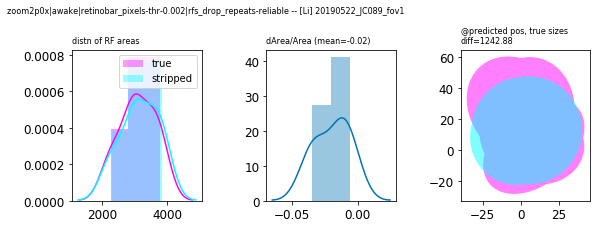

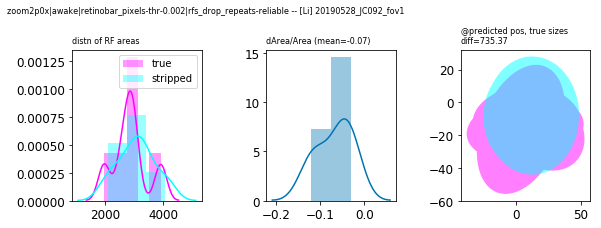

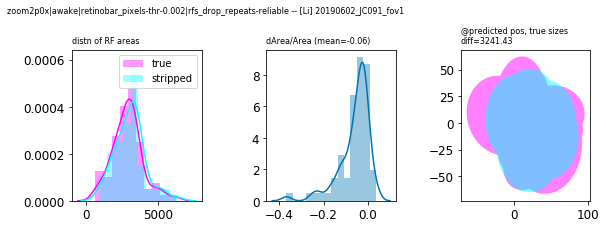

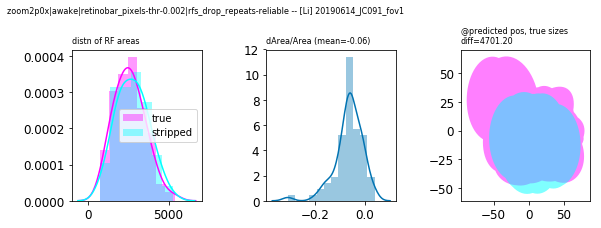

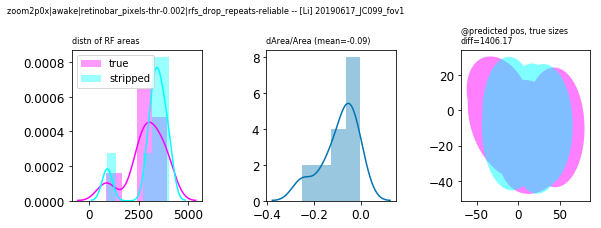

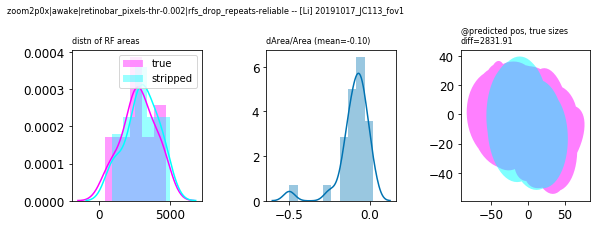

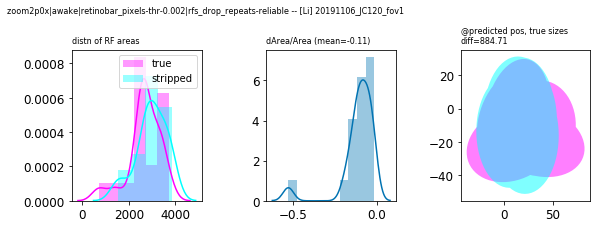

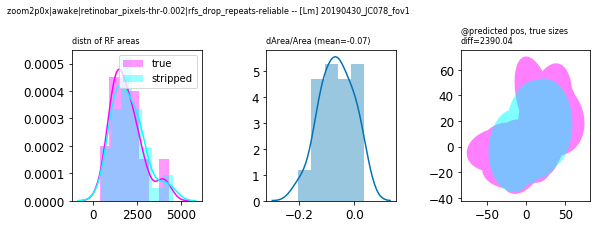

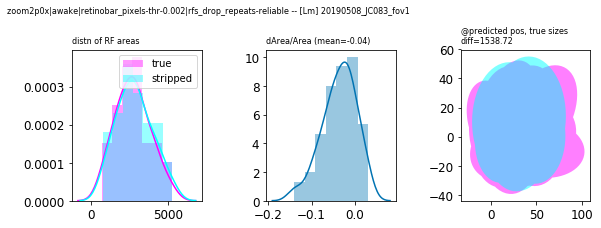

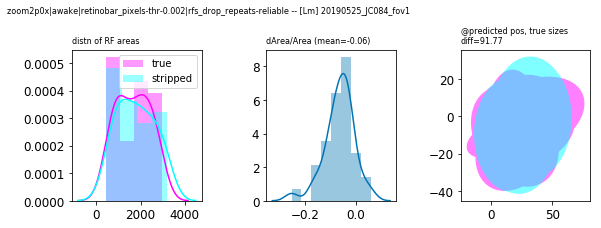

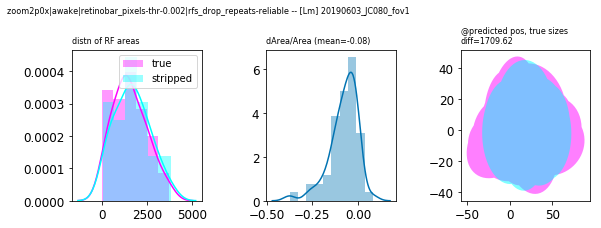

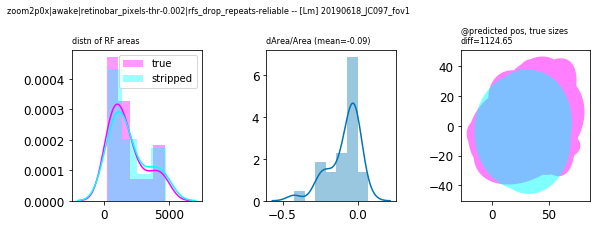

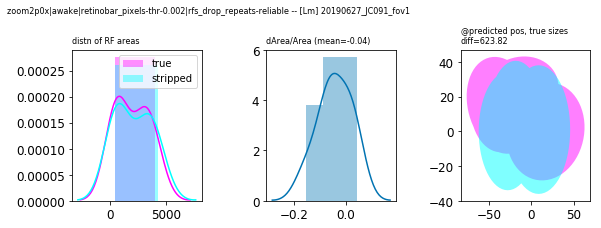

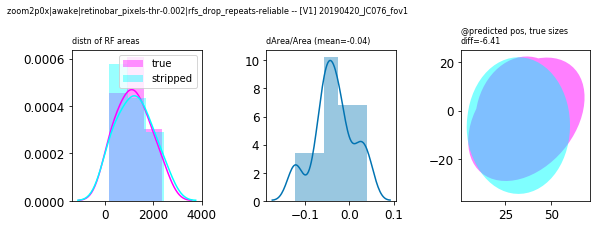

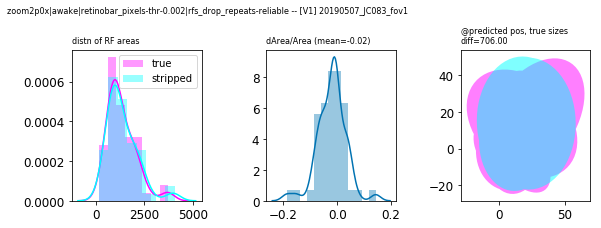

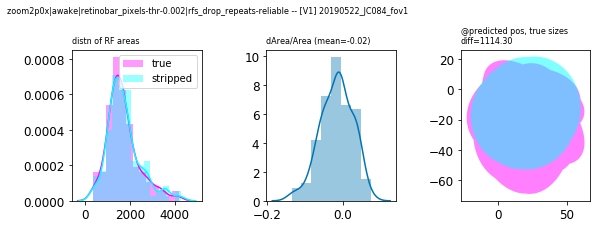

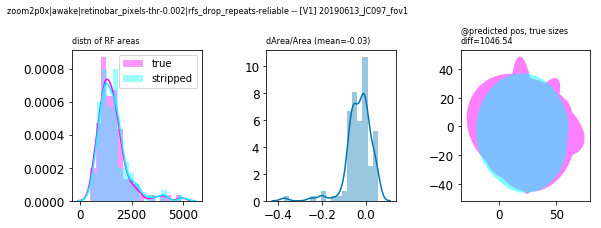

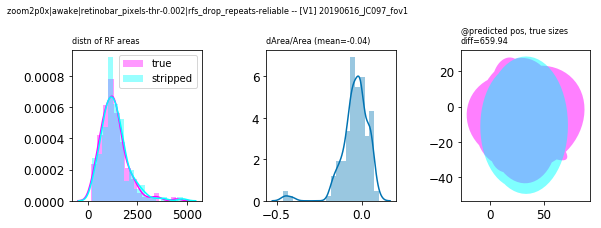

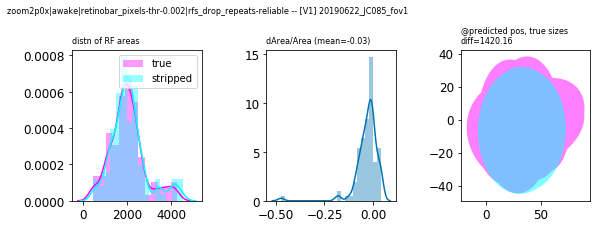

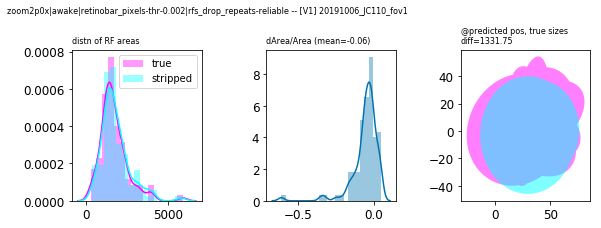

In [233]:
stripped_color='cyan'
orig_color ='magenta'

sz_metric = 'std' # rfs_to_polys() converts to fwhm
r_params = ['cell', '%s_x' % sz_metric, '%s_y' % sz_metric, 'theta', 'x0', 'y0']

i=0
for (visual_area, datakey, experiment), xdf in currdf.groupby(['visual_area', 'datakey', 'experiment']):
#xdf = currdf[currdf['datakey']==datakey].copy()
    d_ = []
    session, animalid, fov = datakey.split('_')

    curr_rfs = xdf[r_params].drop_duplicates().copy()
    rf_polys = rfutils.rfs_to_polys(curr_rfs)
    # Union of RFs (overall coverage)    
    orig_merged = ops.cascaded_union([p[1] for p in rf_polys])
    orig_areas=[r[1].area for r in rf_polys]
    
    # Strip position (deg scatter) and RF shape  (anisotropy)
    stripped = stripdown_rfdf(xdf, sz_metric=sz_metric, pos_only=False, size_only=False, do_theta=True)
    stripped_polys = rfutils.rfs_to_polys(stripped)
    stripped_merged = ops.cascaded_union([p[1] for p in stripped_polys])
    stripped_diff = orig_merged.area - stripped_merged.area
    stripped_areas = [r[1].area for r in stripped_polys]

    # Per-RF differences
    delta_areas = [(rp - sp) / sp for rp, sp in zip(orig_areas, stripped_areas)]

    # PLOT
    f, axn = pl.subplots(1,3, figsize=(9,3))

    ax=axn[0]
    ax.set_title('distn of RF areas', loc='left', fontsize=8)
    sns.distplot(orig_areas, color=orig_color, ax=ax, label='true')
    sns.distplot(stripped_areas, color=stripped_color, ax=ax, label='stripped')
    ax.legend()

    ax=axn[1]
    sns.distplot(delta_areas, ax=ax)
    ax.set_title('dArea/Area (mean=%.2f)' % np.mean(delta_areas), fontsize=8, loc='left')

    ax=axn[2]
    ax.set_title('@predicted pos, true sizes\ndiff=%.2f' % stripped_diff, loc='left', fontsize=8)
    orig_xs, orig_ys = orig_merged.exterior.xy    
    stripped_xs, stripped_ys = stripped_merged.exterior.xy    
    ax.fill(orig_xs, orig_ys, alpha=0.5, fc=orig_color, ec='none')
    ax.fill(stripped_xs, stripped_ys, alpha=0.5, fc=stripped_color, ec='none')

    label_figure(f, '%s -- [%s] %s' % (data_id, visual_area, datakey))
    pl.subplots_adjust(left=0.1, wspace=0.5, top=0.8, bottom=0.1)
    
    figname = '%s_%s_%s_coverage_diffs' % (visual_area, datakey, experiment)
    pl.savefig(os.path.join(by_fov_dir, '%s.png' % figname))


## Calculate total coverage change by area

In [235]:
d_=[]
for ai, ((visual_area, experiment), g) in enumerate(coverage.groupby(['visual_area', 'experiment'])):
    og = g[g['cond']=='orig']['area'].values
    stp = g[g['cond']=='stripped']['area'].values
    diffs = (og - stp) / og
    tmpdiff = g[g['cond']=='orig'][['visual_area', 'experiment', 'animalid', 'session', 'fov']].copy()
    tmpdiff['dA'] = diffs
    
    d_.append(tmpdiff)
dA_df = pd.concat(d_, axis=0).reset_index(drop=True)

*****************
[('V1', 'Lm')] p=0.472 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.145 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.168 (fdr_bh), reject H0=False
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/drop_repeats/coverage_assigned', 'all_filter-drop_repeats__delta_area_by_fov')


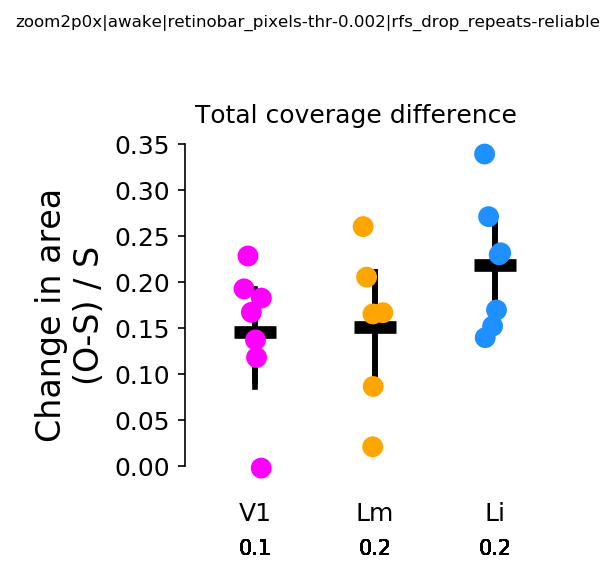

In [236]:
f, ax = pl.subplots(figsize=(4,4), dpi=dpi)
sns.stripplot(x='visual_area', y='dA', data=dA_df, ax=ax, 
              marker='o', s=10, palette=area_colors, order=visual_areas)

sns.barplot(x='visual_area', y='dA', data=dA_df, ax=ax, ci=95,
            errcolor="k", edgecolor=tuple(['w' for _ in np.arange(0, len(g))]),
            facecolor=(1,1,1,0), linewidth=0, order=visual_areas)

sns.pointplot(x="visual_area", y='dA', data=dA_df, 
                ax=ax, order=visual_areas, ci=95,
                markers='_', join=False, capsize=0., dodge=True,
                scale=3, color='k')

print("*****************")
dA_df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f', xytext=(0, -40))
y_loc = 0.4
statresults = aggr.do_mannwhitney(dA_df, metric='dA', multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax, y_loc=y_loc, offset=0.05)


#sns.despine(bottom=True, trim=True)
#ax.set_ylim([-0.3, 0.35])
ax.set_ylabel('Change in area\n(O-S) / S')
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(visual_areas)
ax.set_xlabel('')
ax.tick_params(which='both', axis='x', size=0)

sns.despine(ax=ax, bottom=True, offset=5, trim=True)
pl.subplots_adjust(left=0.3, top=0.8, bottom=0.2)

ax.set_title('Total coverage difference', fontsize=12, loc='left')
label_figure(f, data_id)

figname = '%s__delta_area_by_fov' % prefix
pl.savefig(os.path.join(coverage_dir, '%s.svg' % figname))
print(coverage_dir, figname)

#### Split by the type of "scatter" that is removed

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/drop_repeats/coverage_assigned', 'all_filter-drop_repeats__split_by_scatter_param')


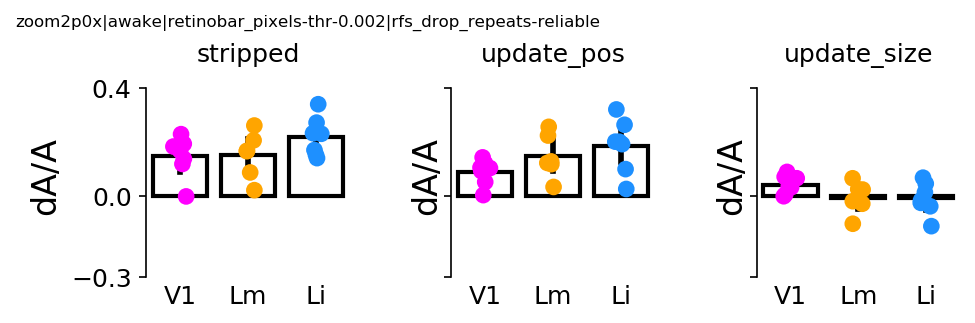

In [237]:
f, axn = pl.subplots(1,3, figsize=(7,2), sharex=True, sharey=True, dpi=dpi)
#for ax, (visual_area, g) in zip(axn, coverage.groupby(['visual_area'])):
conds = [ 'stripped', 'update_size', 'update_pos']
covdf_orig = coverage[coverage['cond']=='orig'].copy().reset_index(drop=True)
covdf_adj = coverage[coverage['cond']!='orig'].copy().reset_index(drop=True)

for ax, (cond, cg) in zip(axn, covdf_adj.groupby(['cond'])):
        
    d_ = cg.copy().reset_index(drop=True)
    d_['diff'] = (covdf_orig['area'] - d_['area']) / covdf_orig['area']
    sns.stripplot(x='visual_area', y='diff', ax=ax, data=d_, 
                  hue='visual_area', palette=area_colors, order=visual_areas, marker='o', s=8)
                  #scatter_kws={'markersize':5})
    ax.legend_.remove()

    sns.barplot(x="visual_area", y='diff', data=d_, 
                ax=ax, order=visual_areas, ci=95,
                errcolor="k", edgecolor=('k', 'k', 'k'), 
                facecolor=(1,1,1,0), linewidth=2)
    sns.despine(bottom=True, trim=True)
    
    ax.set_ylim([-0.3, 0.45])
    ax.set_yticks([-0.3, 0, 0.4])
    ax.set_title(cond)
    ax.set_ylabel('dA/A')
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    
pl.subplots_adjust(wspace=0.5, top=0.8)
label_figure(f, data_id)

figname = '%s__split_by_scatter_param' % prefix
pl.savefig(os.path.join(coverage_dir, '%s.svg' % figname))
print(coverage_dir, figname)

#### Example FOV

In [239]:
r_params

['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']

In [240]:
sz_metric = 'std' # rfs_to_polys() converts to fwhm
r_params = ['cell', '%s_x' % sz_metric, '%s_y' % sz_metric, 'theta', 'x0', 'y0']
print(r_params)

datakey = '20190616_JC097_fov1'

#for (visual_area, datakey), xdf in currdf.groupby(['visual_area', 'datakey']):
xdf = currdf[currdf['datakey']==datakey].copy()

curr_rfs = xdf[r_params].drop_duplicates().copy()
rf_polys = rfutils.rfs_to_polys(curr_rfs)

# Strip position (deg scatter) and RF shape  (anisotropy)
stripped = stripdown_rfdf(xdf, sz_metric=sz_metric, pos_only=False, size_only=False, do_theta=True)
stripped_polys = rfutils.rfs_to_polys(stripped)

# Update std_x, std_y
keep_size = stripdown_rfdf(xdf, sz_metric=sz_metric, pos_only=False, size_only=True, do_theta=True)
size_polys = rfutils.rfs_to_polys(keep_size)

# Update pos only #, std_y
keep_pos = stripdown_rfdf(xdf, sz_metric=sz_metric, pos_only=True, size_only=False, do_theta=True)
pos_polys = rfutils.rfs_to_polys(keep_pos)

['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']


Text(0,1,u'RFs, 20190616_JC097_fov1')

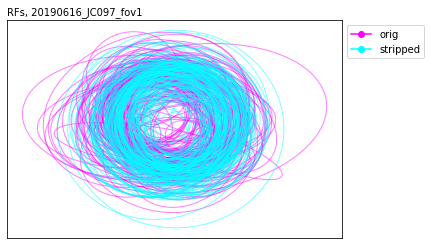

In [241]:
fill_ellipse=False
ellipse_alpha=0.1 if fill_ellipse else 0.5
alt_color=stripped_color

f, ax = pl.subplots()

for rf in rf_polys:
    xs, ys = rf[1].exterior.xy    
    ax.fill(xs, ys, alpha=ellipse_alpha, fc=orig_color if fill_ellipse else 'none', 
            ec='none' if fill_ellipse else orig_color)

for rf in stripped_polys:
    xs, ys = rf[1].exterior.xy    
    ax.fill(xs, ys, alpha=ellipse_alpha, fc=alt_color if fill_ellipse else 'none', 
            ec='none' if fill_ellipse else alt_color)

leg_elements = putils.custom_legend_markers(colors=[orig_color, stripped_color], 
                                        labels=['orig', 'stripped'], marker='o')
putils.turn_off_axis_ticks(ax, despine=False)
ax.legend(handles=leg_elements, bbox_to_anchor=(1., 1))

ax.set_title("RFs, %s" % datakey, loc='left', fontsize=10)

## Calcuulate densities

In [242]:
from pipeline.python.classifications import sim_utils as su
import matplotlib.gridspec as gridspec

In [243]:
def sum_rf_arrays(pixrfs, resolution=[1080, 1920]):
    orig_summed = np.zeros(screen_ds)
    for rid, pg in pixrfs.groupby(['cell']):
        _, x0, y0, sz_x, sz_y, rf_theta = pg.iloc[0].values
        rf_mask, _ = su.rf_mask_to_screen(x0, y0, sz_x, sz_y, rf_theta, resolution=resolution)
        orig_summed += rf_mask
    return orig_summed

In [244]:
def var_as_coverage(orig_summed, cutoff=0, remove_zeros=True):
    
    vec = orig_summed.copy()
    if remove_zeros:
        vec[orig_summed<=cutoff] = np.nan
    d = pd.DataFrame({'values': vec.ravel()}).dropna().values

    v1 = np.sum(abs(d - np.mean(d)**2)) / len(d)
    # print(np.var(orig_summed.ravel()), np.var(d, ddof=1), v1)
    
    return d, np.var(d, ddof=1)

In [245]:
def plot_densities_as_sum(orig_summed, strip_summed, dpi=150, cmap='hot',
                          orig_color='m', stripped_color='c', 
                          cutoff=0, remove_zeros=True):

    vmax=max([orig_summed.max(), strip_summed.max()])
    vmin = 0

    f, axf = pl.subplots(1, 5, figsize=(10,3), dpi=dpi)
    axn=axf.flat

    ax=axn[0]
    ax.imshow(orig_summed, cmap=cmap, vmin=0, vmax=vmax)
    ax.axis('off')
    ax.set_title('orig')

    ax=axn[1]
    ax.imshow(strip_summed, cmap=cmap, vmin=0, vmax=vmax)
    ax.axis('off')
    ax.set_title('stripped')

    ax=axn[3]
    ax.plot(orig_summed.sum(axis=1), color=orig_color)
    ax.plot(strip_summed.sum(axis=1), color=stripped_color)
    ax.set_title('collapse across x', fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)
    ax.set_yticks([])
    sns.despine(ax=ax, trim=True, offset=2, left=True)

    ax=axn[4]
    ax.plot(orig_summed.sum(axis=0), color=orig_color, label='orig')
    ax.plot(strip_summed.sum(axis=0), color=stripped_color, label='stripped')
    ax.set_title('collapse across y', fontsize=8)
    ax.set_yticks([])
    sns.despine(ax=ax, trim=True, offset=2, left=True)

    ax=axn[2]
    ax.set_xlabel('# RFs found')
    orig_vals, o_var = var_as_coverage(orig_summed, cutoff=cutoff, remove_zeros=remove_zeros)
    strip_vals, s_var = var_as_coverage(strip_summed, cutoff=cutoff, remove_zeros=remove_zeros)
    sns.distplot(orig_vals, kde=False, norm_hist=True, color=orig_color, label='orig (V=%.1f)' % o_var, 
                 hist='step', ax=ax, hist_kws={'alpha': 0.8})
    sns.distplot(strip_vals, kde=False, norm_hist=True, color=stripped_color, label='strip (V=%.1f)' % s_var, 
                 hist='step', ax=ax, hist_kws={'alpha': 0.8})
    if len(orig_vals)>0:
        xlim = max(orig_vals.max(), strip_vals.max())
        xlim = xlim - (xlim%10) + 10.
        ax.set_xlim([0, xlim])
    ax.legend(bbox_to_anchor=(0.2,1), fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)

    pl.subplots_adjust(top=0.5, wspace=0.8, bottom=0.3, left=0.01, hspace=0.8)

    return f


#### by fov, plot variances

In [246]:
coverage_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/drop_repeats/coverage_assigned'

In [248]:
density_dir = os.path.join(coverage_dir, 'densities_by_fov')
if not os.path.exists(density_dir):
    os.makedirs(density_dir)

#### Drawing ellipse onto array

In [249]:
screeninfo = putils.get_screen_dims()
screeninfo

{'altitude_cm': 58.0,
 'altitude_deg': 67.323,
 'azimuth_cm': 103.0,
 'azimuth_deg': 119.5564,
 'deg_per_pixel': (0.06226895833333333, 0.062336111111111106),
 'resolution': [1920, 1080]}

In [250]:
ds_factor = 2

screen_res = np.array([1080, 1920])
screen_ds = screen_res/ds_factor
print(screen_ds)

pix_per_deg = 1./screeninfo['deg_per_pixel'][0]
pix_per_deg_ds = pix_per_deg / 2.

[540 960]


['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
(40, 10)


N animalid      cond              datakey   experiment   fov   session  \
0   5    JC089      orig  20190522_JC089_fov1  average_rfs  fov1  20190522   
1   5    JC089  stripped  20190522_JC089_fov1  average_rfs  fov1  20190522   
2   6    JC092      orig  20190528_JC092_fov1  average_rfs  fov1  20190528   
3   6    JC092  stripped  20190528_JC092_fov1  average_rfs  fov1  20190528   
4  72    JC091      orig  20190602_JC091_fov1  average_rfs  fov1  20190602   

        std        var visual_area  
0  0.486628   0.236807          Li  
1  1.409237   1.985950          Li  
2  1.184943   1.404089          Li  
3  1.608471   2.587180          Li  
4  4.548853  20.692061          Li

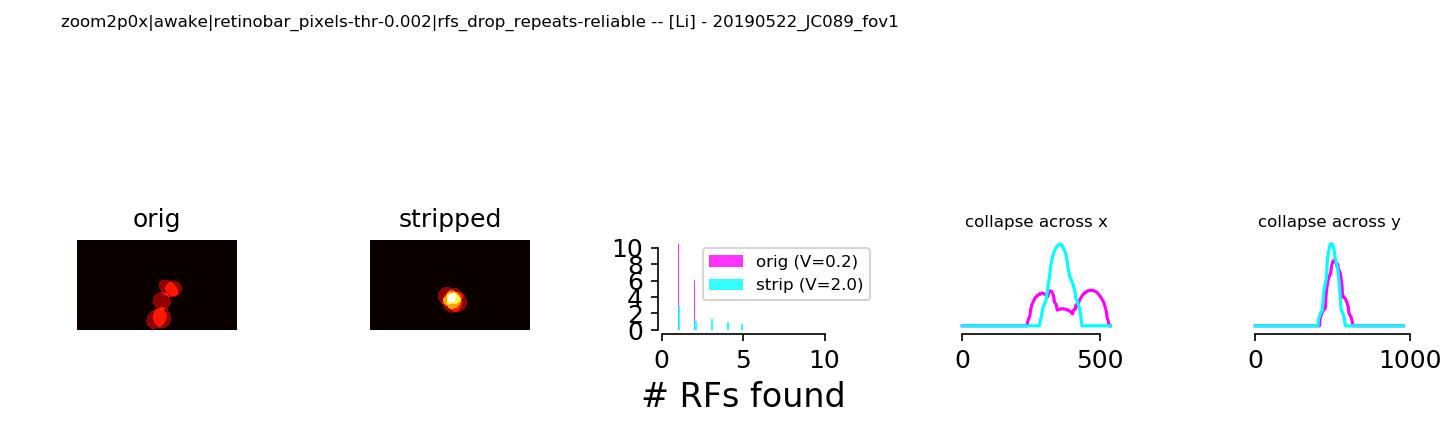

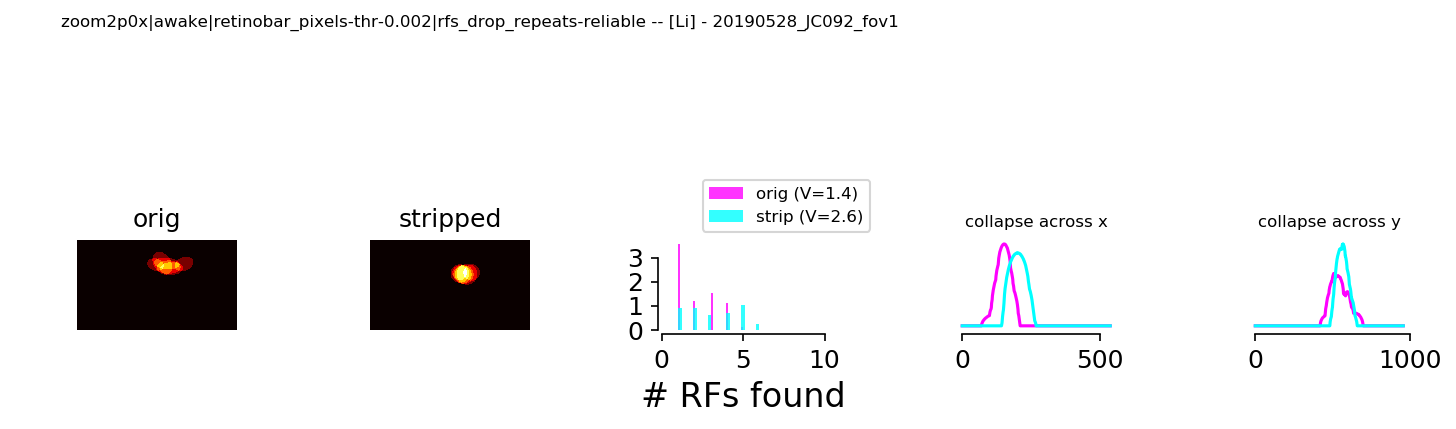

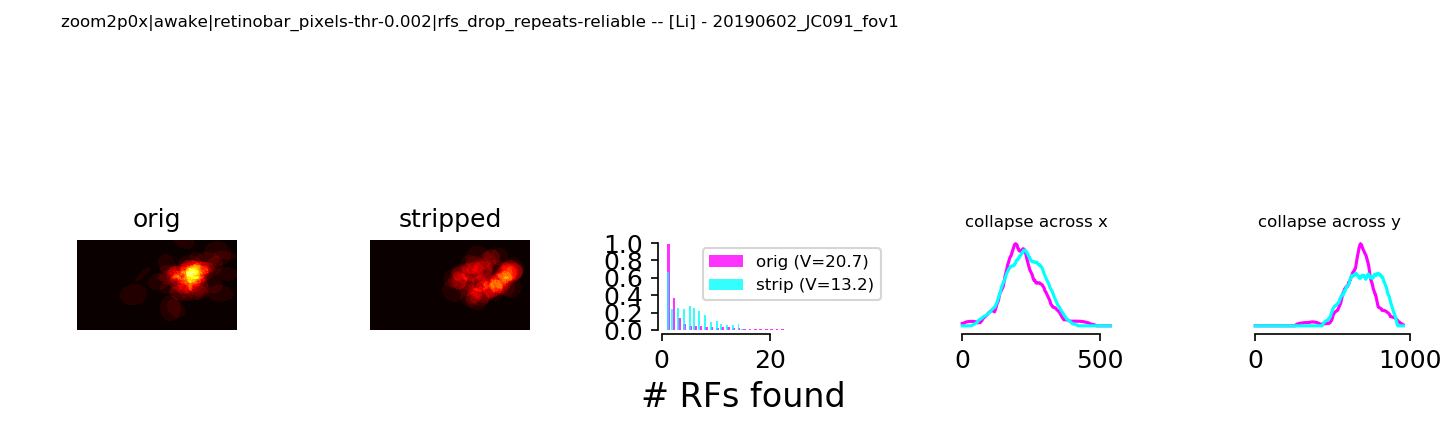

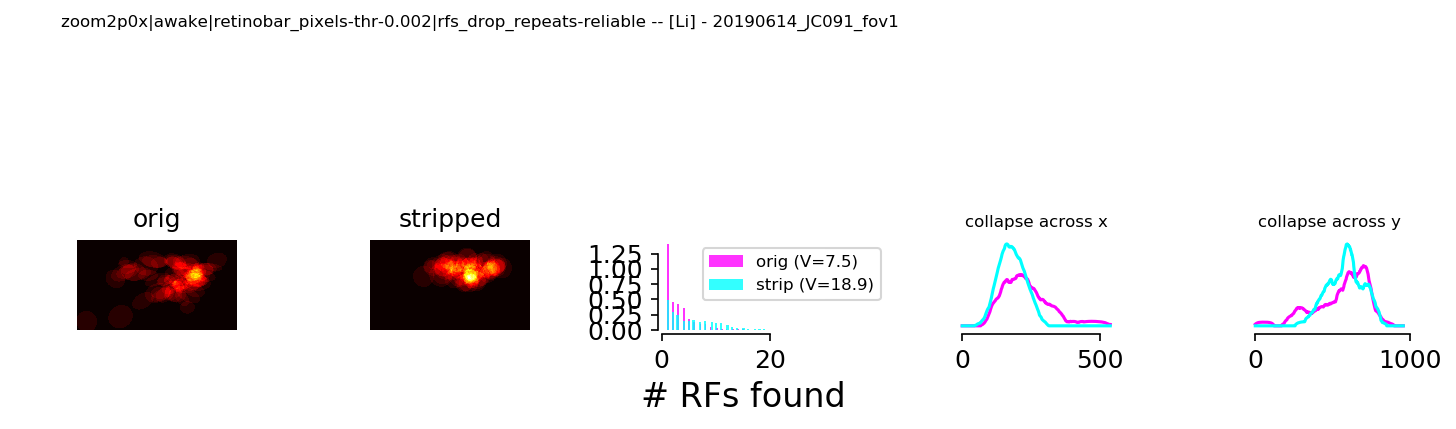

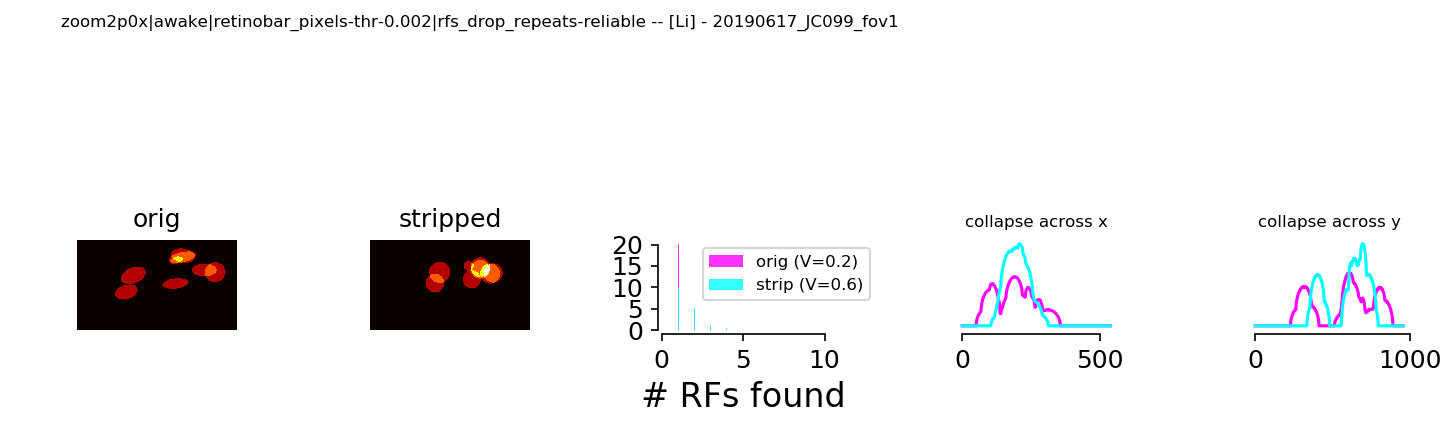

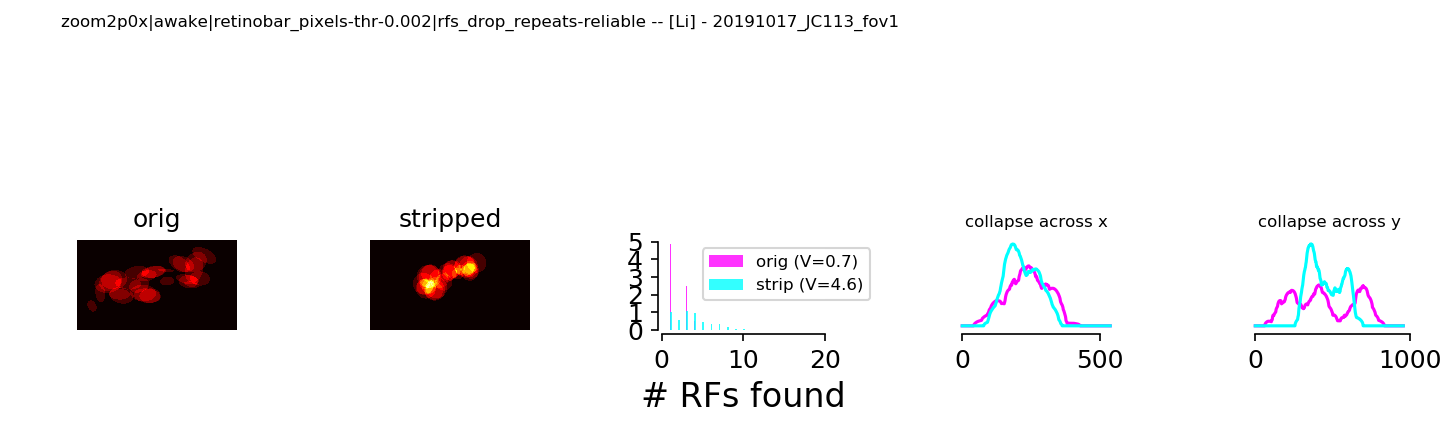

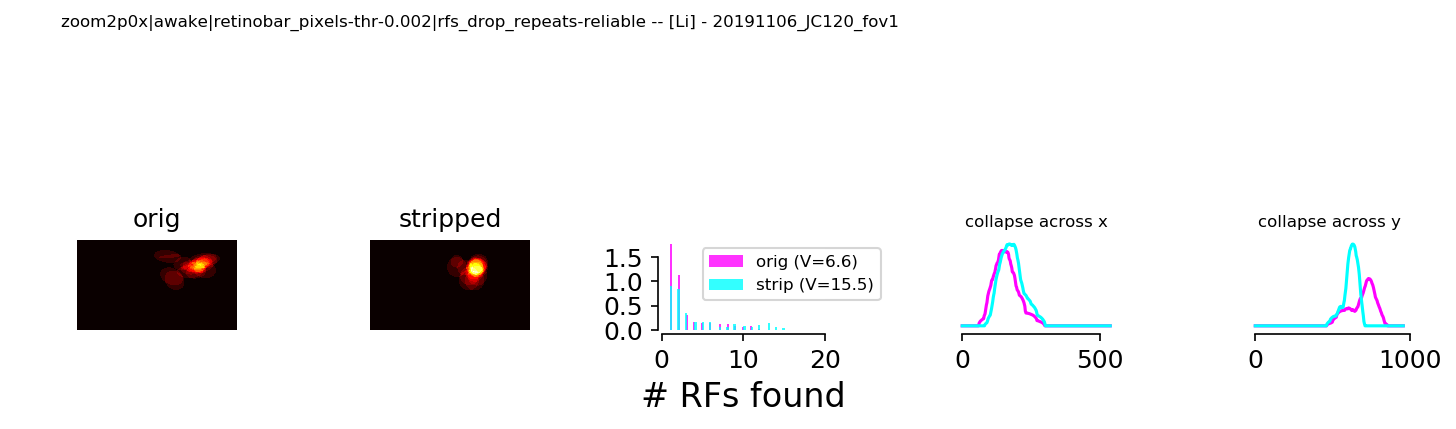

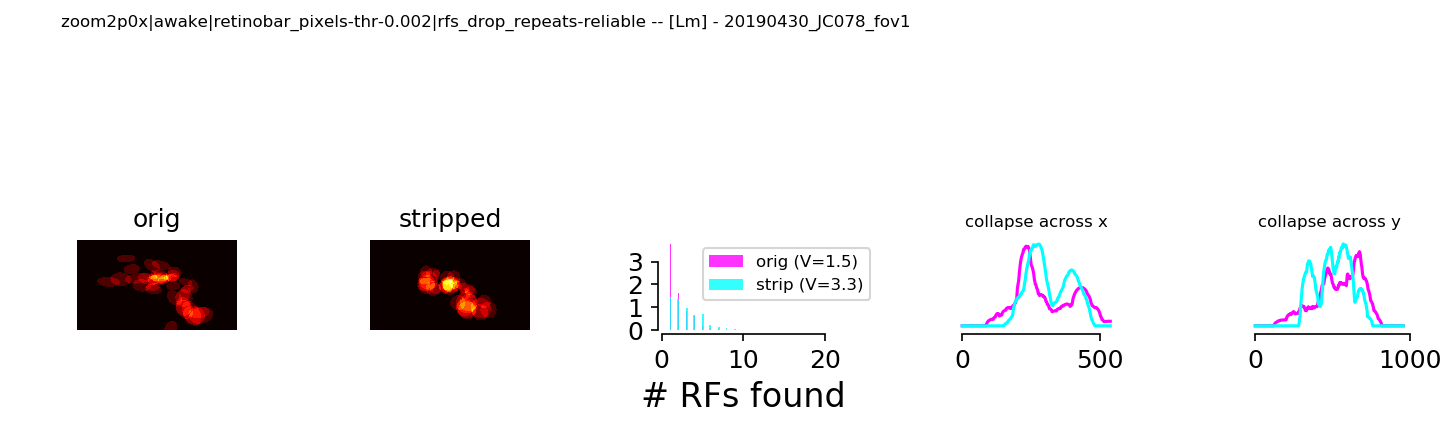

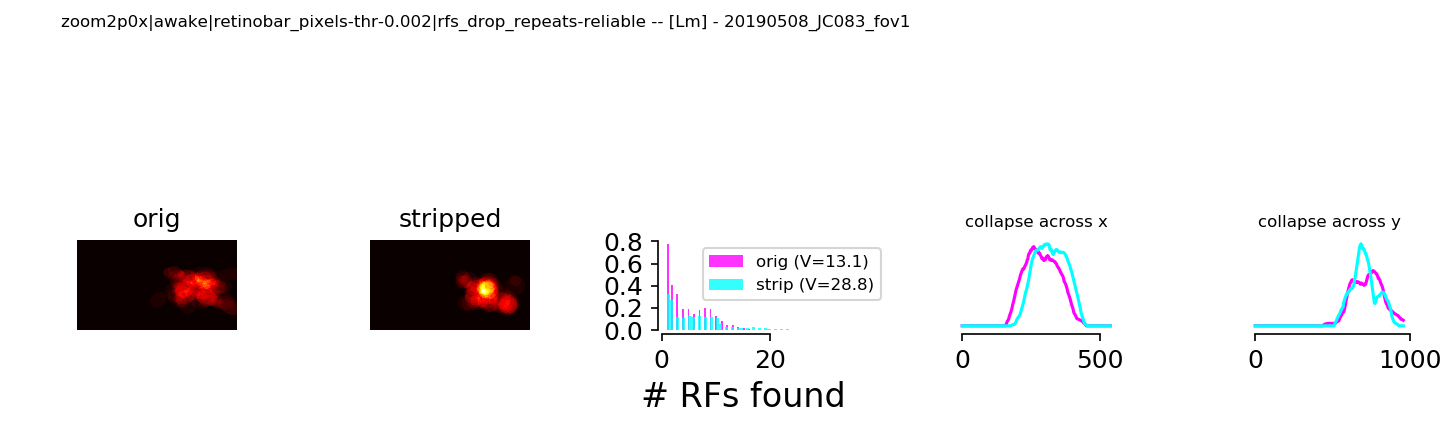

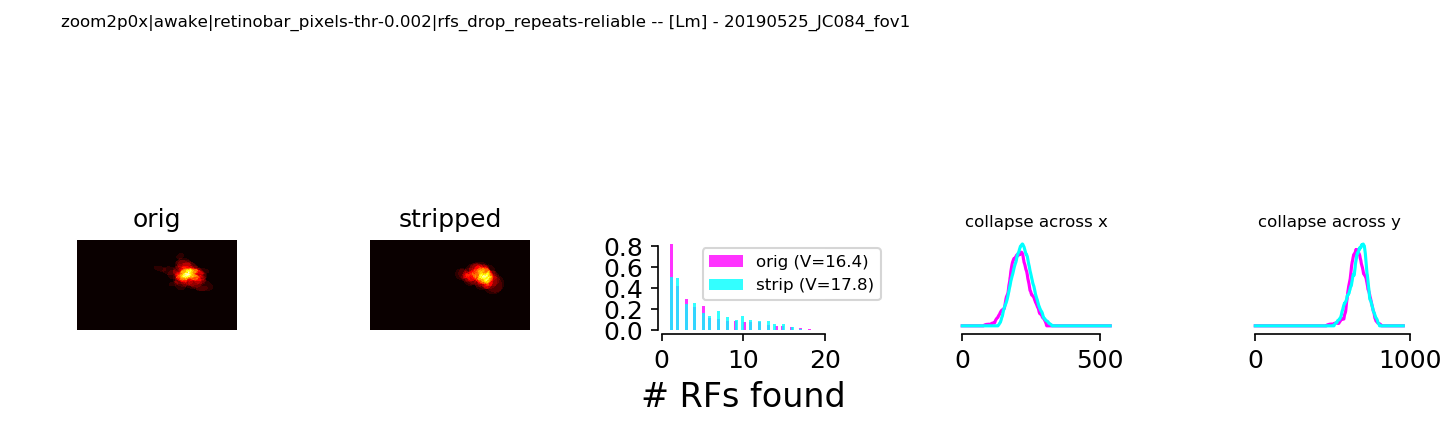

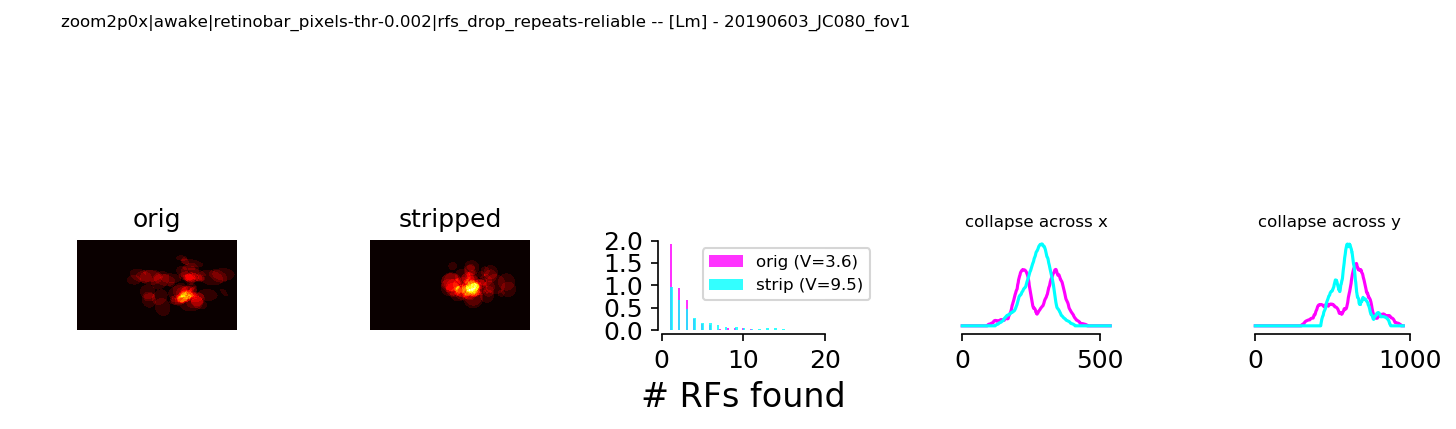

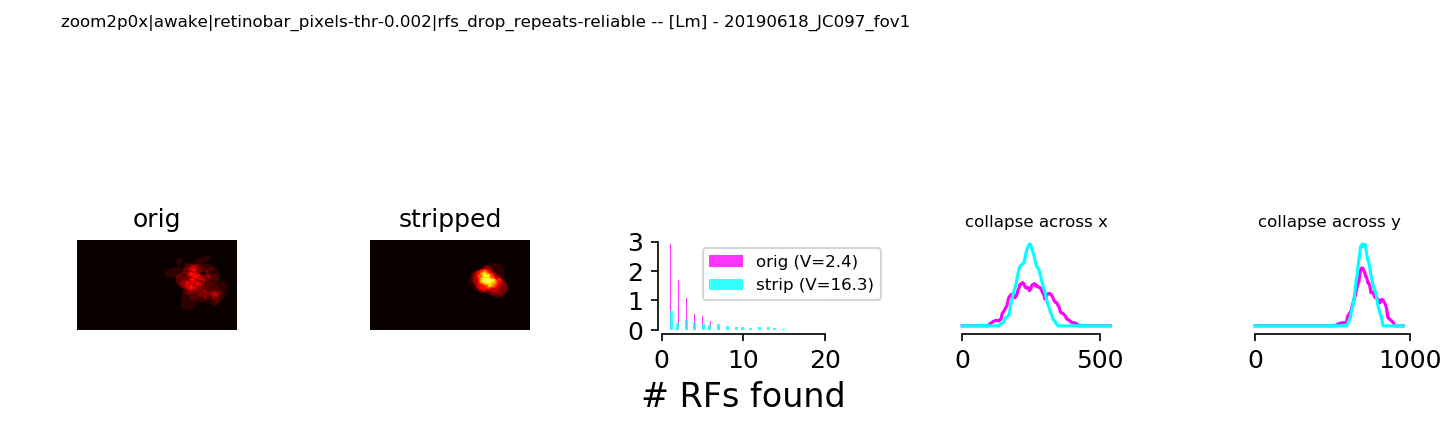

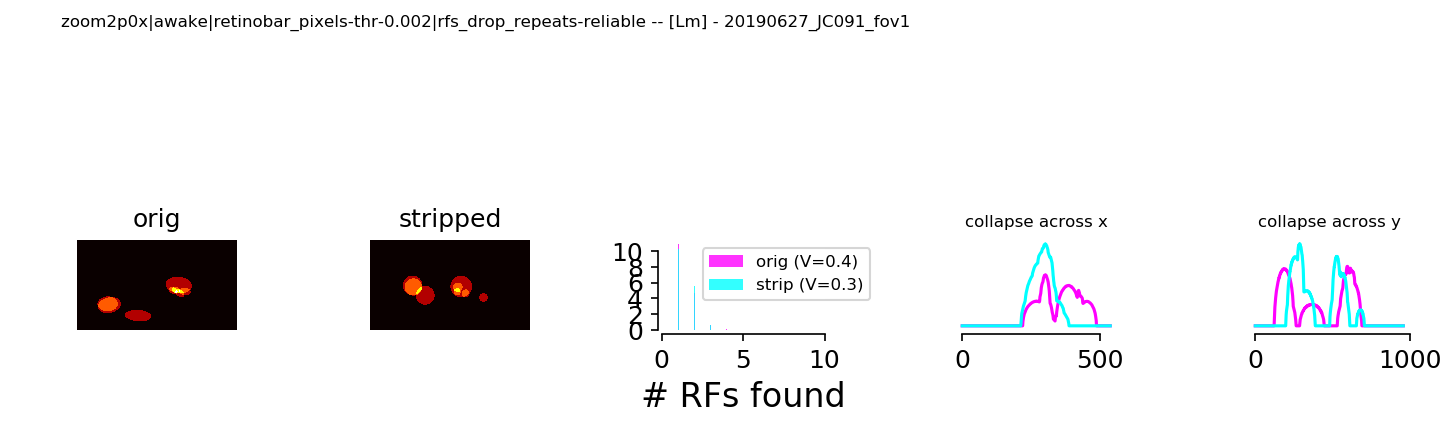

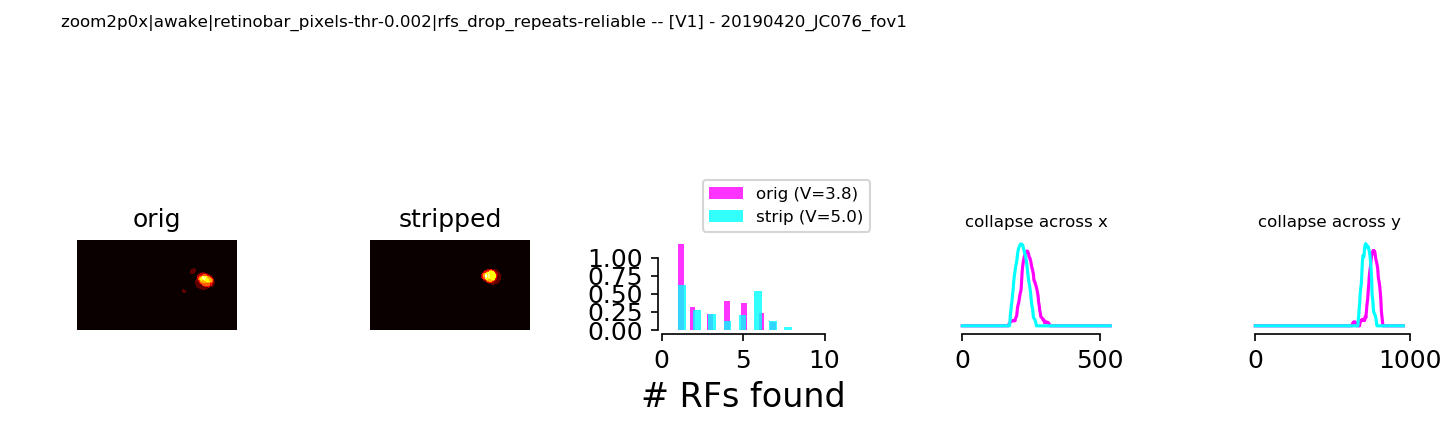

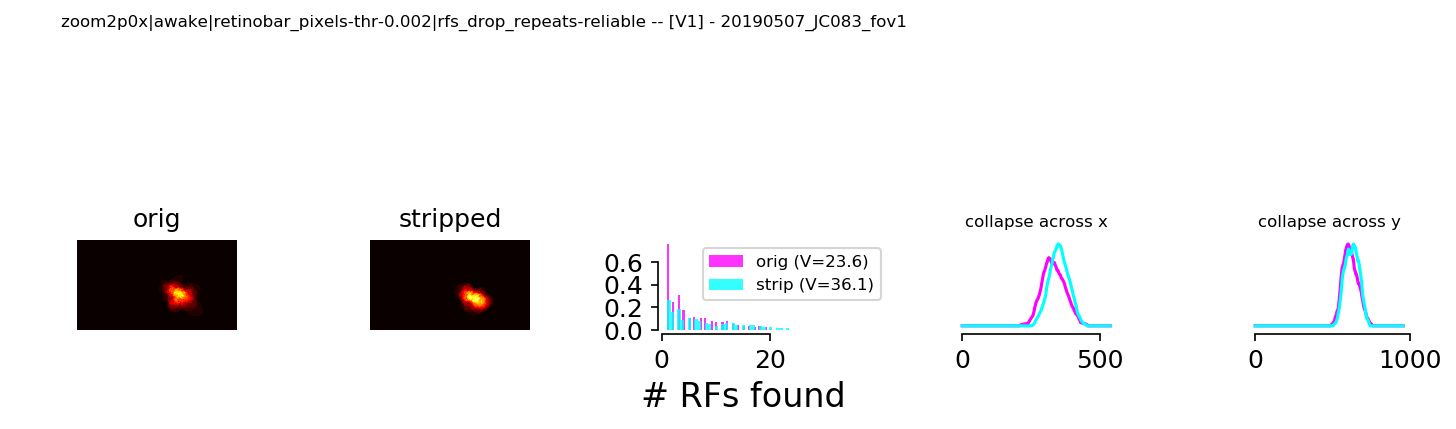

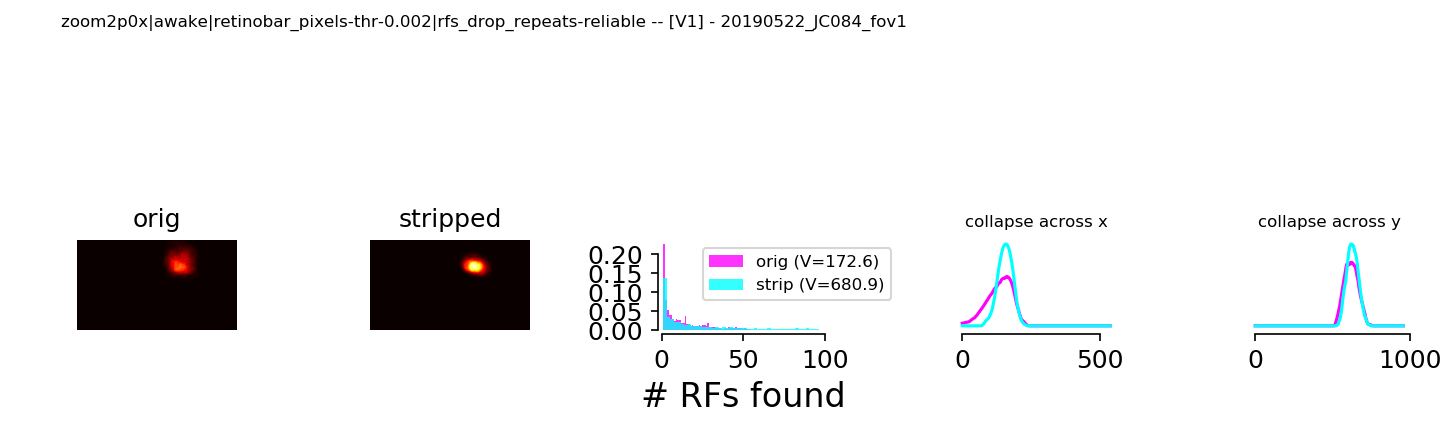

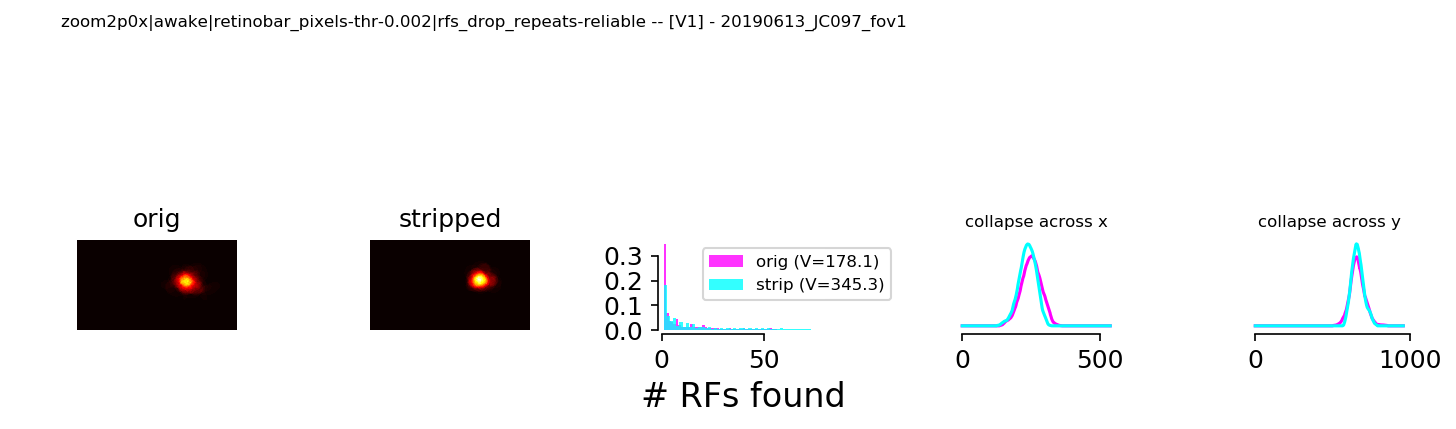

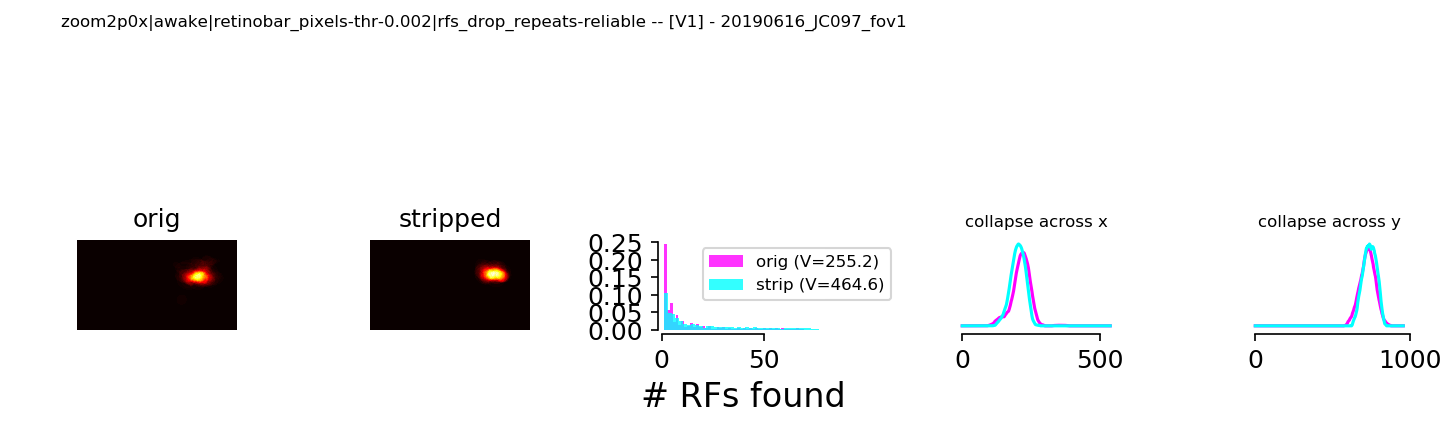

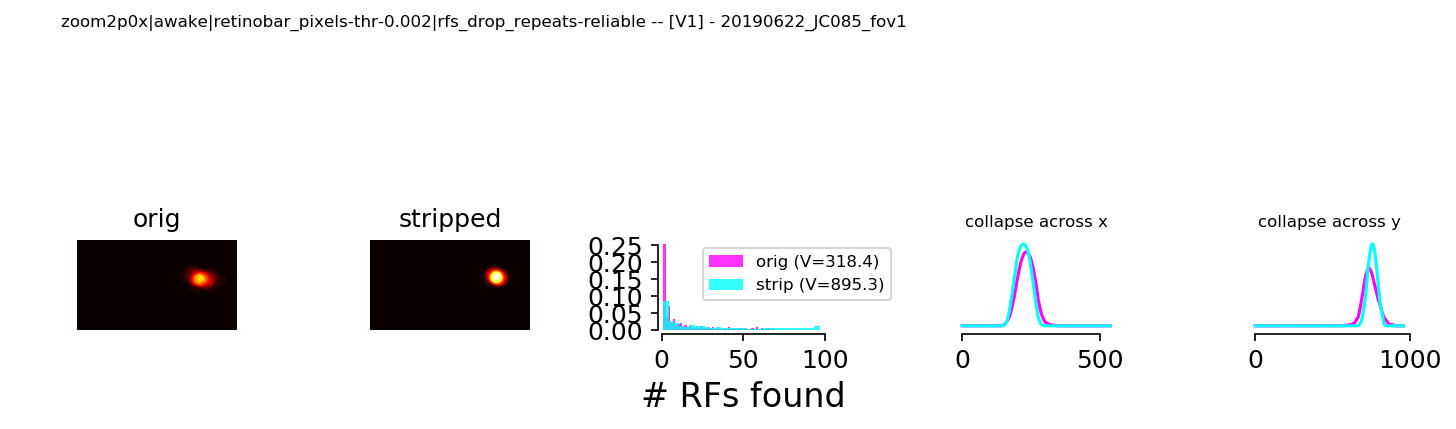

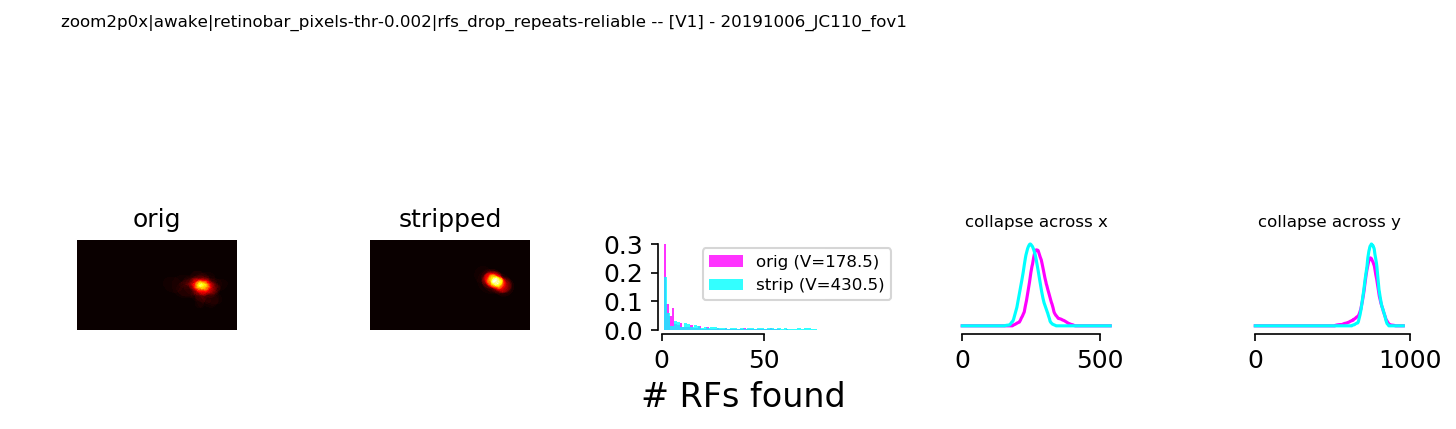

In [251]:
cmap='hot'
remove_zeros=True
cutoff=0
plot_by_fov=True

stripped_color='cyan'
orig_color ='magenta'

sz_metric = 'std' # rfs_to_polys() converts to fwhm
r_params = ['cell', '%s_x' % sz_metric, '%s_y' % sz_metric, 'theta', 'x0', 'y0']
print(r_params)

#datakey = '20190616_JC097_fov1'
d_ = []
for (visual_area, datakey, experiment), xdf in currdf.groupby(['visual_area', 'datakey', 'experiment']):
#xdf = currdf[currdf['datakey']==datakey].copy()
    curr_rfs = xdf[r_params].drop_duplicates().copy()

    # Convert to pixels for arry
    pixrfs = curr_rfs.apply(su.rfdf_deg_to_pix, size_name=sz_metric,
                            pix_per_deg=pix_per_deg_ds, resolution=screen_ds, axis=1)

    # Create stripped down RFs
    stripped = stripdown_rfdf(xdf, sz_metric=sz_metric)
    stripped_pixrfs = stripped.apply(su.rfdf_deg_to_pix, size_name=sz_metric,
                            pix_per_deg=pix_per_deg_ds, resolution=screen_ds, axis=1)

    # sum it up
    orig_summed = sum_rf_arrays(pixrfs, resolution=screen_ds)
    strip_summed = sum_rf_arrays(stripped_pixrfs, resolution=screen_ds)

    # Calculate variance over pixel values
    orig_vals, o_var = var_as_coverage(orig_summed, remove_zeros=remove_zeros)
    strip_vals, s_var = var_as_coverage(strip_summed, remove_zeros=remove_zeros)

    session, animalid, fov = datakey.split('_')
    tmpd = pd.DataFrame({'var': [o_var, s_var],
                         'std': [np.sqrt(o_var), np.sqrt(s_var)],
                         'cond': ['orig', 'stripped'],
                         'N': [len(curr_rfs), len(curr_rfs)],
                         'datakey': [datakey, datakey],
                         'animalid': [animalid, animalid],
                         'fov': [fov, fov],
                         'session': [session, session],
                         'experiment': [experiment, experiment],
                         'visual_area': [visual_area, visual_area]})
    d_.append(tmpd)

    if plot_by_fov:
        f =  plot_densities_as_sum(orig_summed, strip_summed, dpi=dpi, orig_color=orig_color, 
                               stripped_color=stripped_color, cutoff=cutoff, remove_zeros=remove_zeros)
        label_figure(f, '%s -- [%s] - %s' % (data_id, visual_area, datakey))
        pl.savefig(os.path.join(density_dir, '%s_%s_%s_2d-densities.svg' % (visual_area, datakey, experiment)))
    
variances = pd.concat(d_, axis=0).reset_index(drop=True)
print(variances.shape)
variances.head()

In [253]:
prefix

'all_filter-drop_repeats'

V1: (t-stat:-3.45, p=0.01)
Lm: (t-stat:-2.57, p=0.05)
Li: (t-stat:-2.17, p=0.07)
*****************
[('V1', 'Lm')] p=0.472 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.463 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.463 (fdr_bh), reject H0=False
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/drop_repeats/coverage_assigned', 'all_filter-drop_repeats__uniformity_of_coverage_std_fold_diff')


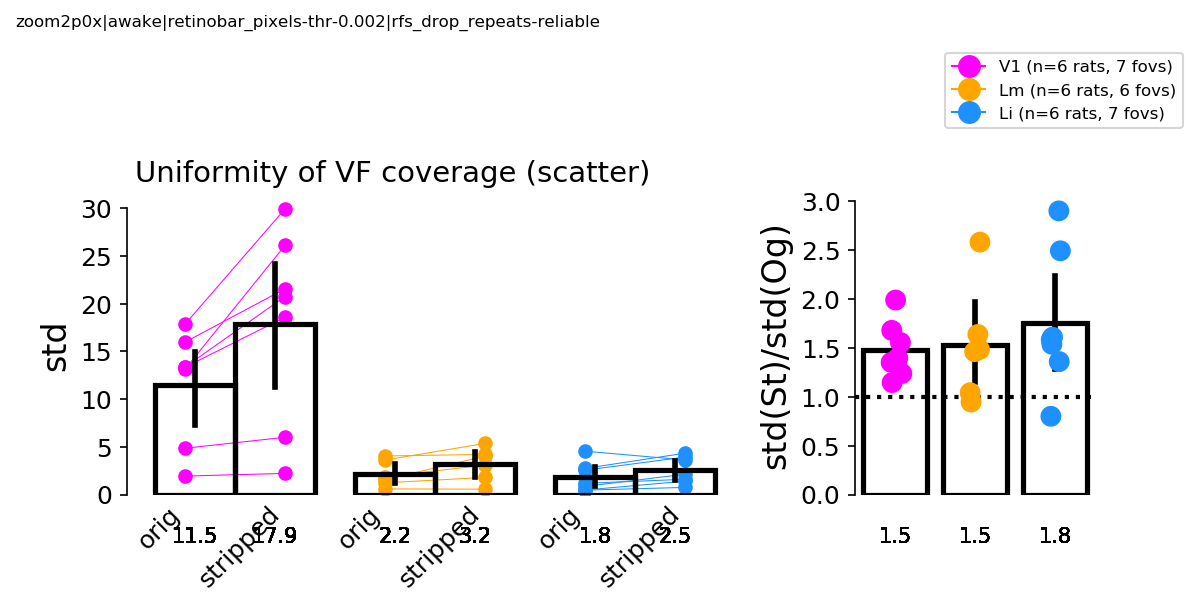

In [252]:
vmetric = 'std'

cond_palette = {'orig': orig_color, 'stripped': stripped_color}

f = pl.figure(figsize=(8,4), dpi=dpi)
#f.patch.set_alpha(0)
gs = gridspec.GridSpec(1,3) # f.add_gridspec(1, 3)

ax=f.add_subplot(gs[0:2]) #axn[0]
ax.set_title("Uniformity of VF coverage (scatter)", loc='left', fontsize=14)
#ax.patch.set_alpha(0)
ax = plot_pairwise_by_axis(variances, curr_metric=vmetric, c1='orig', c2='stripped',
                           area_colors=area_colors, fontsize=10, fontcolor='k', legend=False,
                           fmt='%.1f', xytext=(0, -20), label_rotation=45, ha='right', ax=ax)
change_width(ax, .4)
sns.despine(bottom=True, trim=True, ax=ax)


diff_metric = 'fold_diff'
ax=f.add_subplot(gs[2]) #axn[0]
d1 = variances[variances['cond']=='stripped']
d2 = variances[variances['cond']=='orig']
kcs = [c for c in d1.columns if c not in ['cond',vmetric]]
diffdf = d1[kcs].copy()
diffdf['fold_diff'] = d1[vmetric].values/d2[vmetric].values
diffdf['abs_diff'] = d1[vmetric].values - d2[vmetric].values

sns.stripplot(x='visual_area', y=diff_metric, hue='visual_area', data=diffdf, ax=ax,
              palette=area_colors, order=visual_areas, size=10)
ax.legend_.remove()
sns.barplot("visual_area", diff_metric, data=diffdf, ax=ax, #hue='experiment',
            order=visual_areas, errcolor="k", zorder=1, #hue_order=rfnames, 
           edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
ax.set_xlabel('')

if diff_metric=='fold_diff':
    ax.axhline(y=1.0, linestyle=':', color='k', lw=2)

# Annotate w stats
print("*****************")
diffdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f', xytext=(0, -20))
y_loc = 6
statresults = aggr.do_mannwhitney(diffdf, metric=diff_metric, multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax, y_loc=y_loc, offset=1)


# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(variances, area_colors=area_colors, markersize=10, marker='o')
ax.legend(handles=legend_elements, bbox_to_anchor=(1.4, 1.5), fontsize=8)
sns.despine(bottom=True, trim=True, ax=ax)
ax.set_xticks([])
if diff_metric == 'fold_diff':
    ax.set_ylabel('%s(St)/%s(Og)' % (vmetric,vmetric))
else:
    ax.set_ylabel('%s(St) - %s(Og)' % (vmetric,vmetric))


label_figure(f, data_id)
f.subplots_adjust(left=0.1, right=0.9, top=0.7, bottom=0.2, wspace=0.5)

figname = '%s__uniformity_of_coverage_%s_%s' % (prefix, vmetric, diff_metric)
pl.savefig(os.path.join(coverage_dir, '%s.svg' % figname))
print(coverage_dir, figname)

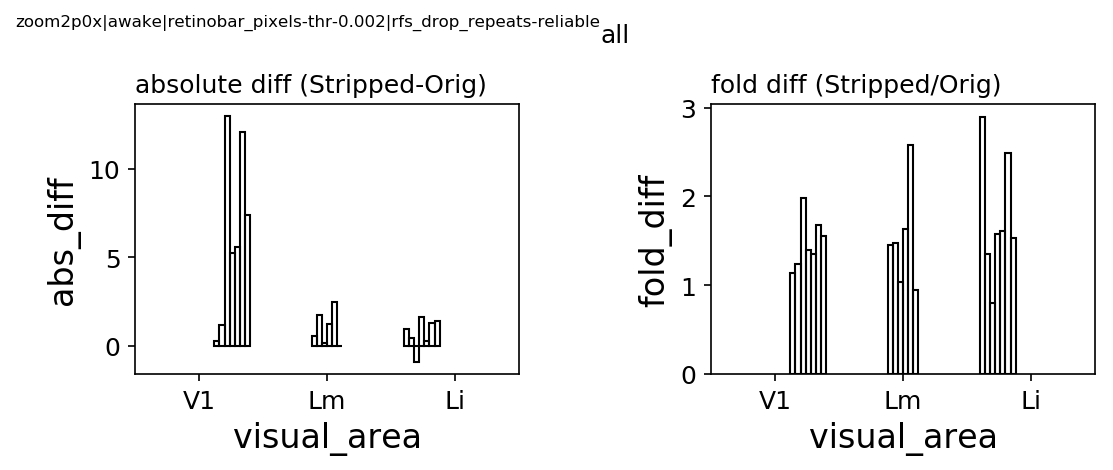

In [254]:
f, axn = pl.subplots(1,2, figsize=(8,3), dpi=dpi)
ax=axn[0]
sns.barplot(x="visual_area", y='abs_diff', data=diffdf, ax=ax,
           hue='datakey', order=visual_areas, errcolor="none",
           edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=1)
ax.legend_.remove()
ax.set_title('absolute diff (Stripped-Orig)', loc='left', fontsize=12)

ax=axn[1]
sns.barplot(x="visual_area", y='fold_diff', data=diffdf, ax=ax,
           hue='datakey', order=visual_areas, errcolor="none",
           edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=1)
ax.legend_.remove()
ax.set_title('fold diff (Stripped/Orig)', loc='left', fontsize=12)


pl.subplots_adjust(wspace=0.5, top=0.8, bottom=0.2, left=0.1)
f.suptitle(rfname)
putils.label_figure(f, data_id)

pl.savefig(os.path.join(coverage_dir, '%s__orig_v_noscatter_by_fov.svg' % prefix))

*****************
[('V1', 'Lm')] p=0.472 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.463 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.463 (fdr_bh), reject H0=False


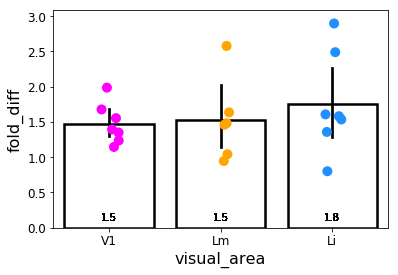

In [255]:
diff_metric = 'fold_diff'

multi_comp_test='fdr_bh'

f, ax = pl.subplots()
d1 = variances[variances['cond']=='stripped']
d2 = variances[variances['cond']=='orig']
kcs = [c for c in d1.columns if c not in ['cond', vmetric, diff_metric]]
sns.stripplot(x='visual_area', y=diff_metric, hue='visual_area', data=diffdf, ax=ax,
              palette=area_colors, order=visual_areas, size=10)
ax.legend_.remove()

sns.barplot("visual_area", diff_metric, data=diffdf, ax=ax, #hue='experiment',
            order=visual_areas, errcolor="k", #hue_order=rfnames, 
           edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)

# Annotate w stats
print("*****************")
diffdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f')
y_loc = 6
statresults = aggr.do_mannwhitney(diffdf, metric=diff_metric, multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax, y_loc=y_loc, offset=1)

In [307]:
alldf.head()

r2     fwhm_x     fwhm_y     theta         x0         y0 animalid  \
0  0.826039  23.640365  13.125770  0.117896   6.700889  -8.282818    JC076   
1  0.725070  43.796452  29.207447  0.234407 -22.165338  -2.970096    JC076   
2  0.701576  47.503138  24.790225  0.458457  15.301437  31.251545    JC076   
3  0.781400  23.130716  44.809417  0.155088   2.496442  37.699467    JC076   
4  0.627347  32.132070  25.065036  5.892774   0.014677  17.244112    JC076   

   cell              datakey experiment   ...      fwhm_avg    std_avg  \
0     0  20190502_JC076_fov1        rfs   ...     18.383068   7.822582   
1    84  20190502_JC076_fov1        rfs   ...     36.501949  15.532744   
2   115  20190502_JC076_fov1        rfs   ...     36.146682  15.381567   
3   120  20190502_JC076_fov1        rfs   ...     33.970067  14.455348   
4   135  20190502_JC076_fov1        rfs   ...     28.598553  12.169597   

         area  datakey_ix  fov_xpos  fov_xpos_pix  fov_ypos  fov_ypos_pix  \
0  176.519678           0   85.2665            37   218.928           115   
1  727.690433           0   638.347           277   605.382           318   
2  669.910720           0   1034.72           449   788.139           414   
3  589.620427           0   956.368           415   761.487           400   
4  458.164233           0   1115.38           484   740.546           389   

    ml_pos   ap_pos  
0  753.872  1092.33  
1  367.418  539.253  
2  184.661  142.879  
3  211.313  221.232  
4  232.254  62.2215  

[5 rows x 25 columns]

In [305]:


with open(df_fpath, 'rb') as f:
    t_ = pkl.load(f)
alldf = t_['df']

scatdf_all = get_scatter_df(alldf, screen=screen, min_ncells=min_ncells)
print(scatdf_all.shape)
scatdf_all.head()


--- bad gradient, 20190502_JC076_fov1
--- too few cells (min5), 20190522_JC089_fov1


KeyError: 'ml_proj'

['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/drop_repeats/coverage_assigned', '20190614_JC091_fov1')


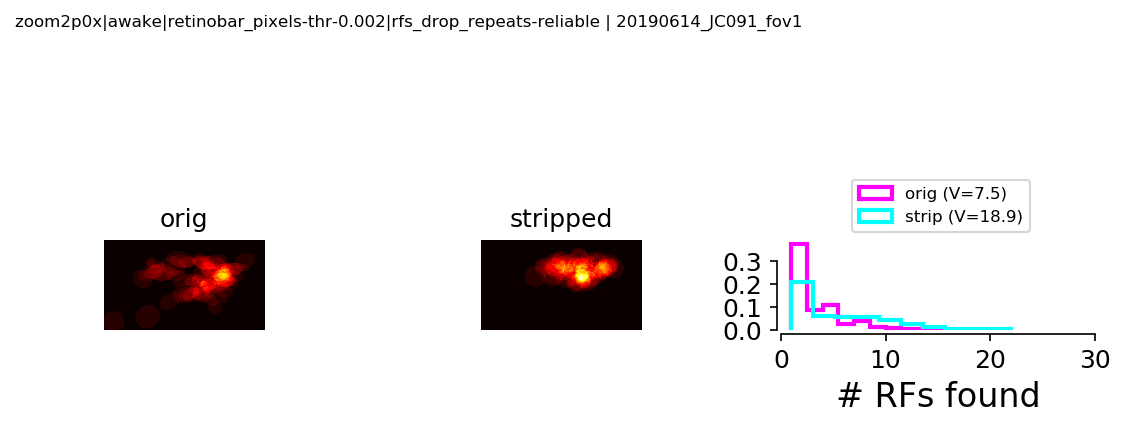

In [325]:
sz_metric = 'std' # rfs_to_polys() converts to fwhm
r_params = ['cell', '%s_x' % sz_metric, '%s_y' % sz_metric, 'theta', 'x0', 'y0']
print(r_params)

#datakey = '20190616_JC097_fov1' #'20190527_JC092_fov3' #'20190616_JC097_fov1'
datakey = '20190614_JC091_fov1'
xdf =scatdf[scatdf['datakey']==datakey]
xdf.shape
curr_rfs = xdf[r_params].drop_duplicates().copy()

# Convert to pixels for arry
pixrfs = curr_rfs.apply(su.rfdf_deg_to_pix, size_name=sz_metric,
                        pix_per_deg=pix_per_deg_ds, resolution=screen_ds, axis=1)

# Create stripped down RFs
stripped = stripdown_rfdf(xdf, sz_metric=sz_metric)
stripped_pixrfs = stripped.apply(su.rfdf_deg_to_pix, size_name=sz_metric,
                        pix_per_deg=pix_per_deg_ds, resolution=screen_ds, axis=1)

# sum it up
orig_summed = sum_rf_arrays(pixrfs, resolution=screen_ds)
strip_summed = sum_rf_arrays(stripped_pixrfs, resolution=screen_ds)

# Calculate variance over pixel values
orig_vals, o_var = var_as_coverage(orig_summed, remove_zeros=remove_zeros)
strip_vals, s_var = var_as_coverage(strip_summed, remove_zeros=remove_zeros)


vmax=max([orig_summed.max(), strip_summed.max()])
vmin = 0

f, axf = pl.subplots(1, 3, figsize=(8,3), dpi=dpi)
axn=axf.flat

ax=axn[0]
ax.imshow(orig_summed, cmap=cmap, vmin=0, vmax=vmax)
ax.axis('off')
ax.set_title('orig')

ax=axn[1]
ax.imshow(strip_summed, cmap=cmap, vmin=0, vmax=vmax)
ax.axis('off')
ax.set_title('stripped')


ax=axn[2]
ax.set_xlabel('# RFs found')
orig_vals, o_var = var_as_coverage(orig_summed, cutoff=cutoff, remove_zeros=remove_zeros)
strip_vals, s_var = var_as_coverage(strip_summed, cutoff=cutoff, remove_zeros=remove_zeros)

sns.distplot(orig_vals, kde=False, norm_hist=True, label='orig (V=%.1f)' % o_var, 
             hist='step', ax=ax, 
             hist_kws={"histtype": "step",'alpha': 1, 'linewidth':2, 'color': orig_color}, bins=10)

sns.distplot(strip_vals, kde=False, norm_hist=True,  label='strip (V=%.1f)' % s_var, 
             hist='step', ax=ax, 
             hist_kws={"histtype": "step", 'alpha': 1, 'linewidth': 2, 'color': stripped_color}, bins=10)

if len(orig_vals)>0:
    xlim = max(orig_vals.max(), strip_vals.max())
    xlim = xlim - (xlim%10) + 10.
    ax.set_xlim([0, xlim])
ax.legend(bbox_to_anchor=(0.2,1), fontsize=8)
sns.despine(ax=ax, trim=True, offset=2)

pl.subplots_adjust(top=0.5, wspace=0.2, bottom=0.3, left=0.01, hspace=0.8)
putils.label_figure(f, '%s | %s' % (data_id, datakey))

pl.savefig(os.path.join(coverage_dir, 'example_coverage_%s.svg' % datakey))
print(coverage_dir, datakey)

In [322]:
coverage_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/drop_repeats/coverage_assigned'

In [321]:
dst_dir

NameError: name 'dst_dir' is not defined

Text(0.5,0.98,u'var: orig=2.51, stripped=3.17')

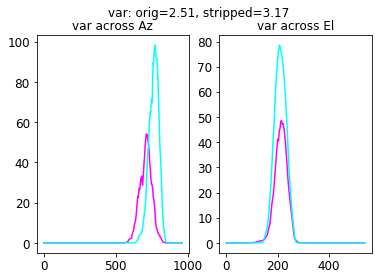

In [474]:
var = np.sqrt(np.var(orig_summed, ddof=1, dtype=np.float64))
var2 = np.sqrt(np.var(strip_summed, ddof=1, dtype=np.float64))

var_az = np.var(orig_summed, axis=0)
var_az2 = np.var(strip_summed, axis=0)

var_el = np.var(orig_summed, axis=1)
var_el2 = np.var(strip_summed, axis=1)

f, axn = pl.subplots(1,2)

ax=axn[0]; ax.set_title('var across Az');
ax.plot(var_az, color=orig_color)
ax.plot(var_az2, color=stripped_color)

ax=axn[1]; ax.set_title('var across El');
ax.plot(var_el, color=orig_color)
ax.plot(var_el2, color=stripped_color)

f.suptitle("var: orig=%.2f, stripped=%.2f" % (var, var2))

In [500]:
orig_vals, o_var = var_as_coverage(orig_summed, remove_zeros=True)
strip_vals, s_var = var_as_coverage(strip_summed, remove_zeros=True)

# vec = strip_summed.copy()
# vec[strip_summed==0] = np.nan
# d2 = pd.DataFrame({'values': vec.ravel()}).dropna().values

# v2 = np.sum(abs(d2 - np.mean(d2)**2)) / len(d)
# print(np.var(strip_summed.ravel()), np.var(d2, ddof=1), v2)

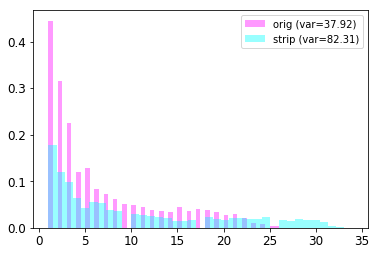

In [502]:
f, ax = pl.subplots()
sns.distplot(orig_vals, kde=False, norm_hist=True, color=orig_color, label='orig (var=%.2f)' % o_var, 
             hist='step')
sns.distplot(strip_vals, kde=False, norm_hist=True, color=stripped_color, label='strip (var=%.2f)' % s_var, 
             hist='step')
ax.legend()

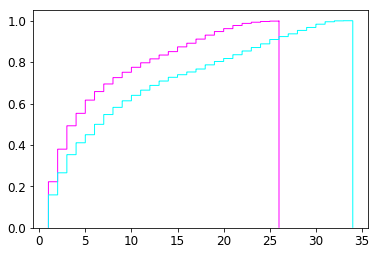

In [503]:
f, ax = pl.subplots()
# pl.hist(d, cdf=True,color=orig_color, label='orig (var=%.2f)' % v1)
# sns.distplot(d2, color=stripped_color, label='strip (var=%.2f)' % v2)

# plot the cumulative histogram
n_bins=len(d)
n, bins, patches = ax.hist(d, n_bins, density=True, histtype='step',
                           cumulative=True, label='orig', color=orig_color)

# Add a line showing the expected distribution.
# y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
#      np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
# y = y.cumsum()
# y /= y[-1]

#ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')


n_bins=len(d2)
n, bins, patches = ax.hist(d2, n_bins, density=True, histtype='step',
                           cumulative=True, label='strip', color=stripped_color)

In [416]:
len(d), len(d2)

(68923, 46468)

In [378]:
np.nanmin(vec), np.nanmax(vec)

(0.72351436796472712, 9.551202873123664)

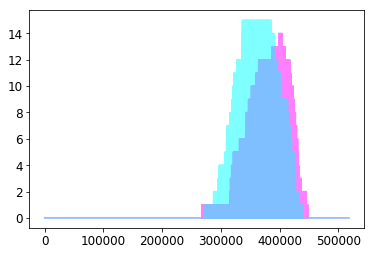

In [212]:
f, ax = pl.subplots()
ax.plot(orig_summed.ravel(), color=orig_color, alpha=0.5)
ax.plot(strip_summed.ravel(), color=stripped_color, alpha=0.5)



In [880]:
scatdf_mixed[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

V1    8
Li    5
Lm    2
Name: visual_area, dtype: int64

In [881]:
rfdf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

V1    8
Li    6
Lm    4
Name: visual_area, dtype: int64

In [341]:

# d_list=[]
# for (visual_area, datakey), sg in scatdf_mixed.groupby(['visual_area', 'datakey']):

#     el_scatter = sg[sg['axis']=='el'][['cell', 'deg_scatter']]
#     az_scatter = sg[sg['axis']=='az'][['cell', 'deg_scatter']]
    
#     common_cells = np.intersect1d(el_scatter['cell'].unique(), az_scatter['cell'].unique())
#     d1 = sg[(sg['cell'].isin(common_cells)) & (sg['axis']=='el')][['cell', 'deg_scatter']].rename(columns={'deg_scatter': 'deg_scatter_el'})
#     d2 = sg[(sg['cell'].isin(common_cells)) & (sg['axis']=='az')][['cell', 'deg_scatter']].rename(columns={'deg_scatter': 'deg_scatter_az'})
#     curr_scatter = pd.merge(d1, d2).sort_values(by='cell').mean(axis=1).values
    
#     rfs_ = mixdf[(mixdf['datakey']==datakey) 
#                     & (mixdf['cell'].isin(common_cells))].copy()    
#     curr_sizes = rfs_.sort_values(by='cell')[sz_param].values
    
#     df_ = pd.DataFrame({'deg_scatter': curr_scatter,
#                         'rf_size': curr_sizes,
#                         'cell': common_cells})
#     metadict = {'visual_area': visual_area, 'datakey': datakey}
#     df_ = putils.add_meta_to_df(df_, metadict)
#     d_list.append(df_)
    
#     pearson_r, pearson_p = spstats.pearsonr(curr_sizes, curr_scatter)
#     print("[%s] %s (%s): r=%.2f (p=%.2f)" % (visual_area, datakey, rfname, pearson_r, pearson_p))
    
# avg_scatter_mix = pd.concat(d_list, axis=0)
# print(d_list[0].shape, avg_scatter_mix.shape)



#scatter_cond='avg'
#sz_param = 'std_avg' # if scatter_cond=='az' else 'fy'

#fig, axn = pl.subplots(1, 3, figsize=(8, 4), sharex=True, sharey=True)

d_list=[]
for (visual_area, datakey), sg in scatdf_mixed.groupby(['visual_area', 'datakey']):
    ai = visual_areas.index(visual_area)
    #ax = axn[ai]

    el_scatter = sg[sg['axis']=='el'][['cell', 'deg_scatter']]
    az_scatter = sg[sg['axis']=='az'][['cell', 'deg_scatter']]
    common_cells = np.intersect1d(el_scatter['cell'].unique(), az_scatter['cell'].unique())
    d1 = sg[(sg['cell'].isin(common_cells)) & (sg['axis']=='el')][['cell', 'deg_scatter']].rename(columns={'deg_scatter': 'deg_scatter_el'})
    d2 = sg[(sg['cell'].isin(common_cells)) & (sg['axis']=='az')][['cell', 'deg_scatter']].rename(columns={'deg_scatter': 'deg_scatter_az'})

    curr_scatter = pd.merge(d1, d2) #, axis=1)
    curr_scatter['deg_scatter_mean'] = curr_scatter[['deg_scatter_el', 'deg_scatter_az']].mean(axis=1)

    rfs_ = mixdf[(mixdf['datakey']==datakey) 
                    & (mixdf['cell'].isin(curr_scatter['cell'].unique()))].copy()    
    df_ = pd.merge(rfs_, curr_scatter)
    d_list.append(df_)
    
avg_scatter_mix = pd.concat(d_list, axis=0)
print(d_list[0].shape, avg_scatter_mix.shape)

((20, 40), (210, 40))


In [342]:
avg_scatter_mix.columns

Index([u'r2', u'fwhm_x', u'fwhm_y', u'theta', u'x0', u'y0', u'animalid',
       u'cell', u'datakey', u'experiment', u'fovnum', u'session',
       u'visual_area', u'std_x', u'std_y', u'fwhm_avg', u'std_avg', u'area',
       u'fx', u'fy', u'ratio_xy', u'theta_c', u'theta_Mm_deg', u'major_axis',
       u'minor_axis', u'anisotropy', u'theta_Mm_c', u'aniso_index',
       u'datakey_ix', u'fov_xpos', u'fov_xpos_pix', u'fov_ypos',
       u'fov_ypos_pix', u'ml_pos', u'ap_pos', u'ml_proj', u'ap_proj',
       u'deg_scatter_el', u'deg_scatter_az', u'deg_scatter_mean'],
      dtype='object')

In [343]:
avg_scatter_mix['proj_size_mean'] = avg_scatter_mix[['fx', 'fy']].mean(axis=1)

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/scatter', 'scatter_v_projsize-along-ax_averages__mixed')


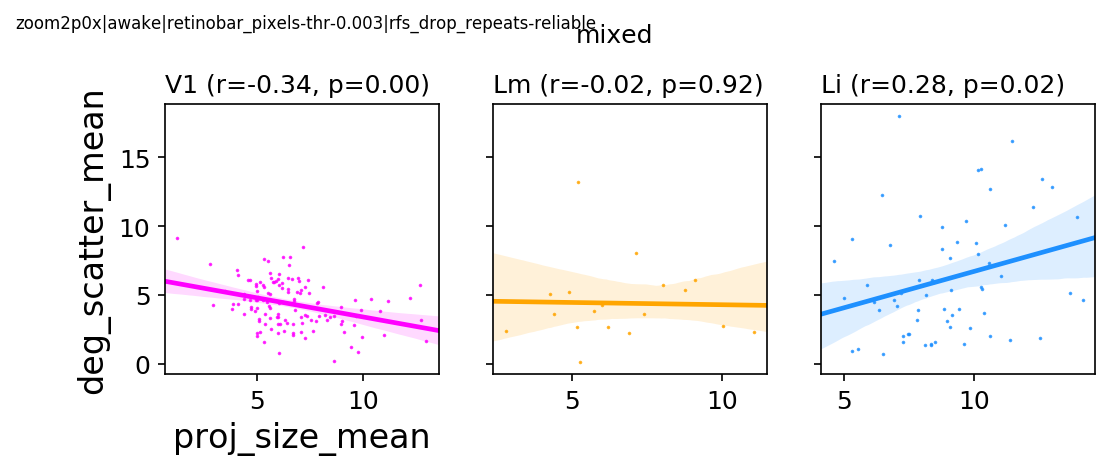

In [347]:
rf_size = 'proj_size_mean'
deg_scatter = 'deg_scatter_mean'
fig, axn = pl.subplots(1, 3, figsize=(8,3), dpi=dpi, sharey=True, sharex=False)
for ax, (visual_area, g) in zip(axn.flat[::-1], avg_scatter_mix.groupby(['visual_area'])):
    sns.regplot(rf_size, deg_scatter, color=area_colors[visual_area], data=g, ax=ax,
               marker='.', scatter_kws={'s':2})
    r, p = spstats.pearsonr(g[rf_size].values, g[deg_scatter].values)
    ax.set_title('%s (r=%.2f, p=%.2f)' % (visual_area, r, p), loc='left')
pl.subplots_adjust(wspace=0.2, top=0.8, bottom=0.2)

putils.label_figure(fig, data_id)
fig.suptitle("%s" % rfname)

for ax in axn[1:]:
    ax.set_ylabel('')
    ax.set_xlabel('')

figname = 'scatter_v_projsize-along-ax_averages__%s' % rfname
pl.savefig(os.path.join(basedir, '%s.svg' % figname))
print(basedir, figname)

In [334]:
rfname

'rfs10'

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/scatter', 'scatter_v_projsize-along-ax_avg-by-FOV__mixed')


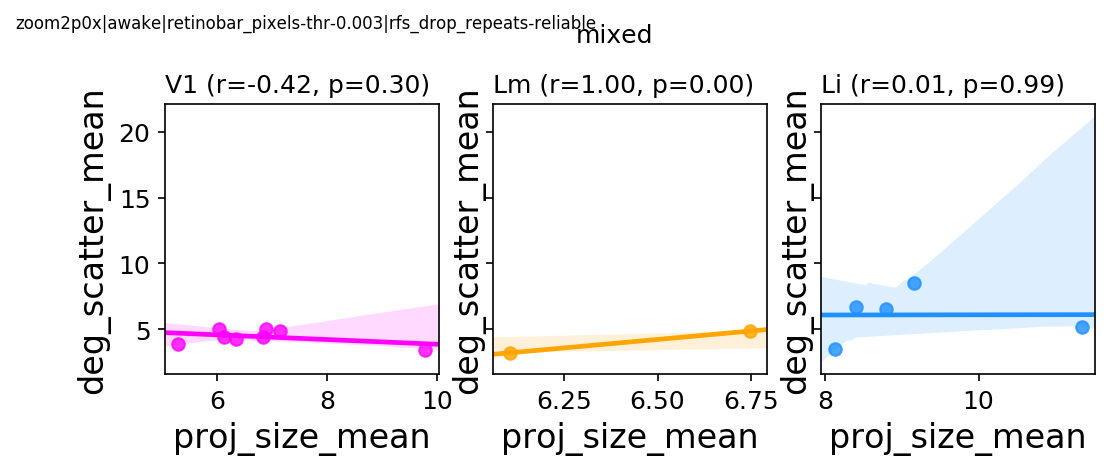

In [346]:
means_mix = avg_scatter_mix.groupby(['visual_area', 'datakey']).mean().reset_index()


fig, axn = pl.subplots(1, 3, figsize=(8,3), dpi=dpi, sharey=True, sharex=False)
for ax, (visual_area, g) in zip(axn.flat[::-1], means_mix.groupby(['visual_area'])):
    sns.regplot(rf_size, deg_scatter, color=area_colors[visual_area], data=g, ax=ax)
    r, p = spstats.pearsonr(g[rf_size].values, g[deg_scatter].values)
    ax.set_title('%s (r=%.2f, p=%.2f)' % (visual_area, r, p), loc='left')
    
pl.subplots_adjust(wspace=0.2, top=0.8, bottom=0.2)
putils.label_figure(fig, data_id)
fig.suptitle(rfname)


figname = 'scatter_v_projsize-along-ax_avg-by-FOV__%s' % rfname
pl.savefig(os.path.join(basedir, '%s.svg' % figname))
print(basedir, figname)

********* [std_avg] *********
[('V1', 'Lm')] p=0.018 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.000 (fdr_bh), reject H0=True
********* [deg_scatter] *********
[('V1', 'Lm')] p=0.000 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.000 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.001 (fdr_bh), reject H0=True
rfsize_v_degscatter_plot-cells_avg-conds_fdr_bh__rfs-drop_repeats_retino-R2-0.75-both


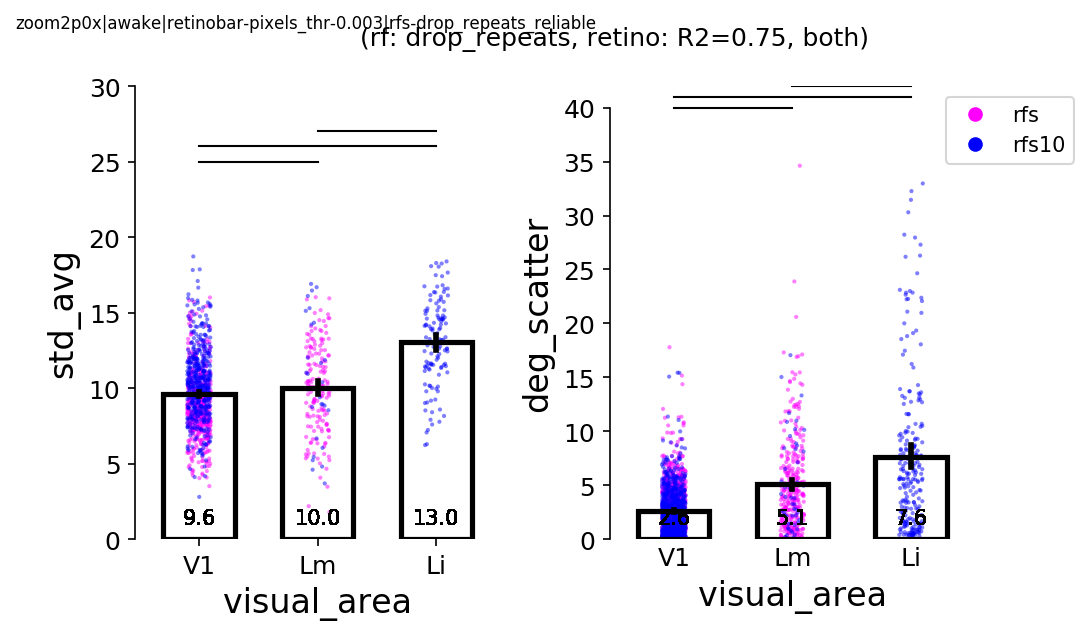

In [343]:
plot_cells=True
rfcolors = ['magenta', 'blue']
rfnames = ['rfs', 'rfs10']
rfcolor_dict = dict((k, v) for k, v in zip(rfnames, rfcolors))
multi_comp_test='fdr_bh'
marker_size = 2 if plot_cells else 10


plot_str = 'plot-cells' if plot_cells else 'plot-fov-means'

#plotdf = scatdf[scatdf['retino_R2']>retino_thr].copy()

#plot_str = '' if plot_cells else 'fovmeans'
plotdf = curr_rfs.copy()
meandf = curr_rfs.groupby(['visual_area', 'datakey', 'experiment']).mean().reset_index()

#fig, axn = pl.subplots(1,2, figsize=(12,4))
#for ax, plotter in zip(axn.flat, ['dist_scatter', 'deg_scatter']):
fig, axn = pl.subplots(1, 2, figsize=(8,4), dpi=dpi, sharey=plot_cells==False)
if plot_cells:
    xdf = plotdf.copy()
else:
    xdf = meandf.copy()
    
plotter='std_avg'
ax=axn[0]
sns.barplot("visual_area", plotter, data=xdf, ax=ax, #hue='experiment',
            order=visual_areas, errcolor="k", hue_order=rfnames, 
           edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
change_width(ax, .6)

sns.stripplot(x='visual_area', y=plotter, data=xdf[xdf['experiment']=='rfs'], #hue='experiment',
              dodge=True, ax=ax, size=marker_size, zorder=0, facecolor=[0, 0, 0, 0, 0, 0], hue_order=rfnames,
             color=rfcolor_dict['rfs'], alpha=0.5, order=['V1', 'Lm', 'Li'])
sns.stripplot(x='visual_area', y=plotter, data=xdf[xdf['experiment']=='rfs10'], #hue='experiment',
              dodge=True, ax=ax, size=marker_size, zorder=0, facecolor=[0, 0, 0, 0, 0, 0], hue_order=rfnames,
             color=rfcolor_dict['rfs10'], alpha=0.5, order=['V1', 'Lm', 'Li'])
plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f')

# Annotate w stats
print("********* [%s] *********" % (plotter))
y_loc = 25 if plot_cells else 15 #if fov_means else 23
statresults = aggr.do_mannwhitney(xdf, metric=plotter, multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax, y_loc=y_loc, offset=1)
if plot_cells:
    ax.set_ylim([0, 30])

plotter='deg_scatter'
plotdf = scatdf.copy()
meandf = scatdf.groupby(['visual_area', 'datakey', 'rfname']).mean().reset_index()
if plot_cells:
    xdf = plotdf.copy()
else:
    xdf = meandf.copy()
    
ax=axn[1]
sns.barplot("visual_area", plotter, data=xdf, ax=ax, #hue='experiment',
            order=visual_areas, errcolor="k", hue_order=rfnames, 
           edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
change_width(ax, .6)

sns.stripplot(x='visual_area', y=plotter, data=xdf[xdf['rfname']=='rfs'], #hue='experiment',
              dodge=True, ax=ax, size=marker_size, zorder=0, facecolor=[0, 0, 0, 0, 0, 0], hue_order=rfnames,
             color=rfcolor_dict['rfs'], alpha=0.5, order=['V1', 'Lm', 'Li'])
sns.stripplot(x='visual_area', y=plotter, data=xdf[xdf['rfname']=='rfs10'], #hue='experiment',
              dodge=True, ax=ax, size=marker_size, zorder=0, facecolor=[0, 0, 0, 0, 0, 0], hue_order=rfnames,
             color=rfcolor_dict['rfs10'], alpha=0.5, order=['V1', 'Lm', 'Li'])
plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f')

# Annotate w stats
print("********* [%s] *********" % (plotter))
y_loc = 40 if plot_cells else 15 #if fov_means else 23
statresults = aggr.do_mannwhitney(xdf, metric=plotter, multi_comp_test=multi_comp_test)
aggr.annotate_stats_areas(statresults, ax, y_loc=y_loc, offset=1)
if plot_cells:
    ax.set_ylim([0, 42])


lines = [Line2D([0], [0], color=c, marker='o', linewidth=0, linestyle='-') for c in rfcolors]
ax.legend(lines, rfnames, bbox_to_anchor=(1.3, 1))


sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
label_figure(fig, data_id)

pl.subplots_adjust(wspace=0.3, left=0.1, right=0.8)  

fig.suptitle('(rf: %s, retino: R2=%.2f, %s)' % (rf_filter_by, retino_r2, retino_pass_crit))


figname = 'rfsize_v_degscatter_%s_avg-conds_%s__rfs-%s_retino-R2-%.2f-%s' % (plot_str, multi_comp_test, rf_filter_by, retino_r2, retino_pass_crit)
print(figname)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [ ]:
curr_rfs.groupby(['visual_area', 'datakey', 'experiment']).mean().reset_index().groupby(['visual_area']).mean()

In [336]:
curr_rfs.groupby(['visual_area', 'datakey', 'experiment']).mean().reset_index().groupby(['visual_area']).mean()

r2     fwhm_x     fwhm_y     theta         x0        y0  \
visual_area                                                                  
Li           0.725659  36.695878  24.782851  3.402446  11.969885 -7.519402   
Lm           0.641087  27.715356  19.726997  3.082428  20.432486 -1.132121   
V1           0.662040  24.725713  20.888310  2.973510  28.547671 -1.669245   

                   cell  fovnum      std_x      std_y   fwhm_avg    std_avg  \
visual_area                                                                   
Li            98.780501     1.4  15.615267  10.545894  30.739365  13.080581   
Lm           119.879105     1.0  11.793768   8.394467  23.721176  10.094117   
V1           150.202183     1.0  10.521580   8.888642  22.807012   9.705111   

                   area  datakey_ix         fx        fy  ratio_xy   theta_c  \
visual_area                                                                    
Li           528.339053    8.800000  14.644286  4.370316  1.613396 -0.020717   
Lm           327.043466    5.714286  10.644018  4.236674  1.538102 -0.025542   
V1           303.839387    4.583333   9.410404  4.642540  1.279471  0.038967   

             fov_xpos_pix  fov_ypos_pix  
visual_area                              
Li             225.234368    253.177144  
Lm             267.771922    225.094960  
V1             182.556537    252.239169

In [ ]:
plot_cells=False
rfcolors = ['magenta', 'blue']
rfnames = ['rfs', 'rfs10']
rfcolor_dict = dict((k, v) for k, v in zip(rfnames, rfcolors))

#plotdf = scatdf[scatdf['retino_R2']>retino_thr].copy()

#plot_str = '' if plot_cells else 'fovmeans'
plotdf = curr_rfs.copy()
meandf = curr_rfs.groupby(['visual_area', 'datakey', 'experiment']).mean().reset_index()
plotter='std_avg'

#fig, axn = pl.subplots(1,2, figsize=(12,4))
#for ax, plotter in zip(axn.flat, ['dist_scatter', 'deg_scatter']):
fig, ax = pl.subplots()

#if barplot:
sns.barplot("visual_area", plotter, data=plotdf, ax=ax,
           hue='experiment', order=visual_areas, errcolor="k", hue_order=rfnames,
           edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
change_width(ax, .4)

sns.stripplot(x='visual_area', y=plotter, hue='experiment', data=meandf, #[meandf['experiment']=='rfs'], 
              dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0], hue_order=rfnames,
             palette=rfcolor_dict, alpha=0.5, order=['V1', 'Lm', 'Li'])

# sns.stripplot(x='visual_area', y=plotter, hue='experiment', data=meandf[meandf['experiment']=='rfs10'], 
#               dodge=True, ax=ax, size=10, zorder=0, facecolor=[0, 0, 0, 0, 0, 0],
#              palette={'el': rfcolors[1], 'az': rfcolors[1]}, alpha=0.5, order=['V1', 'Lm', 'Li'])
ax.legend_.remove()

plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10, fmt='%.1f')
#scatdf[scatdf['rfname']=='rfs'].apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fmt='%.1f', fontcolor='m')
#scatdf[scatdf['rfname']=='rfs10'].apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fmt='%.1f', fontcolor='c')

rfutils.set_split_xlabels(ax, a_label=rfnames[0], b_label=rfnames[1])
#ax.legend_.remove()


lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in rfcolors]
ax.legend(lines, rfnames)


sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
label_figure(fig, data_id)

pl.subplots_adjust(wspace=0.3, left=0.1, right=0.95)  

fig.suptitle('RF %s size (RF: %s, Retino: R2=%.2f, %s)' % (rf_filter_by, retino_r2, retino_pass_crit))